In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install --upgrade numpy pandas tqdm torch catalyst==20.09

     |████████████████████████████████| 14.5MB 227kB/s 
     |████████████████████████████████| 10.5MB 41.6MB/s 
     |████████████████████████████████| 71kB 8.4MB/s 
Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.6.0+cu101)
     |████████████████████████████████| 460kB 39.4MB/s 
     |████████████████████████████████| 317kB 41.7MB/s 
     |████████████████████████████████| 163kB 40.9MB/s 
     |████████████████████████████████| 71kB 8.1MB/s 
ERROR: tensorflow 2.3.0 has requirement numpy<1.19.0,>=1.16.0, but you'll have numpy 1.19.2 which is incompatible.
ERROR: google-colab 1.0.0 has requirement pandas~=1.0.0; python_version >= "3.0", but you'll have pandas 1.1.2 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.1

In [1]:
import os
import json
import pickle
from bisect import bisect_left, bisect_right
from datetime import datetime, timedelta
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
from tqdm import tqdm

# GPU hack if you need
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# Data

Columns
- `party_rk` – client unique identifier
- `account_rk` – client account unique identifier
- `financial_account_type_cd` – debit/credit card flag
- `transaction_dttm` – operation datetime
- `transaction_type_desc` – purchase/payment/...
- `transaction_amt_rur` – transaction price
- `merchant_type` - DUTY FREE STORES/FUEL DEALERS/RESTAURANTS/ etc
- `merchant_group_rk` - McDonald's/Wildberries/ etc

It's important that table is already sorted by `transaction_dttm` column!!!

In [2]:
DATADIR = "./hackathon_data" # "./data"
transactions_path = f"{DATADIR}/avk_hackathon_data_transactions.csv"
socdem_path = f"{DATADIR}/avk_hackathon_data_party_x_socdem.csv"
pd.read_csv(f"{DATADIR}/avk_hackathon_data_transactions.csv", nrows=5)

,party_rk,account_rk,financial_account_type_cd,transaction_dttm,transaction_type_desc,transaction_amt_rur,merchant_rk,merchant_type,merchant_group_rk,category
0,20337,19666,1,2019-01-01,Покупка,84.00,88676.0,348.0,NaN,Сувениры
1,63404,72991,1,2019-01-01,Покупка,410.00,887248.0,330.0,725.0,Фаст Фуд
2,24789,23517,2,2019-01-01,Покупка,701.44,830014.0,291.0,NaN,Супермаркеты
3,57970,64838,2,2019-01-01,Покупка,6203.70,363834.0,278.0,454.0,Дом/Ремонт
4,12232,11591,2,2019-01-01,Покупка,734.53,85919.0,286.0,878.0,Супермаркеты


In [121]:
pd.read_csv(f"{DATADIR}/avk_hackathon_data_party_x_socdem.csv", nrows=5)

,party_rk,gender_cd,age,marital_status_desc,children_cnt,region_flg
0,61243,F,70.0,NaN,0,0
1,66535,F,25.0,NaN,0,0
2,83721,M,55.0,Женат/замужем,0,0
3,88238,F,35.0,NaN,0,0
4,57179,F,30.0,Женат/замужем,0,0


In [4]:
pd.read_csv(f"{DATADIR}/avk_hackathon_data_account_x_balance.csv", nrows=5)

,party_rk,account_rk,prev_month,cur_month,balance_chng
0,51607,55309,2018-12-31,2019-01-31,15000.0
1,59074,70471,2018-12-31,2019-01-31,0.0
2,33941,33065,2018-12-31,2019-01-31,-15000.0
3,9336,8611,2018-12-31,2019-01-31,-50000.0
4,13958,8421,2018-12-31,2019-01-31,-20000.0


In [5]:
pd.read_csv(f"{DATADIR}/avk_hackathon_data_party_products.csv", nrows=5)

,party_rk,product1,product2,product3,product4,product5,product6,product7
0,74874,1,1,0,0,0,0,0
1,83618,0,0,1,1,1,0,0
2,73766,0,0,0,1,1,0,0
3,60218,0,1,0,0,0,0,0
4,47253,0,0,0,1,1,0,0


## Mappings
~1 min

In [ ]:
# Prepare & save mappings
mappings = defaultdict(dict)
unk_token = "<UNK>"


def create_mapping(values):
    mapping = {unk_token: 0}
    for v in values:
        if not pd.isna(v):
            mapping[str(v)] = len(mapping)

    return mapping


for col in tqdm(
    [
        "transaction_type_desc",
        "merchant_rk",
        "merchant_type",
        "merchant_group_rk",
        "category",
        "financial_account_type_cd",
    ]
):

    col_values = (
        pd.read_csv(transactions_path, usecols=[col])[col]
        .fillna(unk_token)
        .astype(str)
    )
    mappings[col] = create_mapping(col_values.unique())
    del col_values


with open(f"{DATADIR}/mappings.json", "w") as f:
    json.dump(mappings, f)

In [3]:
# load mappings
with open(f"{DATADIR}/mappings.json", 'r') as f:
    mappings = json.load(f)

In [4]:
mappings.keys()

dict_keys(['transaction_type_desc', 'merchant_rk', 'merchant_type', 'merchant_group_rk', 'category', 'financial_account_type_cd'])

## Parse transactions by users
~ 40 min

In [ ]:
# Prepare & save client data
party2dates = defaultdict(list)  # for each party save a series of the transaction dates 
party2sum = defaultdict(list)  # for each party save a series of the transaction costs 
party2merchant_type = defaultdict(list)  # for each party save a series of the transaction_type 
party2trans_type = defaultdict(list)  # for each party save a series of the transaction merchant_type

usecols = [
    "party_rk",
    "transaction_dttm",
    "transaction_amt_rur",
    "merchant_type",
    "transaction_type_desc",
]

for chunk in tqdm(
    pd.read_csv(transactions_path, usecols=usecols, chunksize=100_000)
):

    chunk["merchant_type"] = (
        chunk["merchant_type"].fillna(unk_token).astype(str)
    )
    chunk["transaction_type_desc"] = (
        chunk["transaction_type_desc"].fillna(unk_token).astype(str)
    )
    chunk["transaction_amt_rur"] = chunk["transaction_amt_rur"].fillna(0)

    for i, row in chunk.iterrows():
        party2dates[row.party_rk].append(row.transaction_dttm)
        party2sum[row.party_rk].append(row.transaction_amt_rur)
        party2merchant_type[row.party_rk].append(
            mappings["merchant_type"][row.merchant_type]
        )
        party2trans_type[row.party_rk].append(
            mappings["transaction_type_desc"][row.transaction_type_desc]
        )

    del chunk

pickle.dump(party2dates, open(f"{DATADIR}/party2dates.pkl", "wb"))
pickle.dump(party2sum, open(f"{DATADIR}/party2sum.pkl", "wb"))
pickle.dump(party2merchant_type, open(f"{DATADIR}/party2merchant_type.pkl", "wb"))
pickle.dump(party2trans_type, open(f"{DATADIR}/party2trans_type.pkl", "wb"))

In [5]:
# load client data
party2dates = pickle.load(open(f"{DATADIR}/party2dates.pkl", 'rb'))
party2sum = pickle.load(open(f"{DATADIR}/party2sum.pkl", 'rb'))
party2merchant_type = pickle.load(open(f"{DATADIR}/party2merchant_type.pkl", 'rb'))
party2trans_type = pickle.load(open(f"{DATADIR}/party2trans_type.pkl", 'rb'))

In [68]:
# Prepare & save client data
party2socialfeats = defaultdict(list)  # for each party save a series of the transaction dates 


usecols = [
    "party_rk",
    "gender_cd",
    "age",
    "marital_status_desc",
    "children_cnt",
    "region_flg"
]

for chunk in tqdm(
    pd.read_csv(socdem_path, usecols=usecols, chunksize=100_000)
):

    chunk["marital_status_desc"] = (
        chunk["marital_status_desc"].fillna('Иннопланетяне').astype('category').cat.codes
    )
    
    chunk["gender_cd"] = (
        chunk["gender_cd"].astype('category').cat.codes
    )
    
    chunk.dropna()

    for i, row in chunk.iterrows():
        party2socialfeats[row.party_rk] = [row.gender_cd, row.age, row.marital_status_desc, 
                                           row.children_cnt, row.region_flg]
        
    del chunk

pickle.dump(party2socialfeats, open(f"{DATADIR}/party2socialfeats.pkl", "wb"))

1it [00:05,  5.22s/it]


In [6]:
# load client data
party2socialfeats = pickle.load(open(f"{DATADIR}/party2socialfeats.pkl", 'rb'))

## PyTorch dataset

In [7]:
from sklearn.model_selection import train_test_split

train_party, valid_party = train_test_split(
    pd.read_csv(transactions_path, usecols=['party_rk']).party_rk.unique(), 
    train_size=0.8, random_state=42
)

print(f'Train: {len(train_party)} Val: {len(valid_party)}')

Train: 40000 Val: 10000


In [8]:
predict_period_len = 60  # -- days
train_predict_dates = (
    pd.date_range("2019-03-01", "2019-10-31", freq="MS")
    .strftime("%Y-%m-%d")
    .tolist()
)
valid_predict_dates = (
    pd.date_range("2019-11-01", "2019-12-31", freq="MS")
    .strftime("%Y-%m-%d")
    .tolist()
)
submission_predict_dates = (
    pd.date_range("2020-01-01", "2020-02-28", freq="2MS")
    .strftime("%Y-%m-%d")
    .tolist()
)

In [9]:
train_predict_dates, valid_predict_dates, submission_predict_dates

(['2019-03-01',
  '2019-04-01',
  '2019-05-01',
  '2019-06-01',
  '2019-07-01',
  '2019-08-01',
  '2019-09-01',
  '2019-10-01'],
 ['2019-11-01', '2019-12-01'],
 ['2020-01-01'])

In [10]:
def prepare_data(party_list, mode="train"):
    """
    This function define the pipeline of the creation of train and valid samples.
    We consider each client from party_list. For each client take each 
    predict_period_start from predict_dates list. All client transaction before
    this date is our features. Next, we look at the customer's transactions in 
    the next two months. This transactions should be predicted. It will form 
    our labels vector.
    """

    data_sum = []
    data_trans_type = []
    data_merchant_type = []
    data_labels = []
    data_social_info = []

    for party_rk in tqdm(party_list):
        date_series = party2dates[party_rk]
        sum_series = party2sum[party_rk]
        merch_type_series = party2merchant_type[party_rk]
        trans_type_series = party2trans_type[party_rk]
        
        social_info = party2socialfeats[party_rk]

        if mode == "train":
            predict_dates = train_predict_dates
        elif mode == "valid":
            predict_dates = valid_predict_dates
        elif mode == "submission":
            predict_dates = submission_predict_dates
        else:
            raise Exception("Unknown mode")

        for predict_period_start in predict_dates:

            predict_period_end = datetime.strftime(
                datetime.strptime(predict_period_start, "%Y-%m-%d")
                + timedelta(days=predict_period_len),
                "%Y-%m-%d",
            )

            l, r = (
                bisect_left(date_series, predict_period_start),
                bisect_right(date_series, predict_period_end),
            )

            history_merch_type = merch_type_series[:l]
            history_sum = sum_series[:l]
            history_trans_type = trans_type_series[:l]
            predict_merch = merch_type_series[l:r]

            if predict_merch and l or mode not in ("train", "valid"):
                data_sum.append(history_sum)
                data_trans_type.append(history_trans_type)
                data_merchant_type.append(history_merch_type)
                data_labels.append(predict_merch)
                data_social_info.append(social_info)

    return data_sum, data_trans_type, data_merchant_type, data_social_info, data_labels

In [11]:
train_sum, train_trans_type, train_merchant_type, train_social_info, train_labels = prepare_data(
    train_party, mode="train"
)
valid_sum, valid_trans_type, valid_merchant_type, valid_social_info, valid_labels = prepare_data(
    valid_party, mode="valid"
)

100%|██████████| 10000/10000 [00:00<00:00, 15592.93it/s]


In [12]:
len(train_sum), len(train_trans_type), len(train_merchant_type), len(train_labels)

(243346, 243346, 243346, 243346)

## PyTorch loaders

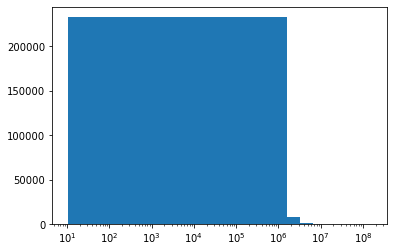

In [13]:
import matplotlib.pyplot as plt

lengths = []
for user_sum in train_sum:
    lengths += [np.sum(user_sum)]

_ = plt.hist(lengths, bins=100)
plt.xscale('log')

In [14]:
lengths = np.array(lengths)

lengths[lengths > 1e7].shape, lengths.shape


((192,), (243346,))

In [15]:
lengths

array([ 70986.  , 178746.  , 375351.16, ..., 120583.96, 131183.96,
       131512.26])

In [15]:
import torch
from torch.utils.data import Dataset, DataLoader

In [16]:
MERCH_TYPE_NCLASSES = len(mappings['merchant_type'])
TRANS_TYPE_NCLASSES = len(mappings['transaction_type_desc'])
PADDING_LEN = 128

In [17]:
class RSDataset(Dataset):
    def __init__(self, data_sum, data_trans_type, data_merchant_type, data_social_info, labels):
        super(RSDataset, self).__init__()
        self.data_sum = data_sum
        self.data_trans_type = data_trans_type
        self.data_merchant_type = data_merchant_type
        self.data_social_info = data_social_info
        self.labels = labels

    def __len__(self):
        return len(self.data_sum)

    def __getitem__(self, idx):
        targets = np.zeros((MERCH_TYPE_NCLASSES - 1,), dtype=np.float32)
        for m in self.labels[idx]:
            if m:  # skip UNK, UNK-token should not be predicted
                targets[m - 1] = 1.0

        item = {
            "features": {},
            "targets": targets,
        }

        sum_feature = np.array(self.data_sum[idx][-PADDING_LEN:])
        sum_feature = np.vectorize(lambda s: np.log(1 + s))(sum_feature)
        if sum_feature.shape[0] < PADDING_LEN:
            pad = np.zeros(
                (PADDING_LEN - sum_feature.shape[0],), dtype=np.float32
            )
            sum_feature = np.hstack((sum_feature, pad))
        item["features"]["sum"] = torch.from_numpy(sum_feature).float()
        
        social_info_feature = np.array(self.data_social_info[idx][-PADDING_LEN:])
        if social_info_feature.shape[0] < PADDING_LEN:
            pad = np.zeros(
                (PADDING_LEN - social_info_feature.shape[0],), dtype=np.float32
            )
            social_info_feature = np.hstack((social_info_feature, pad))
                
        item["features"]["social_info"] = torch.from_numpy(social_info_feature).long()
        
        for feature_name, feature_values in zip(
            ["trans_type", "merchant_type"],
            [self.data_trans_type[idx], self.data_merchant_type[idx]],
        ):

            feature_values = np.array(feature_values[-PADDING_LEN:])
            mask = np.ones(feature_values.shape[0], dtype=np.float32)
            if feature_values.shape[0] < PADDING_LEN:
                feature_values = np.append(
                    feature_values,
                    np.zeros(
                        PADDING_LEN - feature_values.shape[0], dtype=np.int64
                    ),
                )
                mask = np.append(
                    mask,
                    np.zeros(PADDING_LEN - mask.shape[0], dtype=np.float32),
                )
            item["features"][feature_name] = torch.from_numpy(feature_values).long()
            item["features"][f"{feature_name}_mask"] = torch.from_numpy(mask).float()
                

        return item

In [18]:
train_dataset = RSDataset(
    train_sum, train_trans_type, train_merchant_type, train_social_info, train_labels
)
valid_dataset = RSDataset(
    valid_sum, valid_trans_type, valid_merchant_type, valid_social_info, valid_labels
)


In [19]:
train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=2
)
valid_loader = DataLoader(
    valid_dataset, batch_size=64, shuffle=False, num_workers=2
)

In [20]:
# sanity check
for i in tqdm(range(len(train_loader))):
    batch = next(iter(train_loader))
    print(batch['features'].keys())
    print(batch['features']['merchant_type'].shape)
    print(batch['features']['sum'])
    print(batch['features']['trans_type'])
    print(batch['targets'].shape)
    print(batch['targets'])
    print(batch['features']['trans_type'][0], batch['features']['trans_type_mask'][0])
    print(batch['features']['social_info'][0])
    break

  0%|          | 0/3803 [00:00<?, ?it/s]

dict_keys(['sum', 'social_info', 'trans_type', 'trans_type_mask', 'merchant_type', 'merchant_type_mask'])
torch.Size([64, 128])
tensor([[3.5175, 4.2767, 3.9318,  ..., 5.2523, 5.9038, 4.7958],
        [5.3297, 6.6562, 4.6249,  ..., 0.0000, 0.0000, 0.0000],
        [8.0186, 5.8235, 6.4468,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [6.9575, 3.3322, 5.9865,  ..., 5.3636, 4.1431, 5.7979],
        [7.3389, 5.8642, 5.4848,  ..., 4.9558, 4.5726, 4.9830],
        [7.4668, 7.5011, 7.4501,  ..., 0.0000, 0.0000, 0.0000]])
tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [3, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [3, 3, 3,  ..., 0, 0, 0]])
torch.Size([64, 457])
tensor([[0., 1., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 1.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        [0., 1., 0., 

## Model

This is the baseline model for predicting purchases in `merchant_type` in the next 2 months

In [35]:
import torch.nn as nn
from collections import OrderedDict

In [36]:
params = {
    'merchant_type_emb_dim': 58,
    'trans_type_embedding': 4,
    'transformer_nhead': 2,
    'transformer_dim_feedforward': 256,
    'transformer_dropout': 0.1,
    'dense_unit': 256,
    'num_layers': 4,
}

In [37]:
SOCIAL_NCLASSES = np.array(train_social_info).shape[1]

In [38]:
MERCH_TYPE_NCLASSES, TRANS_TYPE_NCLASSES, SOCIAL_NCLASSES

(458, 5, 5)

In [39]:
from torch.nn.modules.normalization import LayerNorm

In [40]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.merchant_type_embedding = nn.Embedding(
            MERCH_TYPE_NCLASSES, params["merchant_type_emb_dim"]
        )
        self.trans_type_embedding = nn.Embedding(
            TRANS_TYPE_NCLASSES, params["trans_type_embedding"]
        )

        embedding_size = (
            params["merchant_type_emb_dim"]
            + params["trans_type_embedding"]
            + 1 + 1
        )
        
        transformer_block = nn.TransformerEncoderLayer(d_model=embedding_size,
                                                        nhead=params["transformer_nhead"],
                                                        dim_feedforward=params["transformer_dim_feedforward"],
                                                        dropout=params["transformer_dropout"])
        self.transformer_encoder = nn.TransformerEncoder(transformer_block, 
                                                         params["num_layers"], 
                                                         LayerNorm(embedding_size))

        self.linear = nn.Linear(
            in_features=embedding_size, out_features=params["dense_unit"]
        )
        self.scorer = nn.Linear(
            in_features=params["dense_unit"],
            out_features=MERCH_TYPE_NCLASSES - 1,
        )

    def forward(self, features):

        merchant_type_emb = self.merchant_type_embedding(features["merchant_type"])
        trans_type_emb = self.trans_type_embedding(features["trans_type"])

        merchant_type_emb = merchant_type_emb * features["merchant_type_mask"].unsqueeze(-1)
        trans_type_emb = trans_type_emb * features["trans_type_mask"].unsqueeze(-1)

        embeddings = torch.cat(
            (merchant_type_emb, trans_type_emb, 
             features["sum"].unsqueeze(-1), 
             features["social_info"].unsqueeze(-1)),
            dim=-1,
        )

        transformer_output = self.transformer_encoder(embeddings)
        pooling = torch.mean(transformer_output, dim=1)
        linear = torch.tanh(self.linear(pooling))
        merch_logits = self.scorer(linear)

        return merch_logits

### One-batch-check

In [41]:
%%time
model = Model()
criterion = nn.BCEWithLogitsLoss()
batch = next(iter(train_loader))
output = model(batch['features'])
loss = criterion(output, batch['targets'])
print(loss)

tensor(0.7026, grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
CPU times: user 975 ms, sys: 369 ms, total: 1.34 s
Wall time: 342 ms


## Train loop with [Catalyst](https://github.com/catalyst-team/catalyst)

[A comprehensive step-by-step guide to basic and advanced features](https://github.com/catalyst-team/catalyst#step-by-step-guide).

---



In [42]:
from catalyst import dl, utils
from catalyst.utils import metrics

## Custom metrics for this hackathon

In [43]:
from typing import List, Optional, Sequence, Tuple, Union

import numpy as np
import torch
from catalyst.utils.metrics.functional import preprocess_multi_label_metrics
from catalyst.utils.torch import get_activation_fn


def multi_label_metrics(
    outputs: torch.Tensor,
    targets: torch.Tensor,
    threshold: Union[float, torch.Tensor],
    activation: Optional[str] = None,
    eps: float = 1e-7,
) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Computes multi-label precision for the specified activation and threshold.

    Args:
        outputs (torch.Tensor): NxK tensor that for each of the N examples
            indicates the probability of the example belonging to each of
            the K classes, according to the model.
        targets (torch.Tensor): binary NxK tensort that encodes which of the K
            classes are associated with the N-th input
            (eg: a row [0, 1, 0, 1] indicates that the example is
            associated with classes 2 and 4)
        threshold (float): threshold for for model output
        activation (str): activation to use for model output
        eps (float): epsilon to avoid zero division
    
    Extended version of 
        https://github.com/catalyst-team/catalyst/blob/master/catalyst/utils/metrics/accuracy.py#L58

    Returns:
        computed multi-label metrics
    """
    outputs, targets, _ = preprocess_multi_label_metrics(
        outputs=outputs, targets=targets
    )
    activation_fn = get_activation_fn(activation)
    outputs = activation_fn(outputs)

    outputs = (outputs > threshold).long()

    accuracy = (targets.long() == outputs.long()).sum().float() / np.prod(
        targets.shape
    )

    intersection = (outputs.long() * targets.long()).sum(axis=1).float()
    num_predicted = outputs.long().sum(axis=1).float()
    num_relevant = targets.long().sum(axis=1).float()
    union = num_predicted + num_relevant

    # Precision = ({predicted items} && {relevant items}) / {predicted items}
    precision = intersection / (num_predicted + eps * (num_predicted == 0))
    # Recall = ({predicted items} && {relevant items}) / {relevant items}
    recall = intersection / (num_relevant + eps * (num_relevant == 0))
    # IoU = ({predicted items} && {relevant items}) / ({predicted items} || {relevant items})
    iou = (intersection + eps * (union == 0)) / (union - intersection + eps)

    return accuracy, precision.mean(), recall.mean(), iou.mean()


def precision_at_k(
    actual: torch.Tensor, 
    predicted: torch.Tensor, 
    k: int,
):
    """
    Computes precision at cutoff k for one sample

    Args:
       actual: (torch.Tensor): tensor of length K with predicted item_ids sorted by relevance
       predicted (torch.Tensor): binary tensor that encodes which of the K
           classes are associated with the N-th input
           (eg: a row [0, 1, 0, 1] indicates that the example is
           associated with classes 2 and 4)
       k (int): parameter k of precison@k

    Returns:
       Computed value of precision@k for given sample
    """
    p_at_k = 0.0
    for item in predicted[:k]:
        if actual[item]:
            p_at_k += 1
    p_at_k /= k

    return p_at_k


def average_precision_at_k(
    actual: torch.Tensor, 
    predicted: torch.Tensor, 
    k: int,
) -> float:
    """
    Computes average precision at cutoff k for one sample

    Args:
      actual: (torch.Tensor): tensor of length K with predicted item_ids sorted by relevance
      predicted (torch.Tensor): binary tensor that encodes which of the K
          classes are associated with the N-th input
          (eg: a row [0, 1, 0, 1] indicates that the example is
          associated with classes 2 and 4)
      k (int): parameter k of AP@k

    Returns:
        Computed value of AP@k for given sample
    """
    ap_at_k = 0.0
    for idx, item in enumerate(predicted[:k]):
        if actual[item]:
            ap_at_k += precision_at_k(actual, predicted, k=idx + 1)
    ap_at_k /= min(k, actual.sum().cpu().numpy())
    

    return ap_at_k


def mean_average_precision_at_k(
    output: torch.Tensor, target: torch.Tensor, top_k: Tuple[int, ...] = (1,)
) -> List[float]:
    """
    Computes mean_average_precision_at_k at set of cutoff parameters K

    Args:
       outputs (torch.Tensor): NxK tensor that for each of the N examples
           indicates the probability of the example belonging to each of
           the K classes, according to the model.
       targets (torch.Tensor): binary NxK tensort that encodes which of the K
           classes are associated with the N-th input
           (eg: a row [0, 1, 0, 1] indicates that the example is
           associated with classes 2 and 4)
       top_k (tuple): list of parameters k at which map@k will be computed


    Returns:
       List of computed values of map@k at each cutoff k from topk
    """
    max_k = max(top_k)
    batch_size = target.size(0)

    _, top_indices = output.topk(k=max_k, dim=1, largest=True, sorted=True)

    result = []
    for k in top_k:  # loop over k
        map_at_k = 0.0
        for actual_target, predicted_items in zip(
            target, top_indices
        ):  # loop over samples
            map_at_k += average_precision_at_k(
                actual_target, predicted_items, k
            )
        map_at_k = map_at_k / batch_size
        result.append(map_at_k)

    return result

In [44]:
# What is Runner?
# https://catalyst-team.github.io/catalyst/api/core.html#runner
class CustomRunner(dl.Runner):

    def _handle_batch(self, batch):
        # model train/valid step
        features, targets = batch["features"], batch["targets"]
        logits = self.model(features)
        scores = torch.sigmoid(logits)

        loss = self.criterion(logits, targets)
        accuracy, precision, recall, iou = multi_label_metrics(
            logits, targets, threshold=0.5, activation="Sigmoid"
        )
        map05, map10, map20, map30 = mean_average_precision_at_k(
            scores, targets, top_k=(5, 10, 20, 30)
        )
        
        self.input = {"features": features, "targets": targets}
        self.output = {"logits": logits, "scores": scores}
        
        if not self.is_train_loader:
            batch_metrics = {
                                "loss": loss,
                                "precision": precision,
                                "recall": recall,
                                "map30": map30
                            }
            self.batch_metrics.update(batch_metrics)

        if self.is_train_loader:
            batch_metrics = {
                                "loss": loss,
                            }
            
            self.batch_metrics.update(batch_metrics)
            
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
    
    def predict_batch(self, batch):
        # model inference step
        batch = utils.maybe_recursive_call(batch, "to", device=self.device)
        logits = self.model(batch["features"])
        scores = torch.sigmoid(logits)
        return scores

In [45]:
model = Model()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loaders = {"train": train_loader, "valid": valid_loader}

In [67]:
%load_ext tensorboard
%tensorboard --logdir ./logs

Reusing TensorBoard on port 6006 (pid 501), started 4:09:05 ago. (Use '!kill 501' to kill it.)

In [ ]:
# For other minimal examples, please follow the link below
# https://github.com/catalyst-team/catalyst#minimal-examples
runner = CustomRunner()
# model training
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=None,
    loaders=loaders,
    logdir="./logs/social_info_map30",
    num_epochs=10,
    verbose=True,
    load_best_on_end=True,
    overfit=False,  #  <<<--- DO NOT FORGET TO MAKE IT ``False`` 
                    #  (``True`` uses only one batch to check pipeline correctness)
    callbacks=[
        # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html
        # dl.AveragePrecisionCallback(input_key="targets", output_key="scores", prefix="ap"),
        # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
        # dl.AUCCallback(input_key="targets", output_key="scores", prefix="auc"),
    ],
    main_metric="map30", # "ap/mean", 
    minimize_metric=False,
)


1/10 * Epoch (train):   0% 0/3803 [00:00<?, ?it/s]
1/10 * Epoch (train):   0% 0/3803 [00:00<?, ?it/s, loss=0.698]
1/10 * Epoch (train):   0% 1/3803 [00:00<28:01,  2.26it/s, loss=0.698]
1/10 * Epoch (train):   0% 1/3803 [00:00<28:01,  2.26it/s, loss=0.647]
1/10 * Epoch (train):   0% 2/3803 [00:00<24:51,  2.55it/s, loss=0.647]
1/10 * Epoch (train):   0% 2/3803 [00:00<24:51,  2.55it/s, loss=0.599]
1/10 * Epoch (train):   0% 3/3803 [00:00<22:33,  2.81it/s, loss=0.599]
1/10 * Epoch (train):   0% 3/3803 [00:01<22:33,  2.81it/s, loss=0.549]
1/10 * Epoch (train):   0% 4/3803 [00:01<20:59,  3.02it/s, loss=0.549]
1/10 * Epoch (train):   0% 4/3803 [00:01<20:59,  3.02it/s, loss=0.499]
1/10 * Epoch (train):   0% 5/3803 [00:01<20:04,  3.15it/s, loss=0.499]
1/10 * Epoch (train):   0% 5/3803 [00:01<20:04,  3.15it/s, loss=0.449]
1/10 * Epoch (train):   0% 6/3803 [00:01<19:36,  3.23it/s, loss=0.449]
1/10 * Epoch (train):   0% 6/3803 [00:02<19:36,  3.23it/s, loss=0.398]
1/10 * Epoch (train):   0% 7/3803

1/10 * Epoch (train):   1% 54/3803 [00:23<29:56,  2.09it/s, loss=0.057]
1/10 * Epoch (train):   1% 55/3803 [00:23<29:35,  2.11it/s, loss=0.057]
1/10 * Epoch (train):   1% 55/3803 [00:24<29:35,  2.11it/s, loss=0.062]
1/10 * Epoch (train):   1% 56/3803 [00:24<29:20,  2.13it/s, loss=0.062]
1/10 * Epoch (train):   1% 56/3803 [00:24<29:20,  2.13it/s, loss=0.066]
1/10 * Epoch (train):   1% 57/3803 [00:24<29:28,  2.12it/s, loss=0.066]
1/10 * Epoch (train):   1% 57/3803 [00:24<29:28,  2.12it/s, loss=0.058]
1/10 * Epoch (train):   2% 58/3803 [00:24<28:35,  2.18it/s, loss=0.058]
1/10 * Epoch (train):   2% 58/3803 [00:25<28:35,  2.18it/s, loss=0.055]
1/10 * Epoch (train):   2% 59/3803 [00:25<28:18,  2.20it/s, loss=0.055]
1/10 * Epoch (train):   2% 59/3803 [00:25<28:18,  2.20it/s, loss=0.080]
1/10 * Epoch (train):   2% 60/3803 [00:25<29:51,  2.09it/s, loss=0.080]
1/10 * Epoch (train):   2% 60/3803 [00:26<29:51,  2.09it/s, loss=0.060]
1/10 * Epoch (train):   2% 61/3803 [00:26<29:16,  2.13it/s, loss

1/10 * Epoch (train):   3% 109/3803 [00:49<29:12,  2.11it/s, loss=0.067]
1/10 * Epoch (train):   3% 109/3803 [00:50<29:12,  2.11it/s, loss=0.070]
1/10 * Epoch (train):   3% 110/3803 [00:50<30:09,  2.04it/s, loss=0.070]
1/10 * Epoch (train):   3% 110/3803 [00:50<30:09,  2.04it/s, loss=0.068]
1/10 * Epoch (train):   3% 111/3803 [00:50<30:41,  2.00it/s, loss=0.068]
1/10 * Epoch (train):   3% 111/3803 [00:51<30:41,  2.00it/s, loss=0.069]
1/10 * Epoch (train):   3% 112/3803 [00:51<30:43,  2.00it/s, loss=0.069]
1/10 * Epoch (train):   3% 112/3803 [00:51<30:43,  2.00it/s, loss=0.061]
1/10 * Epoch (train):   3% 113/3803 [00:51<29:44,  2.07it/s, loss=0.061]
1/10 * Epoch (train):   3% 113/3803 [00:51<29:44,  2.07it/s, loss=0.069]
1/10 * Epoch (train):   3% 114/3803 [00:51<30:12,  2.04it/s, loss=0.069]
1/10 * Epoch (train):   3% 114/3803 [00:52<30:12,  2.04it/s, loss=0.064]
1/10 * Epoch (train):   3% 115/3803 [00:52<29:11,  2.11it/s, loss=0.064]
1/10 * Epoch (train):   3% 115/3803 [00:52<29:11,  

1/10 * Epoch (train):   4% 162/3803 [01:15<29:41,  2.04it/s, loss=0.062]
1/10 * Epoch (train):   4% 163/3803 [01:15<29:47,  2.04it/s, loss=0.062]
1/10 * Epoch (train):   4% 163/3803 [01:16<29:47,  2.04it/s, loss=0.058]
1/10 * Epoch (train):   4% 164/3803 [01:16<29:07,  2.08it/s, loss=0.058]
1/10 * Epoch (train):   4% 164/3803 [01:16<29:07,  2.08it/s, loss=0.062]
1/10 * Epoch (train):   4% 165/3803 [01:16<29:09,  2.08it/s, loss=0.062]
1/10 * Epoch (train):   4% 165/3803 [01:17<29:09,  2.08it/s, loss=0.052]
1/10 * Epoch (train):   4% 166/3803 [01:17<27:29,  2.20it/s, loss=0.052]
1/10 * Epoch (train):   4% 166/3803 [01:17<27:29,  2.20it/s, loss=0.068]
1/10 * Epoch (train):   4% 167/3803 [01:17<28:19,  2.14it/s, loss=0.068]
1/10 * Epoch (train):   4% 167/3803 [01:18<28:19,  2.14it/s, loss=0.070]
1/10 * Epoch (train):   4% 168/3803 [01:18<29:18,  2.07it/s, loss=0.070]
1/10 * Epoch (train):   4% 168/3803 [01:18<29:18,  2.07it/s, loss=0.057]
1/10 * Epoch (train):   4% 169/3803 [01:18<28:52,  

1/10 * Epoch (train):   6% 216/3803 [01:41<28:36,  2.09it/s, loss=0.064]
1/10 * Epoch (train):   6% 216/3803 [01:41<28:36,  2.09it/s, loss=0.070]
1/10 * Epoch (train):   6% 217/3803 [01:41<29:33,  2.02it/s, loss=0.070]
1/10 * Epoch (train):   6% 217/3803 [01:42<29:33,  2.02it/s, loss=0.061]
1/10 * Epoch (train):   6% 218/3803 [01:42<29:33,  2.02it/s, loss=0.061]
1/10 * Epoch (train):   6% 218/3803 [01:43<29:33,  2.02it/s, loss=0.076]
1/10 * Epoch (train):   6% 219/3803 [01:43<30:25,  1.96it/s, loss=0.076]
1/10 * Epoch (train):   6% 219/3803 [01:43<30:25,  1.96it/s, loss=0.051]
1/10 * Epoch (train):   6% 220/3803 [01:43<28:50,  2.07it/s, loss=0.051]
1/10 * Epoch (train):   6% 220/3803 [01:43<28:50,  2.07it/s, loss=0.071]
1/10 * Epoch (train):   6% 221/3803 [01:43<29:34,  2.02it/s, loss=0.071]
1/10 * Epoch (train):   6% 221/3803 [01:44<29:34,  2.02it/s, loss=0.069]
1/10 * Epoch (train):   6% 222/3803 [01:44<30:07,  1.98it/s, loss=0.069]
1/10 * Epoch (train):   6% 222/3803 [01:45<30:07,  

1/10 * Epoch (train):   7% 269/3803 [02:08<30:14,  1.95it/s, loss=0.064]
1/10 * Epoch (train):   7% 270/3803 [02:08<29:38,  1.99it/s, loss=0.064]
1/10 * Epoch (train):   7% 270/3803 [02:08<29:38,  1.99it/s, loss=0.060]
1/10 * Epoch (train):   7% 271/3803 [02:08<28:46,  2.05it/s, loss=0.060]
1/10 * Epoch (train):   7% 271/3803 [02:09<28:46,  2.05it/s, loss=0.065]
1/10 * Epoch (train):   7% 272/3803 [02:09<28:59,  2.03it/s, loss=0.065]
1/10 * Epoch (train):   7% 272/3803 [02:09<28:59,  2.03it/s, loss=0.061]
1/10 * Epoch (train):   7% 273/3803 [02:09<28:40,  2.05it/s, loss=0.061]
1/10 * Epoch (train):   7% 273/3803 [02:10<28:40,  2.05it/s, loss=0.067]
1/10 * Epoch (train):   7% 274/3803 [02:10<28:54,  2.04it/s, loss=0.067]
1/10 * Epoch (train):   7% 274/3803 [02:10<28:54,  2.04it/s, loss=0.065]
1/10 * Epoch (train):   7% 275/3803 [02:10<28:59,  2.03it/s, loss=0.065]
1/10 * Epoch (train):   7% 275/3803 [02:11<28:59,  2.03it/s, loss=0.063]
1/10 * Epoch (train):   7% 276/3803 [02:11<29:22,  

1/10 * Epoch (train):   8% 323/3803 [02:35<29:14,  1.98it/s, loss=0.066]
1/10 * Epoch (train):   8% 323/3803 [02:35<29:14,  1.98it/s, loss=0.075]
1/10 * Epoch (train):   9% 324/3803 [02:35<29:46,  1.95it/s, loss=0.075]
1/10 * Epoch (train):   9% 324/3803 [02:36<29:46,  1.95it/s, loss=0.063]
1/10 * Epoch (train):   9% 325/3803 [02:36<29:40,  1.95it/s, loss=0.063]
1/10 * Epoch (train):   9% 325/3803 [02:36<29:40,  1.95it/s, loss=0.070]
1/10 * Epoch (train):   9% 326/3803 [02:36<29:51,  1.94it/s, loss=0.070]
1/10 * Epoch (train):   9% 326/3803 [02:37<29:51,  1.94it/s, loss=0.071]
1/10 * Epoch (train):   9% 327/3803 [02:37<29:54,  1.94it/s, loss=0.071]
1/10 * Epoch (train):   9% 327/3803 [02:37<29:54,  1.94it/s, loss=0.063]
1/10 * Epoch (train):   9% 328/3803 [02:37<29:30,  1.96it/s, loss=0.063]
1/10 * Epoch (train):   9% 328/3803 [02:38<29:30,  1.96it/s, loss=0.071]
1/10 * Epoch (train):   9% 329/3803 [02:38<29:20,  1.97it/s, loss=0.071]
1/10 * Epoch (train):   9% 329/3803 [02:38<29:20,  

1/10 * Epoch (train):  10% 376/3803 [03:01<27:08,  2.10it/s, loss=0.069]
1/10 * Epoch (train):  10% 377/3803 [03:01<28:14,  2.02it/s, loss=0.069]
1/10 * Epoch (train):  10% 377/3803 [03:02<28:14,  2.02it/s, loss=0.055]
1/10 * Epoch (train):  10% 378/3803 [03:02<27:36,  2.07it/s, loss=0.055]
1/10 * Epoch (train):  10% 378/3803 [03:02<27:36,  2.07it/s, loss=0.063]
1/10 * Epoch (train):  10% 379/3803 [03:02<27:57,  2.04it/s, loss=0.063]
1/10 * Epoch (train):  10% 379/3803 [03:03<27:57,  2.04it/s, loss=0.074]
1/10 * Epoch (train):  10% 380/3803 [03:03<29:10,  1.96it/s, loss=0.074]
1/10 * Epoch (train):  10% 380/3803 [03:03<29:10,  1.96it/s, loss=0.058]
1/10 * Epoch (train):  10% 381/3803 [03:03<28:12,  2.02it/s, loss=0.058]
1/10 * Epoch (train):  10% 381/3803 [03:04<28:12,  2.02it/s, loss=0.072]
1/10 * Epoch (train):  10% 382/3803 [03:04<29:29,  1.93it/s, loss=0.072]
1/10 * Epoch (train):  10% 382/3803 [03:04<29:29,  1.93it/s, loss=0.066]
1/10 * Epoch (train):  10% 383/3803 [03:04<29:34,  

1/10 * Epoch (train):  11% 430/3803 [03:27<27:21,  2.05it/s, loss=0.058]
1/10 * Epoch (train):  11% 430/3803 [03:28<27:21,  2.05it/s, loss=0.060]
1/10 * Epoch (train):  11% 431/3803 [03:28<27:52,  2.02it/s, loss=0.060]
1/10 * Epoch (train):  11% 431/3803 [03:28<27:52,  2.02it/s, loss=0.056]
1/10 * Epoch (train):  11% 432/3803 [03:28<27:43,  2.03it/s, loss=0.056]
1/10 * Epoch (train):  11% 432/3803 [03:29<27:43,  2.03it/s, loss=0.063]
1/10 * Epoch (train):  11% 433/3803 [03:29<28:14,  1.99it/s, loss=0.063]
1/10 * Epoch (train):  11% 433/3803 [03:29<28:14,  1.99it/s, loss=0.068]
1/10 * Epoch (train):  11% 434/3803 [03:29<28:29,  1.97it/s, loss=0.068]
1/10 * Epoch (train):  11% 434/3803 [03:30<28:29,  1.97it/s, loss=0.061]
1/10 * Epoch (train):  11% 435/3803 [03:30<28:19,  1.98it/s, loss=0.061]
1/10 * Epoch (train):  11% 435/3803 [03:30<28:19,  1.98it/s, loss=0.057]
1/10 * Epoch (train):  11% 436/3803 [03:30<27:23,  2.05it/s, loss=0.057]
1/10 * Epoch (train):  11% 436/3803 [03:31<27:23,  

1/10 * Epoch (train):  13% 483/3803 [03:54<27:07,  2.04it/s, loss=0.060]
1/10 * Epoch (train):  13% 484/3803 [03:54<27:22,  2.02it/s, loss=0.060]
1/10 * Epoch (train):  13% 484/3803 [03:54<27:22,  2.02it/s, loss=0.063]
1/10 * Epoch (train):  13% 485/3803 [03:54<27:11,  2.03it/s, loss=0.063]
1/10 * Epoch (train):  13% 485/3803 [03:55<27:11,  2.03it/s, loss=0.066]
1/10 * Epoch (train):  13% 486/3803 [03:55<27:37,  2.00it/s, loss=0.066]
1/10 * Epoch (train):  13% 486/3803 [03:55<27:37,  2.00it/s, loss=0.067]
1/10 * Epoch (train):  13% 487/3803 [03:55<27:35,  2.00it/s, loss=0.067]
1/10 * Epoch (train):  13% 487/3803 [03:56<27:35,  2.00it/s, loss=0.056]
1/10 * Epoch (train):  13% 488/3803 [03:56<26:57,  2.05it/s, loss=0.056]
1/10 * Epoch (train):  13% 488/3803 [03:56<26:57,  2.05it/s, loss=0.062]
1/10 * Epoch (train):  13% 489/3803 [03:56<26:58,  2.05it/s, loss=0.062]
1/10 * Epoch (train):  13% 489/3803 [03:57<26:58,  2.05it/s, loss=0.062]
1/10 * Epoch (train):  13% 490/3803 [03:57<27:21,  

1/10 * Epoch (train):  14% 537/3803 [04:20<26:55,  2.02it/s, loss=0.061]
1/10 * Epoch (train):  14% 537/3803 [04:21<26:55,  2.02it/s, loss=0.057]
1/10 * Epoch (train):  14% 538/3803 [04:21<27:02,  2.01it/s, loss=0.057]
1/10 * Epoch (train):  14% 538/3803 [04:21<27:02,  2.01it/s, loss=0.069]
1/10 * Epoch (train):  14% 539/3803 [04:21<28:01,  1.94it/s, loss=0.069]
1/10 * Epoch (train):  14% 539/3803 [04:22<28:01,  1.94it/s, loss=0.063]
1/10 * Epoch (train):  14% 540/3803 [04:22<27:45,  1.96it/s, loss=0.063]
1/10 * Epoch (train):  14% 540/3803 [04:22<27:45,  1.96it/s, loss=0.071]
1/10 * Epoch (train):  14% 541/3803 [04:22<28:22,  1.92it/s, loss=0.071]
1/10 * Epoch (train):  14% 541/3803 [04:23<28:22,  1.92it/s, loss=0.063]
1/10 * Epoch (train):  14% 542/3803 [04:23<28:03,  1.94it/s, loss=0.063]
1/10 * Epoch (train):  14% 542/3803 [04:23<28:03,  1.94it/s, loss=0.064]
1/10 * Epoch (train):  14% 543/3803 [04:23<28:13,  1.92it/s, loss=0.064]
1/10 * Epoch (train):  14% 543/3803 [04:24<28:13,  

1/10 * Epoch (train):  16% 590/3803 [04:47<26:19,  2.03it/s, loss=0.068]
1/10 * Epoch (train):  16% 591/3803 [04:47<27:00,  1.98it/s, loss=0.068]
1/10 * Epoch (train):  16% 591/3803 [04:47<27:00,  1.98it/s, loss=0.061]
1/10 * Epoch (train):  16% 592/3803 [04:47<26:10,  2.04it/s, loss=0.061]
1/10 * Epoch (train):  16% 592/3803 [04:47<26:10,  2.04it/s, loss=0.065]
1/10 * Epoch (train):  16% 593/3803 [04:47<26:27,  2.02it/s, loss=0.065]
1/10 * Epoch (train):  16% 593/3803 [04:48<26:27,  2.02it/s, loss=0.056]
1/10 * Epoch (train):  16% 594/3803 [04:48<26:04,  2.05it/s, loss=0.056]
1/10 * Epoch (train):  16% 594/3803 [04:48<26:04,  2.05it/s, loss=0.060]
1/10 * Epoch (train):  16% 595/3803 [04:48<26:25,  2.02it/s, loss=0.060]
1/10 * Epoch (train):  16% 595/3803 [04:49<26:25,  2.02it/s, loss=0.065]
1/10 * Epoch (train):  16% 596/3803 [04:49<27:36,  1.94it/s, loss=0.065]
1/10 * Epoch (train):  16% 596/3803 [04:50<27:36,  1.94it/s, loss=0.059]
1/10 * Epoch (train):  16% 597/3803 [04:50<27:02,  

1/10 * Epoch (train):  17% 644/3803 [05:13<26:42,  1.97it/s, loss=0.063]
1/10 * Epoch (train):  17% 644/3803 [05:13<26:42,  1.97it/s, loss=0.063]
1/10 * Epoch (train):  17% 645/3803 [05:13<26:35,  1.98it/s, loss=0.063]
1/10 * Epoch (train):  17% 645/3803 [05:14<26:35,  1.98it/s, loss=0.058]
1/10 * Epoch (train):  17% 646/3803 [05:14<26:16,  2.00it/s, loss=0.058]
1/10 * Epoch (train):  17% 646/3803 [05:14<26:16,  2.00it/s, loss=0.059]
1/10 * Epoch (train):  17% 647/3803 [05:14<26:12,  2.01it/s, loss=0.059]
1/10 * Epoch (train):  17% 647/3803 [05:15<26:12,  2.01it/s, loss=0.065]
1/10 * Epoch (train):  17% 648/3803 [05:15<26:30,  1.98it/s, loss=0.065]
1/10 * Epoch (train):  17% 648/3803 [05:15<26:30,  1.98it/s, loss=0.060]
1/10 * Epoch (train):  17% 649/3803 [05:15<26:26,  1.99it/s, loss=0.060]
1/10 * Epoch (train):  17% 649/3803 [05:16<26:26,  1.99it/s, loss=0.061]
1/10 * Epoch (train):  17% 650/3803 [05:16<26:09,  2.01it/s, loss=0.061]
1/10 * Epoch (train):  17% 650/3803 [05:16<26:09,  

1/10 * Epoch (train):  18% 697/3803 [05:40<25:56,  2.00it/s, loss=0.053]
1/10 * Epoch (train):  18% 698/3803 [05:40<24:45,  2.09it/s, loss=0.053]
1/10 * Epoch (train):  18% 698/3803 [05:40<24:45,  2.09it/s, loss=0.058]
1/10 * Epoch (train):  18% 699/3803 [05:40<24:35,  2.10it/s, loss=0.058]
1/10 * Epoch (train):  18% 699/3803 [05:41<24:35,  2.10it/s, loss=0.054]
1/10 * Epoch (train):  18% 700/3803 [05:41<24:07,  2.14it/s, loss=0.054]
1/10 * Epoch (train):  18% 700/3803 [05:41<24:07,  2.14it/s, loss=0.059]
1/10 * Epoch (train):  18% 701/3803 [05:41<24:43,  2.09it/s, loss=0.059]
1/10 * Epoch (train):  18% 701/3803 [05:41<24:43,  2.09it/s, loss=0.052]
1/10 * Epoch (train):  18% 702/3803 [05:41<24:00,  2.15it/s, loss=0.052]
1/10 * Epoch (train):  18% 702/3803 [05:42<24:00,  2.15it/s, loss=0.063]
1/10 * Epoch (train):  18% 703/3803 [05:42<24:39,  2.09it/s, loss=0.063]
1/10 * Epoch (train):  18% 703/3803 [05:43<24:39,  2.09it/s, loss=0.063]
1/10 * Epoch (train):  19% 704/3803 [05:43<25:23,  

1/10 * Epoch (train):  20% 751/3803 [06:06<24:49,  2.05it/s, loss=0.048]
1/10 * Epoch (train):  20% 751/3803 [06:07<24:49,  2.05it/s, loss=0.067]
1/10 * Epoch (train):  20% 752/3803 [06:07<25:47,  1.97it/s, loss=0.067]
1/10 * Epoch (train):  20% 752/3803 [06:07<25:47,  1.97it/s, loss=0.055]
1/10 * Epoch (train):  20% 753/3803 [06:07<25:15,  2.01it/s, loss=0.055]
1/10 * Epoch (train):  20% 753/3803 [06:07<25:15,  2.01it/s, loss=0.057]
1/10 * Epoch (train):  20% 754/3803 [06:07<24:45,  2.05it/s, loss=0.057]
1/10 * Epoch (train):  20% 754/3803 [06:08<24:45,  2.05it/s, loss=0.065]
1/10 * Epoch (train):  20% 755/3803 [06:08<25:22,  2.00it/s, loss=0.065]
1/10 * Epoch (train):  20% 755/3803 [06:08<25:22,  2.00it/s, loss=0.058]
1/10 * Epoch (train):  20% 756/3803 [06:08<25:14,  2.01it/s, loss=0.058]
1/10 * Epoch (train):  20% 756/3803 [06:09<25:14,  2.01it/s, loss=0.058]
1/10 * Epoch (train):  20% 757/3803 [06:09<25:25,  2.00it/s, loss=0.058]
1/10 * Epoch (train):  20% 757/3803 [06:09<25:25,  

1/10 * Epoch (train):  21% 804/3803 [06:33<24:18,  2.06it/s, loss=0.058]
1/10 * Epoch (train):  21% 805/3803 [06:33<24:28,  2.04it/s, loss=0.058]
1/10 * Epoch (train):  21% 805/3803 [06:33<24:28,  2.04it/s, loss=0.064]
1/10 * Epoch (train):  21% 806/3803 [06:33<24:46,  2.02it/s, loss=0.064]
1/10 * Epoch (train):  21% 806/3803 [06:34<24:46,  2.02it/s, loss=0.067]
1/10 * Epoch (train):  21% 807/3803 [06:34<24:45,  2.02it/s, loss=0.067]
1/10 * Epoch (train):  21% 807/3803 [06:34<24:45,  2.02it/s, loss=0.063]
1/10 * Epoch (train):  21% 808/3803 [06:34<25:10,  1.98it/s, loss=0.063]
1/10 * Epoch (train):  21% 808/3803 [06:35<25:10,  1.98it/s, loss=0.065]
1/10 * Epoch (train):  21% 809/3803 [06:35<25:19,  1.97it/s, loss=0.065]
1/10 * Epoch (train):  21% 809/3803 [06:35<25:19,  1.97it/s, loss=0.061]
1/10 * Epoch (train):  21% 810/3803 [06:35<25:11,  1.98it/s, loss=0.061]
1/10 * Epoch (train):  21% 810/3803 [06:36<25:11,  1.98it/s, loss=0.068]
1/10 * Epoch (train):  21% 811/3803 [06:36<25:41,  

1/10 * Epoch (train):  23% 858/3803 [06:59<24:46,  1.98it/s, loss=0.060]
1/10 * Epoch (train):  23% 858/3803 [06:59<24:46,  1.98it/s, loss=0.057]
1/10 * Epoch (train):  23% 859/3803 [06:59<24:13,  2.03it/s, loss=0.057]
1/10 * Epoch (train):  23% 859/3803 [07:00<24:13,  2.03it/s, loss=0.061]
1/10 * Epoch (train):  23% 860/3803 [07:00<24:22,  2.01it/s, loss=0.061]
1/10 * Epoch (train):  23% 860/3803 [07:00<24:22,  2.01it/s, loss=0.059]
1/10 * Epoch (train):  23% 861/3803 [07:00<24:13,  2.02it/s, loss=0.059]
1/10 * Epoch (train):  23% 861/3803 [07:01<24:13,  2.02it/s, loss=0.058]
1/10 * Epoch (train):  23% 862/3803 [07:01<24:00,  2.04it/s, loss=0.058]
1/10 * Epoch (train):  23% 862/3803 [07:01<24:00,  2.04it/s, loss=0.067]
1/10 * Epoch (train):  23% 863/3803 [07:01<23:45,  2.06it/s, loss=0.067]
1/10 * Epoch (train):  23% 863/3803 [07:02<23:45,  2.06it/s, loss=0.060]
1/10 * Epoch (train):  23% 864/3803 [07:02<23:36,  2.08it/s, loss=0.060]
1/10 * Epoch (train):  23% 864/3803 [07:02<23:36,  

1/10 * Epoch (train):  24% 911/3803 [07:25<23:45,  2.03it/s, loss=0.054]
1/10 * Epoch (train):  24% 912/3803 [07:25<23:16,  2.07it/s, loss=0.054]
1/10 * Epoch (train):  24% 912/3803 [07:26<23:16,  2.07it/s, loss=0.054]
1/10 * Epoch (train):  24% 913/3803 [07:26<22:45,  2.12it/s, loss=0.054]
1/10 * Epoch (train):  24% 913/3803 [07:26<22:45,  2.12it/s, loss=0.059]
1/10 * Epoch (train):  24% 914/3803 [07:26<22:37,  2.13it/s, loss=0.059]
1/10 * Epoch (train):  24% 914/3803 [07:27<22:37,  2.13it/s, loss=0.059]
1/10 * Epoch (train):  24% 915/3803 [07:27<22:18,  2.16it/s, loss=0.059]
1/10 * Epoch (train):  24% 915/3803 [07:27<22:18,  2.16it/s, loss=0.053]
1/10 * Epoch (train):  24% 916/3803 [07:27<21:55,  2.20it/s, loss=0.053]
1/10 * Epoch (train):  24% 916/3803 [07:28<21:55,  2.20it/s, loss=0.067]
1/10 * Epoch (train):  24% 917/3803 [07:28<22:37,  2.13it/s, loss=0.067]
1/10 * Epoch (train):  24% 917/3803 [07:28<22:37,  2.13it/s, loss=0.050]
1/10 * Epoch (train):  24% 918/3803 [07:28<21:56,  

1/10 * Epoch (train):  25% 965/3803 [07:51<23:18,  2.03it/s, loss=0.061]
1/10 * Epoch (train):  25% 965/3803 [07:51<23:18,  2.03it/s, loss=0.059]
1/10 * Epoch (train):  25% 966/3803 [07:51<22:50,  2.07it/s, loss=0.059]
1/10 * Epoch (train):  25% 966/3803 [07:52<22:50,  2.07it/s, loss=0.064]
1/10 * Epoch (train):  25% 967/3803 [07:52<23:01,  2.05it/s, loss=0.064]
1/10 * Epoch (train):  25% 967/3803 [07:52<23:01,  2.05it/s, loss=0.053]
1/10 * Epoch (train):  25% 968/3803 [07:52<22:20,  2.12it/s, loss=0.053]
1/10 * Epoch (train):  25% 968/3803 [07:53<22:20,  2.12it/s, loss=0.063]
1/10 * Epoch (train):  25% 969/3803 [07:53<22:55,  2.06it/s, loss=0.063]
1/10 * Epoch (train):  25% 969/3803 [07:53<22:55,  2.06it/s, loss=0.063]
1/10 * Epoch (train):  26% 970/3803 [07:53<22:49,  2.07it/s, loss=0.063]
1/10 * Epoch (train):  26% 970/3803 [07:54<22:49,  2.07it/s, loss=0.052]
1/10 * Epoch (train):  26% 971/3803 [07:54<22:03,  2.14it/s, loss=0.052]
1/10 * Epoch (train):  26% 971/3803 [07:54<22:03,  

1/10 * Epoch (train):  27% 1018/3803 [08:17<22:20,  2.08it/s, loss=0.053]
1/10 * Epoch (train):  27% 1019/3803 [08:17<21:42,  2.14it/s, loss=0.053]
1/10 * Epoch (train):  27% 1019/3803 [08:18<21:42,  2.14it/s, loss=0.060]
1/10 * Epoch (train):  27% 1020/3803 [08:18<21:40,  2.14it/s, loss=0.060]
1/10 * Epoch (train):  27% 1020/3803 [08:18<21:40,  2.14it/s, loss=0.054]
1/10 * Epoch (train):  27% 1021/3803 [08:18<21:20,  2.17it/s, loss=0.054]
1/10 * Epoch (train):  27% 1021/3803 [08:19<21:20,  2.17it/s, loss=0.063]
1/10 * Epoch (train):  27% 1022/3803 [08:19<21:41,  2.14it/s, loss=0.063]
1/10 * Epoch (train):  27% 1022/3803 [08:19<21:41,  2.14it/s, loss=0.061]
1/10 * Epoch (train):  27% 1023/3803 [08:19<21:51,  2.12it/s, loss=0.061]
1/10 * Epoch (train):  27% 1023/3803 [08:19<21:51,  2.12it/s, loss=0.064]
1/10 * Epoch (train):  27% 1024/3803 [08:19<22:19,  2.07it/s, loss=0.064]
1/10 * Epoch (train):  27% 1024/3803 [08:20<22:19,  2.07it/s, loss=0.067]
1/10 * Epoch (train):  27% 1025/3803 [

1/10 * Epoch (train):  28% 1071/3803 [08:43<23:00,  1.98it/s, loss=0.058]
1/10 * Epoch (train):  28% 1072/3803 [08:43<22:52,  1.99it/s, loss=0.058]
1/10 * Epoch (train):  28% 1072/3803 [08:44<22:52,  1.99it/s, loss=0.058]
1/10 * Epoch (train):  28% 1073/3803 [08:44<22:23,  2.03it/s, loss=0.058]
1/10 * Epoch (train):  28% 1073/3803 [08:44<22:23,  2.03it/s, loss=0.054]
1/10 * Epoch (train):  28% 1074/3803 [08:44<21:33,  2.11it/s, loss=0.054]
1/10 * Epoch (train):  28% 1074/3803 [08:44<21:33,  2.11it/s, loss=0.063]
1/10 * Epoch (train):  28% 1075/3803 [08:44<21:57,  2.07it/s, loss=0.063]
1/10 * Epoch (train):  28% 1075/3803 [08:45<21:57,  2.07it/s, loss=0.058]
1/10 * Epoch (train):  28% 1076/3803 [08:45<21:45,  2.09it/s, loss=0.058]
1/10 * Epoch (train):  28% 1076/3803 [08:45<21:45,  2.09it/s, loss=0.063]
1/10 * Epoch (train):  28% 1077/3803 [08:45<22:02,  2.06it/s, loss=0.063]
1/10 * Epoch (train):  28% 1077/3803 [08:46<22:02,  2.06it/s, loss=0.056]
1/10 * Epoch (train):  28% 1078/3803 [

1/10 * Epoch (train):  30% 1124/3803 [09:09<22:00,  2.03it/s, loss=0.053]
1/10 * Epoch (train):  30% 1125/3803 [09:09<21:28,  2.08it/s, loss=0.053]
1/10 * Epoch (train):  30% 1125/3803 [09:10<21:28,  2.08it/s, loss=0.058]
1/10 * Epoch (train):  30% 1126/3803 [09:10<21:33,  2.07it/s, loss=0.058]
1/10 * Epoch (train):  30% 1126/3803 [09:10<21:33,  2.07it/s, loss=0.064]
1/10 * Epoch (train):  30% 1127/3803 [09:10<21:57,  2.03it/s, loss=0.064]
1/10 * Epoch (train):  30% 1127/3803 [09:11<21:57,  2.03it/s, loss=0.061]
1/10 * Epoch (train):  30% 1128/3803 [09:11<21:24,  2.08it/s, loss=0.061]
1/10 * Epoch (train):  30% 1128/3803 [09:11<21:24,  2.08it/s, loss=0.057]
1/10 * Epoch (train):  30% 1129/3803 [09:11<21:17,  2.09it/s, loss=0.057]
1/10 * Epoch (train):  30% 1129/3803 [09:11<21:17,  2.09it/s, loss=0.053]
1/10 * Epoch (train):  30% 1130/3803 [09:11<21:09,  2.11it/s, loss=0.053]
1/10 * Epoch (train):  30% 1130/3803 [09:12<21:09,  2.11it/s, loss=0.053]
1/10 * Epoch (train):  30% 1131/3803 [

1/10 * Epoch (train):  31% 1177/3803 [09:35<21:31,  2.03it/s, loss=0.053]
1/10 * Epoch (train):  31% 1178/3803 [09:35<20:59,  2.08it/s, loss=0.053]
1/10 * Epoch (train):  31% 1178/3803 [09:35<20:59,  2.08it/s, loss=0.069]
1/10 * Epoch (train):  31% 1179/3803 [09:35<21:24,  2.04it/s, loss=0.069]
1/10 * Epoch (train):  31% 1179/3803 [09:36<21:24,  2.04it/s, loss=0.065]
1/10 * Epoch (train):  31% 1180/3803 [09:36<21:40,  2.02it/s, loss=0.065]
1/10 * Epoch (train):  31% 1180/3803 [09:36<21:40,  2.02it/s, loss=0.056]
1/10 * Epoch (train):  31% 1181/3803 [09:36<21:03,  2.07it/s, loss=0.056]
1/10 * Epoch (train):  31% 1181/3803 [09:37<21:03,  2.07it/s, loss=0.061]
1/10 * Epoch (train):  31% 1182/3803 [09:37<21:08,  2.07it/s, loss=0.061]
1/10 * Epoch (train):  31% 1182/3803 [09:37<21:08,  2.07it/s, loss=0.063]
1/10 * Epoch (train):  31% 1183/3803 [09:37<21:14,  2.06it/s, loss=0.063]
1/10 * Epoch (train):  31% 1183/3803 [09:38<21:14,  2.06it/s, loss=0.061]
1/10 * Epoch (train):  31% 1184/3803 [

1/10 * Epoch (train):  32% 1230/3803 [10:01<22:01,  1.95it/s, loss=0.059]
1/10 * Epoch (train):  32% 1231/3803 [10:01<21:29,  1.99it/s, loss=0.059]
1/10 * Epoch (train):  32% 1231/3803 [10:02<21:29,  1.99it/s, loss=0.059]
1/10 * Epoch (train):  32% 1232/3803 [10:02<21:09,  2.02it/s, loss=0.059]
1/10 * Epoch (train):  32% 1232/3803 [10:02<21:09,  2.02it/s, loss=0.051]
1/10 * Epoch (train):  32% 1233/3803 [10:02<20:12,  2.12it/s, loss=0.051]
1/10 * Epoch (train):  32% 1233/3803 [10:03<20:12,  2.12it/s, loss=0.056]
1/10 * Epoch (train):  32% 1234/3803 [10:03<20:07,  2.13it/s, loss=0.056]
1/10 * Epoch (train):  32% 1234/3803 [10:03<20:07,  2.13it/s, loss=0.066]
1/10 * Epoch (train):  32% 1235/3803 [10:03<20:50,  2.05it/s, loss=0.066]
1/10 * Epoch (train):  32% 1235/3803 [10:04<20:50,  2.05it/s, loss=0.051]
1/10 * Epoch (train):  33% 1236/3803 [10:04<20:10,  2.12it/s, loss=0.051]
1/10 * Epoch (train):  33% 1236/3803 [10:04<20:10,  2.12it/s, loss=0.064]
1/10 * Epoch (train):  33% 1237/3803 [

1/10 * Epoch (train):  34% 1283/3803 [10:27<20:28,  2.05it/s, loss=0.064]
1/10 * Epoch (train):  34% 1284/3803 [10:27<20:50,  2.01it/s, loss=0.064]
1/10 * Epoch (train):  34% 1284/3803 [10:28<20:50,  2.01it/s, loss=0.063]
1/10 * Epoch (train):  34% 1285/3803 [10:28<21:05,  1.99it/s, loss=0.063]
1/10 * Epoch (train):  34% 1285/3803 [10:28<21:05,  1.99it/s, loss=0.062]
1/10 * Epoch (train):  34% 1286/3803 [10:28<21:04,  1.99it/s, loss=0.062]
1/10 * Epoch (train):  34% 1286/3803 [10:29<21:04,  1.99it/s, loss=0.060]
1/10 * Epoch (train):  34% 1287/3803 [10:29<20:54,  2.01it/s, loss=0.060]
1/10 * Epoch (train):  34% 1287/3803 [10:29<20:54,  2.01it/s, loss=0.052]
1/10 * Epoch (train):  34% 1288/3803 [10:29<20:12,  2.07it/s, loss=0.052]
1/10 * Epoch (train):  34% 1288/3803 [10:30<20:12,  2.07it/s, loss=0.057]
1/10 * Epoch (train):  34% 1289/3803 [10:30<19:44,  2.12it/s, loss=0.057]
1/10 * Epoch (train):  34% 1289/3803 [10:30<19:44,  2.12it/s, loss=0.063]
1/10 * Epoch (train):  34% 1290/3803 [

1/10 * Epoch (train):  35% 1336/3803 [10:54<20:40,  1.99it/s, loss=0.064]
1/10 * Epoch (train):  35% 1337/3803 [10:54<21:03,  1.95it/s, loss=0.064]
1/10 * Epoch (train):  35% 1337/3803 [10:54<21:03,  1.95it/s, loss=0.065]
1/10 * Epoch (train):  35% 1338/3803 [10:54<21:24,  1.92it/s, loss=0.065]
1/10 * Epoch (train):  35% 1338/3803 [10:55<21:24,  1.92it/s, loss=0.064]
1/10 * Epoch (train):  35% 1339/3803 [10:55<20:51,  1.97it/s, loss=0.064]
1/10 * Epoch (train):  35% 1339/3803 [10:55<20:51,  1.97it/s, loss=0.058]
1/10 * Epoch (train):  35% 1340/3803 [10:55<20:54,  1.96it/s, loss=0.058]
1/10 * Epoch (train):  35% 1340/3803 [10:56<20:54,  1.96it/s, loss=0.067]
1/10 * Epoch (train):  35% 1341/3803 [10:56<21:37,  1.90it/s, loss=0.067]
1/10 * Epoch (train):  35% 1341/3803 [10:56<21:37,  1.90it/s, loss=0.056]
1/10 * Epoch (train):  35% 1342/3803 [10:56<21:11,  1.94it/s, loss=0.056]
1/10 * Epoch (train):  35% 1342/3803 [10:57<21:11,  1.94it/s, loss=0.062]
1/10 * Epoch (train):  35% 1343/3803 [

1/10 * Epoch (train):  37% 1389/3803 [11:21<20:26,  1.97it/s, loss=0.058]
1/10 * Epoch (train):  37% 1390/3803 [11:21<20:30,  1.96it/s, loss=0.058]
1/10 * Epoch (train):  37% 1390/3803 [11:21<20:30,  1.96it/s, loss=0.059]
1/10 * Epoch (train):  37% 1391/3803 [11:21<20:32,  1.96it/s, loss=0.059]
1/10 * Epoch (train):  37% 1391/3803 [11:22<20:32,  1.96it/s, loss=0.058]
1/10 * Epoch (train):  37% 1392/3803 [11:22<20:09,  1.99it/s, loss=0.058]
1/10 * Epoch (train):  37% 1392/3803 [11:22<20:09,  1.99it/s, loss=0.057]
1/10 * Epoch (train):  37% 1393/3803 [11:22<20:16,  1.98it/s, loss=0.057]
1/10 * Epoch (train):  37% 1393/3803 [11:23<20:16,  1.98it/s, loss=0.064]
1/10 * Epoch (train):  37% 1394/3803 [11:23<20:27,  1.96it/s, loss=0.064]
1/10 * Epoch (train):  37% 1394/3803 [11:23<20:27,  1.96it/s, loss=0.053]
1/10 * Epoch (train):  37% 1395/3803 [11:23<20:11,  1.99it/s, loss=0.053]
1/10 * Epoch (train):  37% 1395/3803 [11:24<20:11,  1.99it/s, loss=0.060]
1/10 * Epoch (train):  37% 1396/3803 [

1/10 * Epoch (train):  38% 1442/3803 [11:48<20:31,  1.92it/s, loss=0.059]
1/10 * Epoch (train):  38% 1443/3803 [11:48<20:37,  1.91it/s, loss=0.059]
1/10 * Epoch (train):  38% 1443/3803 [11:49<20:37,  1.91it/s, loss=0.064]
1/10 * Epoch (train):  38% 1444/3803 [11:49<20:52,  1.88it/s, loss=0.064]
1/10 * Epoch (train):  38% 1444/3803 [11:49<20:52,  1.88it/s, loss=0.061]
1/10 * Epoch (train):  38% 1445/3803 [11:49<20:29,  1.92it/s, loss=0.061]
1/10 * Epoch (train):  38% 1445/3803 [11:50<20:29,  1.92it/s, loss=0.065]
1/10 * Epoch (train):  38% 1446/3803 [11:50<20:29,  1.92it/s, loss=0.065]
1/10 * Epoch (train):  38% 1446/3803 [11:50<20:29,  1.92it/s, loss=0.065]
1/10 * Epoch (train):  38% 1447/3803 [11:50<21:00,  1.87it/s, loss=0.065]
1/10 * Epoch (train):  38% 1447/3803 [11:51<21:00,  1.87it/s, loss=0.062]
1/10 * Epoch (train):  38% 1448/3803 [11:51<20:43,  1.89it/s, loss=0.062]
1/10 * Epoch (train):  38% 1448/3803 [11:51<20:43,  1.89it/s, loss=0.054]
1/10 * Epoch (train):  38% 1449/3803 [

1/10 * Epoch (train):  39% 1495/3803 [12:15<19:47,  1.94it/s, loss=0.060]
1/10 * Epoch (train):  39% 1496/3803 [12:15<19:40,  1.95it/s, loss=0.060]
1/10 * Epoch (train):  39% 1496/3803 [12:16<19:40,  1.95it/s, loss=0.055]
1/10 * Epoch (train):  39% 1497/3803 [12:16<19:38,  1.96it/s, loss=0.055]
1/10 * Epoch (train):  39% 1497/3803 [12:16<19:38,  1.96it/s, loss=0.064]
1/10 * Epoch (train):  39% 1498/3803 [12:16<20:01,  1.92it/s, loss=0.064]
1/10 * Epoch (train):  39% 1498/3803 [12:17<20:01,  1.92it/s, loss=0.058]
1/10 * Epoch (train):  39% 1499/3803 [12:17<19:41,  1.95it/s, loss=0.058]
1/10 * Epoch (train):  39% 1499/3803 [12:18<19:41,  1.95it/s, loss=0.071]
1/10 * Epoch (train):  39% 1500/3803 [12:18<20:46,  1.85it/s, loss=0.071]
1/10 * Epoch (train):  39% 1500/3803 [12:18<20:46,  1.85it/s, loss=0.063]
1/10 * Epoch (train):  39% 1501/3803 [12:18<20:46,  1.85it/s, loss=0.063]
1/10 * Epoch (train):  39% 1501/3803 [12:19<20:46,  1.85it/s, loss=0.063]
1/10 * Epoch (train):  39% 1502/3803 [

1/10 * Epoch (train):  41% 1548/3803 [12:43<19:38,  1.91it/s, loss=0.056]
1/10 * Epoch (train):  41% 1549/3803 [12:43<19:39,  1.91it/s, loss=0.056]
1/10 * Epoch (train):  41% 1549/3803 [12:44<19:39,  1.91it/s, loss=0.059]
1/10 * Epoch (train):  41% 1550/3803 [12:44<19:38,  1.91it/s, loss=0.059]
1/10 * Epoch (train):  41% 1550/3803 [12:44<19:38,  1.91it/s, loss=0.053]
1/10 * Epoch (train):  41% 1551/3803 [12:44<18:55,  1.98it/s, loss=0.053]
1/10 * Epoch (train):  41% 1551/3803 [12:45<18:55,  1.98it/s, loss=0.059]
1/10 * Epoch (train):  41% 1552/3803 [12:45<19:31,  1.92it/s, loss=0.059]
1/10 * Epoch (train):  41% 1552/3803 [12:45<19:31,  1.92it/s, loss=0.052]
1/10 * Epoch (train):  41% 1553/3803 [12:45<19:02,  1.97it/s, loss=0.052]
1/10 * Epoch (train):  41% 1553/3803 [12:46<19:02,  1.97it/s, loss=0.058]
1/10 * Epoch (train):  41% 1554/3803 [12:46<19:02,  1.97it/s, loss=0.058]
1/10 * Epoch (train):  41% 1554/3803 [12:46<19:02,  1.97it/s, loss=0.055]
1/10 * Epoch (train):  41% 1555/3803 [

1/10 * Epoch (train):  42% 1601/3803 [13:10<19:13,  1.91it/s, loss=0.059]
1/10 * Epoch (train):  42% 1602/3803 [13:10<18:42,  1.96it/s, loss=0.059]
1/10 * Epoch (train):  42% 1602/3803 [13:11<18:42,  1.96it/s, loss=0.061]
1/10 * Epoch (train):  42% 1603/3803 [13:11<18:56,  1.94it/s, loss=0.061]
1/10 * Epoch (train):  42% 1603/3803 [13:11<18:56,  1.94it/s, loss=0.056]
1/10 * Epoch (train):  42% 1604/3803 [13:11<18:29,  1.98it/s, loss=0.056]
1/10 * Epoch (train):  42% 1604/3803 [13:12<18:29,  1.98it/s, loss=0.061]
1/10 * Epoch (train):  42% 1605/3803 [13:12<18:45,  1.95it/s, loss=0.061]
1/10 * Epoch (train):  42% 1605/3803 [13:13<18:45,  1.95it/s, loss=0.057]
1/10 * Epoch (train):  42% 1606/3803 [13:13<18:44,  1.95it/s, loss=0.057]
1/10 * Epoch (train):  42% 1606/3803 [13:13<18:44,  1.95it/s, loss=0.061]
1/10 * Epoch (train):  42% 1607/3803 [13:13<18:46,  1.95it/s, loss=0.061]
1/10 * Epoch (train):  42% 1607/3803 [13:14<18:46,  1.95it/s, loss=0.060]
1/10 * Epoch (train):  42% 1608/3803 [

1/10 * Epoch (train):  43% 1654/3803 [13:37<18:58,  1.89it/s, loss=0.057]
1/10 * Epoch (train):  44% 1655/3803 [13:37<18:34,  1.93it/s, loss=0.057]
1/10 * Epoch (train):  44% 1655/3803 [13:38<18:34,  1.93it/s, loss=0.053]
1/10 * Epoch (train):  44% 1656/3803 [13:38<18:23,  1.95it/s, loss=0.053]
1/10 * Epoch (train):  44% 1656/3803 [13:38<18:23,  1.95it/s, loss=0.061]
1/10 * Epoch (train):  44% 1657/3803 [13:38<18:33,  1.93it/s, loss=0.061]
1/10 * Epoch (train):  44% 1657/3803 [13:39<18:33,  1.93it/s, loss=0.056]
1/10 * Epoch (train):  44% 1658/3803 [13:39<18:11,  1.96it/s, loss=0.056]
1/10 * Epoch (train):  44% 1658/3803 [13:39<18:11,  1.96it/s, loss=0.067]
1/10 * Epoch (train):  44% 1659/3803 [13:39<18:24,  1.94it/s, loss=0.067]
1/10 * Epoch (train):  44% 1659/3803 [13:40<18:24,  1.94it/s, loss=0.062]
1/10 * Epoch (train):  44% 1660/3803 [13:40<18:32,  1.93it/s, loss=0.062]
1/10 * Epoch (train):  44% 1660/3803 [13:40<18:32,  1.93it/s, loss=0.052]
1/10 * Epoch (train):  44% 1661/3803 [

1/10 * Epoch (train):  45% 1707/3803 [14:03<17:25,  2.01it/s, loss=0.054]
1/10 * Epoch (train):  45% 1708/3803 [14:03<17:11,  2.03it/s, loss=0.054]
1/10 * Epoch (train):  45% 1708/3803 [14:04<17:11,  2.03it/s, loss=0.052]
1/10 * Epoch (train):  45% 1709/3803 [14:04<17:05,  2.04it/s, loss=0.052]
1/10 * Epoch (train):  45% 1709/3803 [14:04<17:05,  2.04it/s, loss=0.067]
1/10 * Epoch (train):  45% 1710/3803 [14:04<17:36,  1.98it/s, loss=0.067]
1/10 * Epoch (train):  45% 1710/3803 [14:05<17:36,  1.98it/s, loss=0.056]
1/10 * Epoch (train):  45% 1711/3803 [14:05<17:21,  2.01it/s, loss=0.056]
1/10 * Epoch (train):  45% 1711/3803 [14:05<17:21,  2.01it/s, loss=0.059]
1/10 * Epoch (train):  45% 1712/3803 [14:05<17:35,  1.98it/s, loss=0.059]
1/10 * Epoch (train):  45% 1712/3803 [14:06<17:35,  1.98it/s, loss=0.059]
1/10 * Epoch (train):  45% 1713/3803 [14:06<17:35,  1.98it/s, loss=0.059]
1/10 * Epoch (train):  45% 1713/3803 [14:06<17:35,  1.98it/s, loss=0.057]
1/10 * Epoch (train):  45% 1714/3803 [

1/10 * Epoch (train):  46% 1760/3803 [14:31<17:51,  1.91it/s, loss=0.050]
1/10 * Epoch (train):  46% 1761/3803 [14:31<17:18,  1.97it/s, loss=0.050]
1/10 * Epoch (train):  46% 1761/3803 [14:31<17:18,  1.97it/s, loss=0.060]
1/10 * Epoch (train):  46% 1762/3803 [14:31<17:17,  1.97it/s, loss=0.060]
1/10 * Epoch (train):  46% 1762/3803 [14:32<17:17,  1.97it/s, loss=0.060]
1/10 * Epoch (train):  46% 1763/3803 [14:32<17:08,  1.98it/s, loss=0.060]
1/10 * Epoch (train):  46% 1763/3803 [14:32<17:08,  1.98it/s, loss=0.057]
1/10 * Epoch (train):  46% 1764/3803 [14:32<17:11,  1.98it/s, loss=0.057]
1/10 * Epoch (train):  46% 1764/3803 [14:33<17:11,  1.98it/s, loss=0.055]
1/10 * Epoch (train):  46% 1765/3803 [14:33<17:05,  1.99it/s, loss=0.055]
1/10 * Epoch (train):  46% 1765/3803 [14:33<17:05,  1.99it/s, loss=0.055]
1/10 * Epoch (train):  46% 1766/3803 [14:33<17:04,  1.99it/s, loss=0.055]
1/10 * Epoch (train):  46% 1766/3803 [14:34<17:04,  1.99it/s, loss=0.056]
1/10 * Epoch (train):  46% 1767/3803 [

1/10 * Epoch (train):  48% 1813/3803 [14:58<16:33,  2.00it/s, loss=0.068]
1/10 * Epoch (train):  48% 1814/3803 [14:58<16:59,  1.95it/s, loss=0.068]
1/10 * Epoch (train):  48% 1814/3803 [14:58<16:59,  1.95it/s, loss=0.064]
1/10 * Epoch (train):  48% 1815/3803 [14:58<17:08,  1.93it/s, loss=0.064]
1/10 * Epoch (train):  48% 1815/3803 [14:59<17:08,  1.93it/s, loss=0.068]
1/10 * Epoch (train):  48% 1816/3803 [14:59<17:51,  1.85it/s, loss=0.068]
1/10 * Epoch (train):  48% 1816/3803 [14:59<17:51,  1.85it/s, loss=0.062]
1/10 * Epoch (train):  48% 1817/3803 [14:59<17:20,  1.91it/s, loss=0.062]
1/10 * Epoch (train):  48% 1817/3803 [15:00<17:20,  1.91it/s, loss=0.060]
1/10 * Epoch (train):  48% 1818/3803 [15:00<17:14,  1.92it/s, loss=0.060]
1/10 * Epoch (train):  48% 1818/3803 [15:00<17:14,  1.92it/s, loss=0.062]
1/10 * Epoch (train):  48% 1819/3803 [15:00<17:19,  1.91it/s, loss=0.062]
1/10 * Epoch (train):  48% 1819/3803 [15:01<17:19,  1.91it/s, loss=0.058]
1/10 * Epoch (train):  48% 1820/3803 [

1/10 * Epoch (train):  49% 1866/3803 [15:25<16:05,  2.01it/s, loss=0.069]
1/10 * Epoch (train):  49% 1867/3803 [15:25<16:53,  1.91it/s, loss=0.069]
1/10 * Epoch (train):  49% 1867/3803 [15:25<16:53,  1.91it/s, loss=0.053]
1/10 * Epoch (train):  49% 1868/3803 [15:25<16:31,  1.95it/s, loss=0.053]
1/10 * Epoch (train):  49% 1868/3803 [15:26<16:31,  1.95it/s, loss=0.063]
1/10 * Epoch (train):  49% 1869/3803 [15:26<16:51,  1.91it/s, loss=0.063]
1/10 * Epoch (train):  49% 1869/3803 [15:26<16:51,  1.91it/s, loss=0.062]
1/10 * Epoch (train):  49% 1870/3803 [15:26<16:49,  1.91it/s, loss=0.062]
1/10 * Epoch (train):  49% 1870/3803 [15:27<16:49,  1.91it/s, loss=0.064]
1/10 * Epoch (train):  49% 1871/3803 [15:27<17:02,  1.89it/s, loss=0.064]
1/10 * Epoch (train):  49% 1871/3803 [15:28<17:02,  1.89it/s, loss=0.062]
1/10 * Epoch (train):  49% 1872/3803 [15:28<17:21,  1.85it/s, loss=0.062]
1/10 * Epoch (train):  49% 1872/3803 [15:28<17:21,  1.85it/s, loss=0.062]
1/10 * Epoch (train):  49% 1873/3803 [

1/10 * Epoch (train):  50% 1919/3803 [15:52<15:41,  2.00it/s, loss=0.066]
1/10 * Epoch (train):  50% 1920/3803 [15:52<16:36,  1.89it/s, loss=0.066]
1/10 * Epoch (train):  50% 1920/3803 [15:53<16:36,  1.89it/s, loss=0.056]
1/10 * Epoch (train):  51% 1921/3803 [15:53<16:32,  1.90it/s, loss=0.056]
1/10 * Epoch (train):  51% 1921/3803 [15:53<16:32,  1.90it/s, loss=0.063]
1/10 * Epoch (train):  51% 1922/3803 [15:53<16:46,  1.87it/s, loss=0.063]
1/10 * Epoch (train):  51% 1922/3803 [15:54<16:46,  1.87it/s, loss=0.066]
1/10 * Epoch (train):  51% 1923/3803 [15:54<17:04,  1.84it/s, loss=0.066]
1/10 * Epoch (train):  51% 1923/3803 [15:55<17:04,  1.84it/s, loss=0.065]
1/10 * Epoch (train):  51% 1924/3803 [15:55<17:25,  1.80it/s, loss=0.065]
1/10 * Epoch (train):  51% 1924/3803 [15:55<17:25,  1.80it/s, loss=0.058]
1/10 * Epoch (train):  51% 1925/3803 [15:55<17:01,  1.84it/s, loss=0.058]
1/10 * Epoch (train):  51% 1925/3803 [15:56<17:01,  1.84it/s, loss=0.061]
1/10 * Epoch (train):  51% 1926/3803 [

1/10 * Epoch (train):  52% 1972/3803 [16:20<16:08,  1.89it/s, loss=0.061]
1/10 * Epoch (train):  52% 1973/3803 [16:20<16:07,  1.89it/s, loss=0.061]
1/10 * Epoch (train):  52% 1973/3803 [16:21<16:07,  1.89it/s, loss=0.059]
1/10 * Epoch (train):  52% 1974/3803 [16:21<16:05,  1.89it/s, loss=0.059]
1/10 * Epoch (train):  52% 1974/3803 [16:21<16:05,  1.89it/s, loss=0.053]
1/10 * Epoch (train):  52% 1975/3803 [16:21<15:37,  1.95it/s, loss=0.053]
1/10 * Epoch (train):  52% 1975/3803 [16:22<15:37,  1.95it/s, loss=0.058]
1/10 * Epoch (train):  52% 1976/3803 [16:22<15:44,  1.93it/s, loss=0.058]
1/10 * Epoch (train):  52% 1976/3803 [16:22<15:44,  1.93it/s, loss=0.056]
1/10 * Epoch (train):  52% 1977/3803 [16:22<15:26,  1.97it/s, loss=0.056]
1/10 * Epoch (train):  52% 1977/3803 [16:23<15:26,  1.97it/s, loss=0.060]
1/10 * Epoch (train):  52% 1978/3803 [16:23<15:39,  1.94it/s, loss=0.060]
1/10 * Epoch (train):  52% 1978/3803 [16:23<15:39,  1.94it/s, loss=0.063]
1/10 * Epoch (train):  52% 1979/3803 [

1/10 * Epoch (train):  53% 2025/3803 [16:48<15:39,  1.89it/s, loss=0.052]
1/10 * Epoch (train):  53% 2026/3803 [16:48<15:01,  1.97it/s, loss=0.052]
1/10 * Epoch (train):  53% 2026/3803 [16:48<15:01,  1.97it/s, loss=0.058]
1/10 * Epoch (train):  53% 2027/3803 [16:48<15:05,  1.96it/s, loss=0.058]
1/10 * Epoch (train):  53% 2027/3803 [16:49<15:05,  1.96it/s, loss=0.060]
1/10 * Epoch (train):  53% 2028/3803 [16:49<15:11,  1.95it/s, loss=0.060]
1/10 * Epoch (train):  53% 2028/3803 [16:49<15:11,  1.95it/s, loss=0.062]
1/10 * Epoch (train):  53% 2029/3803 [16:49<15:28,  1.91it/s, loss=0.062]
1/10 * Epoch (train):  53% 2029/3803 [16:50<15:28,  1.91it/s, loss=0.062]
1/10 * Epoch (train):  53% 2030/3803 [16:50<15:26,  1.91it/s, loss=0.062]
1/10 * Epoch (train):  53% 2030/3803 [16:50<15:26,  1.91it/s, loss=0.068]
1/10 * Epoch (train):  53% 2031/3803 [16:50<16:25,  1.80it/s, loss=0.068]
1/10 * Epoch (train):  53% 2031/3803 [16:51<16:25,  1.80it/s, loss=0.056]
1/10 * Epoch (train):  53% 2032/3803 [

1/10 * Epoch (train):  55% 2078/3803 [17:16<15:49,  1.82it/s, loss=0.056]
1/10 * Epoch (train):  55% 2079/3803 [17:16<15:25,  1.86it/s, loss=0.056]
1/10 * Epoch (train):  55% 2079/3803 [17:17<15:25,  1.86it/s, loss=0.062]
1/10 * Epoch (train):  55% 2080/3803 [17:17<15:23,  1.86it/s, loss=0.062]
1/10 * Epoch (train):  55% 2080/3803 [17:17<15:23,  1.86it/s, loss=0.062]
1/10 * Epoch (train):  55% 2081/3803 [17:17<15:35,  1.84it/s, loss=0.062]
1/10 * Epoch (train):  55% 2081/3803 [17:18<15:35,  1.84it/s, loss=0.069]
1/10 * Epoch (train):  55% 2082/3803 [17:18<16:02,  1.79it/s, loss=0.069]
1/10 * Epoch (train):  55% 2082/3803 [17:19<16:02,  1.79it/s, loss=0.058]
1/10 * Epoch (train):  55% 2083/3803 [17:19<15:48,  1.81it/s, loss=0.058]
1/10 * Epoch (train):  55% 2083/3803 [17:19<15:48,  1.81it/s, loss=0.064]
1/10 * Epoch (train):  55% 2084/3803 [17:19<15:47,  1.82it/s, loss=0.064]
1/10 * Epoch (train):  55% 2084/3803 [17:20<15:47,  1.82it/s, loss=0.059]
1/10 * Epoch (train):  55% 2085/3803 [

1/10 * Epoch (train):  56% 2131/3803 [17:45<15:16,  1.83it/s, loss=0.059]
1/10 * Epoch (train):  56% 2132/3803 [17:45<15:11,  1.83it/s, loss=0.059]
1/10 * Epoch (train):  56% 2132/3803 [17:45<15:11,  1.83it/s, loss=0.056]
1/10 * Epoch (train):  56% 2133/3803 [17:45<14:48,  1.88it/s, loss=0.056]
1/10 * Epoch (train):  56% 2133/3803 [17:46<14:48,  1.88it/s, loss=0.066]
1/10 * Epoch (train):  56% 2134/3803 [17:46<15:19,  1.81it/s, loss=0.066]
1/10 * Epoch (train):  56% 2134/3803 [17:47<15:19,  1.81it/s, loss=0.061]
1/10 * Epoch (train):  56% 2135/3803 [17:47<15:05,  1.84it/s, loss=0.061]
1/10 * Epoch (train):  56% 2135/3803 [17:47<15:05,  1.84it/s, loss=0.065]
1/10 * Epoch (train):  56% 2136/3803 [17:47<15:19,  1.81it/s, loss=0.065]
1/10 * Epoch (train):  56% 2136/3803 [17:48<15:19,  1.81it/s, loss=0.058]
1/10 * Epoch (train):  56% 2137/3803 [17:48<15:11,  1.83it/s, loss=0.058]
1/10 * Epoch (train):  56% 2137/3803 [17:48<15:11,  1.83it/s, loss=0.064]
1/10 * Epoch (train):  56% 2138/3803 [

1/10 * Epoch (train):  57% 2184/3803 [18:13<14:13,  1.90it/s, loss=0.051]
1/10 * Epoch (train):  57% 2185/3803 [18:13<13:47,  1.95it/s, loss=0.051]
1/10 * Epoch (train):  57% 2185/3803 [18:14<13:47,  1.95it/s, loss=0.062]
1/10 * Epoch (train):  57% 2186/3803 [18:14<13:57,  1.93it/s, loss=0.062]
1/10 * Epoch (train):  57% 2186/3803 [18:14<13:57,  1.93it/s, loss=0.060]
1/10 * Epoch (train):  58% 2187/3803 [18:14<14:17,  1.89it/s, loss=0.060]
1/10 * Epoch (train):  58% 2187/3803 [18:15<14:17,  1.89it/s, loss=0.059]
1/10 * Epoch (train):  58% 2188/3803 [18:15<14:07,  1.91it/s, loss=0.059]
1/10 * Epoch (train):  58% 2188/3803 [18:15<14:07,  1.91it/s, loss=0.062]
1/10 * Epoch (train):  58% 2189/3803 [18:15<14:24,  1.87it/s, loss=0.062]
1/10 * Epoch (train):  58% 2189/3803 [18:16<14:24,  1.87it/s, loss=0.060]
1/10 * Epoch (train):  58% 2190/3803 [18:16<14:18,  1.88it/s, loss=0.060]
1/10 * Epoch (train):  58% 2190/3803 [18:17<14:18,  1.88it/s, loss=0.062]
1/10 * Epoch (train):  58% 2191/3803 [

1/10 * Epoch (train):  59% 2237/3803 [18:42<13:17,  1.96it/s, loss=0.062]
1/10 * Epoch (train):  59% 2238/3803 [18:42<13:34,  1.92it/s, loss=0.062]
1/10 * Epoch (train):  59% 2238/3803 [18:42<13:34,  1.92it/s, loss=0.064]
1/10 * Epoch (train):  59% 2239/3803 [18:42<13:39,  1.91it/s, loss=0.064]
1/10 * Epoch (train):  59% 2239/3803 [18:43<13:39,  1.91it/s, loss=0.065]
1/10 * Epoch (train):  59% 2240/3803 [18:43<13:33,  1.92it/s, loss=0.065]
1/10 * Epoch (train):  59% 2240/3803 [18:43<13:33,  1.92it/s, loss=0.051]
1/10 * Epoch (train):  59% 2241/3803 [18:43<12:54,  2.02it/s, loss=0.051]
1/10 * Epoch (train):  59% 2241/3803 [18:44<12:54,  2.02it/s, loss=0.062]
1/10 * Epoch (train):  59% 2242/3803 [18:44<13:05,  1.99it/s, loss=0.062]
1/10 * Epoch (train):  59% 2242/3803 [18:44<13:05,  1.99it/s, loss=0.061]
1/10 * Epoch (train):  59% 2243/3803 [18:44<13:05,  1.99it/s, loss=0.061]
1/10 * Epoch (train):  59% 2243/3803 [18:45<13:05,  1.99it/s, loss=0.055]
1/10 * Epoch (train):  59% 2244/3803 [

1/10 * Epoch (train):  60% 2290/3803 [19:09<12:39,  1.99it/s, loss=0.058]
1/10 * Epoch (train):  60% 2291/3803 [19:09<13:10,  1.91it/s, loss=0.058]
1/10 * Epoch (train):  60% 2291/3803 [19:09<13:10,  1.91it/s, loss=0.063]
1/10 * Epoch (train):  60% 2292/3803 [19:09<13:30,  1.86it/s, loss=0.063]
1/10 * Epoch (train):  60% 2292/3803 [19:10<13:30,  1.86it/s, loss=0.055]
1/10 * Epoch (train):  60% 2293/3803 [19:10<13:06,  1.92it/s, loss=0.055]
1/10 * Epoch (train):  60% 2293/3803 [19:10<13:06,  1.92it/s, loss=0.058]
1/10 * Epoch (train):  60% 2294/3803 [19:10<12:57,  1.94it/s, loss=0.058]
1/10 * Epoch (train):  60% 2294/3803 [19:11<12:57,  1.94it/s, loss=0.066]
1/10 * Epoch (train):  60% 2295/3803 [19:11<13:01,  1.93it/s, loss=0.066]
1/10 * Epoch (train):  60% 2295/3803 [19:11<13:01,  1.93it/s, loss=0.062]
1/10 * Epoch (train):  60% 2296/3803 [19:11<13:00,  1.93it/s, loss=0.062]
1/10 * Epoch (train):  60% 2296/3803 [19:12<13:00,  1.93it/s, loss=0.059]
1/10 * Epoch (train):  60% 2297/3803 [

1/10 * Epoch (train):  62% 2343/3803 [19:36<12:35,  1.93it/s, loss=0.059]
1/10 * Epoch (train):  62% 2344/3803 [19:36<12:25,  1.96it/s, loss=0.059]
1/10 * Epoch (train):  62% 2344/3803 [19:36<12:25,  1.96it/s, loss=0.056]
1/10 * Epoch (train):  62% 2345/3803 [19:36<12:11,  1.99it/s, loss=0.056]
1/10 * Epoch (train):  62% 2345/3803 [19:37<12:11,  1.99it/s, loss=0.058]
1/10 * Epoch (train):  62% 2346/3803 [19:37<12:12,  1.99it/s, loss=0.058]
1/10 * Epoch (train):  62% 2346/3803 [19:37<12:12,  1.99it/s, loss=0.062]
1/10 * Epoch (train):  62% 2347/3803 [19:37<12:17,  1.98it/s, loss=0.062]
1/10 * Epoch (train):  62% 2347/3803 [19:38<12:17,  1.98it/s, loss=0.055]
1/10 * Epoch (train):  62% 2348/3803 [19:38<12:16,  1.98it/s, loss=0.055]
1/10 * Epoch (train):  62% 2348/3803 [19:38<12:16,  1.98it/s, loss=0.058]
1/10 * Epoch (train):  62% 2349/3803 [19:38<12:17,  1.97it/s, loss=0.058]
1/10 * Epoch (train):  62% 2349/3803 [19:39<12:17,  1.97it/s, loss=0.053]
1/10 * Epoch (train):  62% 2350/3803 [

1/10 * Epoch (train):  63% 2396/3803 [20:03<12:15,  1.91it/s, loss=0.048]
1/10 * Epoch (train):  63% 2397/3803 [20:03<11:54,  1.97it/s, loss=0.048]
1/10 * Epoch (train):  63% 2397/3803 [20:04<11:54,  1.97it/s, loss=0.050]
1/10 * Epoch (train):  63% 2398/3803 [20:04<11:44,  2.00it/s, loss=0.050]
1/10 * Epoch (train):  63% 2398/3803 [20:04<11:44,  2.00it/s, loss=0.059]
1/10 * Epoch (train):  63% 2399/3803 [20:04<11:53,  1.97it/s, loss=0.059]
1/10 * Epoch (train):  63% 2399/3803 [20:05<11:53,  1.97it/s, loss=0.056]
1/10 * Epoch (train):  63% 2400/3803 [20:05<11:50,  1.97it/s, loss=0.056]
1/10 * Epoch (train):  63% 2400/3803 [20:05<11:50,  1.97it/s, loss=0.059]
1/10 * Epoch (train):  63% 2401/3803 [20:05<12:07,  1.93it/s, loss=0.059]
1/10 * Epoch (train):  63% 2401/3803 [20:06<12:07,  1.93it/s, loss=0.061]
1/10 * Epoch (train):  63% 2402/3803 [20:06<12:09,  1.92it/s, loss=0.061]
1/10 * Epoch (train):  63% 2402/3803 [20:06<12:09,  1.92it/s, loss=0.062]
1/10 * Epoch (train):  63% 2403/3803 [

1/10 * Epoch (train):  64% 2449/3803 [20:31<11:57,  1.89it/s, loss=0.060]
1/10 * Epoch (train):  64% 2450/3803 [20:31<12:02,  1.87it/s, loss=0.060]
1/10 * Epoch (train):  64% 2450/3803 [20:31<12:02,  1.87it/s, loss=0.055]
1/10 * Epoch (train):  64% 2451/3803 [20:31<12:01,  1.87it/s, loss=0.055]
1/10 * Epoch (train):  64% 2451/3803 [20:32<12:01,  1.87it/s, loss=0.064]
1/10 * Epoch (train):  64% 2452/3803 [20:32<12:07,  1.86it/s, loss=0.064]
1/10 * Epoch (train):  64% 2452/3803 [20:32<12:07,  1.86it/s, loss=0.055]
1/10 * Epoch (train):  65% 2453/3803 [20:32<11:50,  1.90it/s, loss=0.055]
1/10 * Epoch (train):  65% 2453/3803 [20:33<11:50,  1.90it/s, loss=0.057]
1/10 * Epoch (train):  65% 2454/3803 [20:33<11:37,  1.93it/s, loss=0.057]
1/10 * Epoch (train):  65% 2454/3803 [20:33<11:37,  1.93it/s, loss=0.055]
1/10 * Epoch (train):  65% 2455/3803 [20:33<11:38,  1.93it/s, loss=0.055]
1/10 * Epoch (train):  65% 2455/3803 [20:34<11:38,  1.93it/s, loss=0.064]
1/10 * Epoch (train):  65% 2456/3803 [

1/10 * Epoch (train):  66% 2502/3803 [20:58<11:06,  1.95it/s, loss=0.057]
1/10 * Epoch (train):  66% 2503/3803 [20:58<11:02,  1.96it/s, loss=0.057]
1/10 * Epoch (train):  66% 2503/3803 [20:59<11:02,  1.96it/s, loss=0.060]
1/10 * Epoch (train):  66% 2504/3803 [20:59<11:03,  1.96it/s, loss=0.060]
1/10 * Epoch (train):  66% 2504/3803 [20:59<11:03,  1.96it/s, loss=0.052]
1/10 * Epoch (train):  66% 2505/3803 [20:59<10:54,  1.98it/s, loss=0.052]
1/10 * Epoch (train):  66% 2505/3803 [21:00<10:54,  1.98it/s, loss=0.052]
1/10 * Epoch (train):  66% 2506/3803 [21:00<10:44,  2.01it/s, loss=0.052]
1/10 * Epoch (train):  66% 2506/3803 [21:00<10:44,  2.01it/s, loss=0.059]
1/10 * Epoch (train):  66% 2507/3803 [21:00<10:44,  2.01it/s, loss=0.059]
1/10 * Epoch (train):  66% 2507/3803 [21:01<10:44,  2.01it/s, loss=0.056]
1/10 * Epoch (train):  66% 2508/3803 [21:01<10:45,  2.01it/s, loss=0.056]
1/10 * Epoch (train):  66% 2508/3803 [21:01<10:45,  2.01it/s, loss=0.057]
1/10 * Epoch (train):  66% 2509/3803 [

1/10 * Epoch (train):  67% 2555/3803 [21:25<10:41,  1.95it/s, loss=0.060]
1/10 * Epoch (train):  67% 2556/3803 [21:25<10:42,  1.94it/s, loss=0.060]
1/10 * Epoch (train):  67% 2556/3803 [21:26<10:42,  1.94it/s, loss=0.069]
1/10 * Epoch (train):  67% 2557/3803 [21:26<11:11,  1.86it/s, loss=0.069]
1/10 * Epoch (train):  67% 2557/3803 [21:27<11:11,  1.86it/s, loss=0.068]
1/10 * Epoch (train):  67% 2558/3803 [21:27<11:26,  1.81it/s, loss=0.068]
1/10 * Epoch (train):  67% 2558/3803 [21:27<11:26,  1.81it/s, loss=0.059]
1/10 * Epoch (train):  67% 2559/3803 [21:27<11:09,  1.86it/s, loss=0.059]
1/10 * Epoch (train):  67% 2559/3803 [21:28<11:09,  1.86it/s, loss=0.061]
1/10 * Epoch (train):  67% 2560/3803 [21:28<11:11,  1.85it/s, loss=0.061]
1/10 * Epoch (train):  67% 2560/3803 [21:28<11:11,  1.85it/s, loss=0.061]
1/10 * Epoch (train):  67% 2561/3803 [21:28<11:00,  1.88it/s, loss=0.061]
1/10 * Epoch (train):  67% 2561/3803 [21:29<11:00,  1.88it/s, loss=0.050]
1/10 * Epoch (train):  67% 2562/3803 [

1/10 * Epoch (train):  69% 2608/3803 [21:53<09:54,  2.01it/s, loss=0.046]
1/10 * Epoch (train):  69% 2609/3803 [21:53<09:35,  2.07it/s, loss=0.046]
1/10 * Epoch (train):  69% 2609/3803 [21:53<09:35,  2.07it/s, loss=0.062]
1/10 * Epoch (train):  69% 2610/3803 [21:53<09:58,  1.99it/s, loss=0.062]
1/10 * Epoch (train):  69% 2610/3803 [21:54<09:58,  1.99it/s, loss=0.056]
1/10 * Epoch (train):  69% 2611/3803 [21:54<09:57,  1.99it/s, loss=0.056]
1/10 * Epoch (train):  69% 2611/3803 [21:54<09:57,  1.99it/s, loss=0.065]
1/10 * Epoch (train):  69% 2612/3803 [21:54<10:18,  1.93it/s, loss=0.065]
1/10 * Epoch (train):  69% 2612/3803 [21:55<10:18,  1.93it/s, loss=0.068]
1/10 * Epoch (train):  69% 2613/3803 [21:55<10:42,  1.85it/s, loss=0.068]
1/10 * Epoch (train):  69% 2613/3803 [21:55<10:42,  1.85it/s, loss=0.057]
1/10 * Epoch (train):  69% 2614/3803 [21:55<10:34,  1.87it/s, loss=0.057]
1/10 * Epoch (train):  69% 2614/3803 [21:56<10:34,  1.87it/s, loss=0.051]
1/10 * Epoch (train):  69% 2615/3803 [

1/10 * Epoch (train):  70% 2661/3803 [22:20<09:42,  1.96it/s, loss=0.048]
1/10 * Epoch (train):  70% 2662/3803 [22:20<09:23,  2.02it/s, loss=0.048]
1/10 * Epoch (train):  70% 2662/3803 [22:20<09:23,  2.02it/s, loss=0.051]
1/10 * Epoch (train):  70% 2663/3803 [22:20<09:18,  2.04it/s, loss=0.051]
1/10 * Epoch (train):  70% 2663/3803 [22:21<09:18,  2.04it/s, loss=0.056]
1/10 * Epoch (train):  70% 2664/3803 [22:21<09:22,  2.03it/s, loss=0.056]
1/10 * Epoch (train):  70% 2664/3803 [22:21<09:22,  2.03it/s, loss=0.052]
1/10 * Epoch (train):  70% 2665/3803 [22:21<09:26,  2.01it/s, loss=0.052]
1/10 * Epoch (train):  70% 2665/3803 [22:22<09:26,  2.01it/s, loss=0.055]
1/10 * Epoch (train):  70% 2666/3803 [22:22<09:31,  1.99it/s, loss=0.055]
1/10 * Epoch (train):  70% 2666/3803 [22:22<09:31,  1.99it/s, loss=0.052]
1/10 * Epoch (train):  70% 2667/3803 [22:22<09:27,  2.00it/s, loss=0.052]
1/10 * Epoch (train):  70% 2667/3803 [22:23<09:27,  2.00it/s, loss=0.055]
1/10 * Epoch (train):  70% 2668/3803 [

1/10 * Epoch (train):  71% 2714/3803 [22:47<09:38,  1.88it/s, loss=0.060]
1/10 * Epoch (train):  71% 2715/3803 [22:47<09:39,  1.88it/s, loss=0.060]
1/10 * Epoch (train):  71% 2715/3803 [22:48<09:39,  1.88it/s, loss=0.055]
1/10 * Epoch (train):  71% 2716/3803 [22:48<09:32,  1.90it/s, loss=0.055]
1/10 * Epoch (train):  71% 2716/3803 [22:48<09:32,  1.90it/s, loss=0.054]
1/10 * Epoch (train):  71% 2717/3803 [22:48<09:20,  1.94it/s, loss=0.054]
1/10 * Epoch (train):  71% 2717/3803 [22:49<09:20,  1.94it/s, loss=0.054]
1/10 * Epoch (train):  71% 2718/3803 [22:49<09:08,  1.98it/s, loss=0.054]
1/10 * Epoch (train):  71% 2718/3803 [22:49<09:08,  1.98it/s, loss=0.056]
1/10 * Epoch (train):  71% 2719/3803 [22:49<09:13,  1.96it/s, loss=0.056]
1/10 * Epoch (train):  71% 2719/3803 [22:50<09:13,  1.96it/s, loss=0.052]
1/10 * Epoch (train):  72% 2720/3803 [22:50<09:29,  1.90it/s, loss=0.052]
1/10 * Epoch (train):  72% 2720/3803 [22:50<09:29,  1.90it/s, loss=0.052]
1/10 * Epoch (train):  72% 2721/3803 [

1/10 * Epoch (train):  73% 2767/3803 [23:15<09:17,  1.86it/s, loss=0.055]
1/10 * Epoch (train):  73% 2768/3803 [23:15<09:07,  1.89it/s, loss=0.055]
1/10 * Epoch (train):  73% 2768/3803 [23:15<09:07,  1.89it/s, loss=0.060]
1/10 * Epoch (train):  73% 2769/3803 [23:15<09:09,  1.88it/s, loss=0.060]
1/10 * Epoch (train):  73% 2769/3803 [23:16<09:09,  1.88it/s, loss=0.051]
1/10 * Epoch (train):  73% 2770/3803 [23:16<08:54,  1.93it/s, loss=0.051]
1/10 * Epoch (train):  73% 2770/3803 [23:16<08:54,  1.93it/s, loss=0.051]
1/10 * Epoch (train):  73% 2771/3803 [23:16<08:48,  1.95it/s, loss=0.051]
1/10 * Epoch (train):  73% 2771/3803 [23:17<08:48,  1.95it/s, loss=0.054]
1/10 * Epoch (train):  73% 2772/3803 [23:17<08:41,  1.98it/s, loss=0.054]
1/10 * Epoch (train):  73% 2772/3803 [23:17<08:41,  1.98it/s, loss=0.054]
1/10 * Epoch (train):  73% 2773/3803 [23:17<08:45,  1.96it/s, loss=0.054]
1/10 * Epoch (train):  73% 2773/3803 [23:18<08:45,  1.96it/s, loss=0.051]
1/10 * Epoch (train):  73% 2774/3803 [

1/10 * Epoch (train):  74% 2820/3803 [23:43<08:52,  1.85it/s, loss=0.046]
1/10 * Epoch (train):  74% 2821/3803 [23:43<08:30,  1.92it/s, loss=0.046]
1/10 * Epoch (train):  74% 2821/3803 [23:44<08:30,  1.92it/s, loss=0.061]
1/10 * Epoch (train):  74% 2822/3803 [23:44<08:55,  1.83it/s, loss=0.061]
1/10 * Epoch (train):  74% 2822/3803 [23:44<08:55,  1.83it/s, loss=0.072]
1/10 * Epoch (train):  74% 2823/3803 [23:44<09:15,  1.76it/s, loss=0.072]
1/10 * Epoch (train):  74% 2823/3803 [23:45<09:15,  1.76it/s, loss=0.055]
1/10 * Epoch (train):  74% 2824/3803 [23:45<08:55,  1.83it/s, loss=0.055]
1/10 * Epoch (train):  74% 2824/3803 [23:45<08:55,  1.83it/s, loss=0.053]
1/10 * Epoch (train):  74% 2825/3803 [23:45<08:44,  1.87it/s, loss=0.053]
1/10 * Epoch (train):  74% 2825/3803 [23:46<08:44,  1.87it/s, loss=0.056]
1/10 * Epoch (train):  74% 2826/3803 [23:46<08:46,  1.86it/s, loss=0.056]
1/10 * Epoch (train):  74% 2826/3803 [23:46<08:46,  1.86it/s, loss=0.055]
1/10 * Epoch (train):  74% 2827/3803 [

1/10 * Epoch (train):  76% 2873/3803 [24:12<08:12,  1.89it/s, loss=0.046]
1/10 * Epoch (train):  76% 2874/3803 [24:12<08:00,  1.93it/s, loss=0.046]
1/10 * Epoch (train):  76% 2874/3803 [24:12<08:00,  1.93it/s, loss=0.062]
1/10 * Epoch (train):  76% 2875/3803 [24:12<08:11,  1.89it/s, loss=0.062]
1/10 * Epoch (train):  76% 2875/3803 [24:13<08:11,  1.89it/s, loss=0.060]
1/10 * Epoch (train):  76% 2876/3803 [24:13<08:18,  1.86it/s, loss=0.060]
1/10 * Epoch (train):  76% 2876/3803 [24:13<08:18,  1.86it/s, loss=0.052]
1/10 * Epoch (train):  76% 2877/3803 [24:13<08:06,  1.90it/s, loss=0.052]
1/10 * Epoch (train):  76% 2877/3803 [24:14<08:06,  1.90it/s, loss=0.053]
1/10 * Epoch (train):  76% 2878/3803 [24:14<08:07,  1.90it/s, loss=0.053]
1/10 * Epoch (train):  76% 2878/3803 [24:14<08:07,  1.90it/s, loss=0.056]
1/10 * Epoch (train):  76% 2879/3803 [24:14<08:07,  1.89it/s, loss=0.056]
1/10 * Epoch (train):  76% 2879/3803 [24:15<08:07,  1.89it/s, loss=0.055]
1/10 * Epoch (train):  76% 2880/3803 [

1/10 * Epoch (train):  77% 2926/3803 [24:40<07:47,  1.88it/s, loss=0.068]
1/10 * Epoch (train):  77% 2927/3803 [24:40<08:08,  1.79it/s, loss=0.068]
1/10 * Epoch (train):  77% 2927/3803 [24:40<08:08,  1.79it/s, loss=0.055]
1/10 * Epoch (train):  77% 2928/3803 [24:40<08:03,  1.81it/s, loss=0.055]
1/10 * Epoch (train):  77% 2928/3803 [24:41<08:03,  1.81it/s, loss=0.055]
1/10 * Epoch (train):  77% 2929/3803 [24:41<07:54,  1.84it/s, loss=0.055]
1/10 * Epoch (train):  77% 2929/3803 [24:41<07:54,  1.84it/s, loss=0.059]
1/10 * Epoch (train):  77% 2930/3803 [24:41<07:50,  1.85it/s, loss=0.059]
1/10 * Epoch (train):  77% 2930/3803 [24:42<07:50,  1.85it/s, loss=0.051]
1/10 * Epoch (train):  77% 2931/3803 [24:42<07:46,  1.87it/s, loss=0.051]
1/10 * Epoch (train):  77% 2931/3803 [24:42<07:46,  1.87it/s, loss=0.058]
1/10 * Epoch (train):  77% 2932/3803 [24:42<07:44,  1.88it/s, loss=0.058]
1/10 * Epoch (train):  77% 2932/3803 [24:43<07:44,  1.88it/s, loss=0.062]
1/10 * Epoch (train):  77% 2933/3803 [

1/10 * Epoch (train):  78% 2979/3803 [25:08<07:21,  1.87it/s, loss=0.056]
1/10 * Epoch (train):  78% 2980/3803 [25:08<07:11,  1.91it/s, loss=0.056]
1/10 * Epoch (train):  78% 2980/3803 [25:08<07:11,  1.91it/s, loss=0.059]
1/10 * Epoch (train):  78% 2981/3803 [25:08<07:13,  1.90it/s, loss=0.059]
1/10 * Epoch (train):  78% 2981/3803 [25:09<07:13,  1.90it/s, loss=0.062]
1/10 * Epoch (train):  78% 2982/3803 [25:09<07:20,  1.86it/s, loss=0.062]
1/10 * Epoch (train):  78% 2982/3803 [25:09<07:20,  1.86it/s, loss=0.058]
1/10 * Epoch (train):  78% 2983/3803 [25:09<07:15,  1.88it/s, loss=0.058]
1/10 * Epoch (train):  78% 2983/3803 [25:10<07:15,  1.88it/s, loss=0.064]
1/10 * Epoch (train):  78% 2984/3803 [25:10<07:24,  1.84it/s, loss=0.064]
1/10 * Epoch (train):  78% 2984/3803 [25:10<07:24,  1.84it/s, loss=0.052]
1/10 * Epoch (train):  78% 2985/3803 [25:10<07:05,  1.92it/s, loss=0.052]
1/10 * Epoch (train):  78% 2985/3803 [25:11<07:05,  1.92it/s, loss=0.052]
1/10 * Epoch (train):  79% 2986/3803 [

1/10 * Epoch (train):  80% 3032/3803 [25:35<06:28,  1.99it/s, loss=0.050]
1/10 * Epoch (train):  80% 3033/3803 [25:35<06:22,  2.01it/s, loss=0.050]
1/10 * Epoch (train):  80% 3033/3803 [25:36<06:22,  2.01it/s, loss=0.059]
1/10 * Epoch (train):  80% 3034/3803 [25:36<06:30,  1.97it/s, loss=0.059]
1/10 * Epoch (train):  80% 3034/3803 [25:36<06:30,  1.97it/s, loss=0.059]
1/10 * Epoch (train):  80% 3035/3803 [25:36<06:41,  1.91it/s, loss=0.059]
1/10 * Epoch (train):  80% 3035/3803 [25:37<06:41,  1.91it/s, loss=0.069]
1/10 * Epoch (train):  80% 3036/3803 [25:37<06:57,  1.84it/s, loss=0.069]
1/10 * Epoch (train):  80% 3036/3803 [25:37<06:57,  1.84it/s, loss=0.050]
1/10 * Epoch (train):  80% 3037/3803 [25:37<06:49,  1.87it/s, loss=0.050]
1/10 * Epoch (train):  80% 3037/3803 [25:38<06:49,  1.87it/s, loss=0.054]
1/10 * Epoch (train):  80% 3038/3803 [25:38<06:40,  1.91it/s, loss=0.054]
1/10 * Epoch (train):  80% 3038/3803 [25:38<06:40,  1.91it/s, loss=0.052]
1/10 * Epoch (train):  80% 3039/3803 [

1/10 * Epoch (train):  81% 3085/3803 [26:03<06:19,  1.89it/s, loss=0.064]
1/10 * Epoch (train):  81% 3086/3803 [26:03<06:23,  1.87it/s, loss=0.064]
1/10 * Epoch (train):  81% 3086/3803 [26:03<06:23,  1.87it/s, loss=0.054]
1/10 * Epoch (train):  81% 3087/3803 [26:03<06:12,  1.92it/s, loss=0.054]
1/10 * Epoch (train):  81% 3087/3803 [26:04<06:12,  1.92it/s, loss=0.057]
1/10 * Epoch (train):  81% 3088/3803 [26:04<06:09,  1.94it/s, loss=0.057]
1/10 * Epoch (train):  81% 3088/3803 [26:04<06:09,  1.94it/s, loss=0.055]
1/10 * Epoch (train):  81% 3089/3803 [26:04<06:09,  1.93it/s, loss=0.055]
1/10 * Epoch (train):  81% 3089/3803 [26:05<06:09,  1.93it/s, loss=0.055]
1/10 * Epoch (train):  81% 3090/3803 [26:05<06:00,  1.98it/s, loss=0.055]
1/10 * Epoch (train):  81% 3090/3803 [26:05<06:00,  1.98it/s, loss=0.052]
1/10 * Epoch (train):  81% 3091/3803 [26:05<06:01,  1.97it/s, loss=0.052]
1/10 * Epoch (train):  81% 3091/3803 [26:06<06:01,  1.97it/s, loss=0.060]
1/10 * Epoch (train):  81% 3092/3803 [

1/10 * Epoch (train):  83% 3138/3803 [26:30<05:42,  1.94it/s, loss=0.061]
1/10 * Epoch (train):  83% 3139/3803 [26:30<05:49,  1.90it/s, loss=0.061]
1/10 * Epoch (train):  83% 3139/3803 [26:31<05:49,  1.90it/s, loss=0.053]
1/10 * Epoch (train):  83% 3140/3803 [26:31<05:41,  1.94it/s, loss=0.053]
1/10 * Epoch (train):  83% 3140/3803 [26:31<05:41,  1.94it/s, loss=0.057]
1/10 * Epoch (train):  83% 3141/3803 [26:31<05:48,  1.90it/s, loss=0.057]
1/10 * Epoch (train):  83% 3141/3803 [26:32<05:48,  1.90it/s, loss=0.052]
1/10 * Epoch (train):  83% 3142/3803 [26:32<05:44,  1.92it/s, loss=0.052]
1/10 * Epoch (train):  83% 3142/3803 [26:32<05:44,  1.92it/s, loss=0.059]
1/10 * Epoch (train):  83% 3143/3803 [26:32<05:45,  1.91it/s, loss=0.059]
1/10 * Epoch (train):  83% 3143/3803 [26:33<05:45,  1.91it/s, loss=0.050]
1/10 * Epoch (train):  83% 3144/3803 [26:33<05:37,  1.95it/s, loss=0.050]
1/10 * Epoch (train):  83% 3144/3803 [26:33<05:37,  1.95it/s, loss=0.054]
1/10 * Epoch (train):  83% 3145/3803 [

1/10 * Epoch (train):  84% 3191/3803 [26:58<05:23,  1.89it/s, loss=0.067]
1/10 * Epoch (train):  84% 3192/3803 [26:58<05:29,  1.85it/s, loss=0.067]
1/10 * Epoch (train):  84% 3192/3803 [26:58<05:29,  1.85it/s, loss=0.056]
1/10 * Epoch (train):  84% 3193/3803 [26:58<05:25,  1.88it/s, loss=0.056]
1/10 * Epoch (train):  84% 3193/3803 [26:59<05:25,  1.88it/s, loss=0.054]
1/10 * Epoch (train):  84% 3194/3803 [26:59<05:18,  1.91it/s, loss=0.054]
1/10 * Epoch (train):  84% 3194/3803 [26:59<05:18,  1.91it/s, loss=0.052]
1/10 * Epoch (train):  84% 3195/3803 [26:59<05:09,  1.97it/s, loss=0.052]
1/10 * Epoch (train):  84% 3195/3803 [27:00<05:09,  1.97it/s, loss=0.058]
1/10 * Epoch (train):  84% 3196/3803 [27:00<05:09,  1.96it/s, loss=0.058]
1/10 * Epoch (train):  84% 3196/3803 [27:00<05:09,  1.96it/s, loss=0.056]
1/10 * Epoch (train):  84% 3197/3803 [27:00<05:08,  1.96it/s, loss=0.056]
1/10 * Epoch (train):  84% 3197/3803 [27:01<05:08,  1.96it/s, loss=0.056]
1/10 * Epoch (train):  84% 3198/3803 [

1/10 * Epoch (train):  85% 3244/3803 [27:25<04:48,  1.94it/s, loss=0.060]
1/10 * Epoch (train):  85% 3245/3803 [27:25<04:46,  1.95it/s, loss=0.060]
1/10 * Epoch (train):  85% 3245/3803 [27:25<04:46,  1.95it/s, loss=0.056]
1/10 * Epoch (train):  85% 3246/3803 [27:25<04:42,  1.97it/s, loss=0.056]
1/10 * Epoch (train):  85% 3246/3803 [27:26<04:42,  1.97it/s, loss=0.056]
1/10 * Epoch (train):  85% 3247/3803 [27:26<04:44,  1.95it/s, loss=0.056]
1/10 * Epoch (train):  85% 3247/3803 [27:26<04:44,  1.95it/s, loss=0.051]
1/10 * Epoch (train):  85% 3248/3803 [27:26<04:39,  1.99it/s, loss=0.051]
1/10 * Epoch (train):  85% 3248/3803 [27:27<04:39,  1.99it/s, loss=0.054]
1/10 * Epoch (train):  85% 3249/3803 [27:27<04:41,  1.97it/s, loss=0.054]
1/10 * Epoch (train):  85% 3249/3803 [27:27<04:41,  1.97it/s, loss=0.056]
1/10 * Epoch (train):  85% 3250/3803 [27:27<04:40,  1.97it/s, loss=0.056]
1/10 * Epoch (train):  85% 3250/3803 [27:28<04:40,  1.97it/s, loss=0.052]
1/10 * Epoch (train):  85% 3251/3803 [

1/10 * Epoch (train):  87% 3297/3803 [27:52<04:11,  2.01it/s, loss=0.060]
1/10 * Epoch (train):  87% 3298/3803 [27:52<04:19,  1.95it/s, loss=0.060]
1/10 * Epoch (train):  87% 3298/3803 [27:52<04:19,  1.95it/s, loss=0.059]
1/10 * Epoch (train):  87% 3299/3803 [27:52<04:23,  1.91it/s, loss=0.059]
1/10 * Epoch (train):  87% 3299/3803 [27:53<04:23,  1.91it/s, loss=0.055]
1/10 * Epoch (train):  87% 3300/3803 [27:53<04:20,  1.93it/s, loss=0.055]
1/10 * Epoch (train):  87% 3300/3803 [27:53<04:20,  1.93it/s, loss=0.059]
1/10 * Epoch (train):  87% 3301/3803 [27:53<04:21,  1.92it/s, loss=0.059]
1/10 * Epoch (train):  87% 3301/3803 [27:54<04:21,  1.92it/s, loss=0.059]
1/10 * Epoch (train):  87% 3302/3803 [27:54<04:28,  1.87it/s, loss=0.059]
1/10 * Epoch (train):  87% 3302/3803 [27:54<04:28,  1.87it/s, loss=0.047]
1/10 * Epoch (train):  87% 3303/3803 [27:54<04:11,  1.99it/s, loss=0.047]
1/10 * Epoch (train):  87% 3303/3803 [27:55<04:11,  1.99it/s, loss=0.059]
1/10 * Epoch (train):  87% 3304/3803 [

1/10 * Epoch (train):  88% 3350/3803 [28:19<04:00,  1.88it/s, loss=0.058]
1/10 * Epoch (train):  88% 3351/3803 [28:19<03:58,  1.89it/s, loss=0.058]
1/10 * Epoch (train):  88% 3351/3803 [28:20<03:58,  1.89it/s, loss=0.049]
1/10 * Epoch (train):  88% 3352/3803 [28:20<03:54,  1.92it/s, loss=0.049]
1/10 * Epoch (train):  88% 3352/3803 [28:20<03:54,  1.92it/s, loss=0.055]
1/10 * Epoch (train):  88% 3353/3803 [28:20<03:51,  1.94it/s, loss=0.055]
1/10 * Epoch (train):  88% 3353/3803 [28:21<03:51,  1.94it/s, loss=0.063]
1/10 * Epoch (train):  88% 3354/3803 [28:21<03:58,  1.88it/s, loss=0.063]
1/10 * Epoch (train):  88% 3354/3803 [28:21<03:58,  1.88it/s, loss=0.054]
1/10 * Epoch (train):  88% 3355/3803 [28:21<03:58,  1.88it/s, loss=0.054]
1/10 * Epoch (train):  88% 3355/3803 [28:22<03:58,  1.88it/s, loss=0.055]
1/10 * Epoch (train):  88% 3356/3803 [28:22<03:55,  1.90it/s, loss=0.055]
1/10 * Epoch (train):  88% 3356/3803 [28:22<03:55,  1.90it/s, loss=0.061]
1/10 * Epoch (train):  88% 3357/3803 [

1/10 * Epoch (train):  89% 3403/3803 [28:46<03:27,  1.93it/s, loss=0.053]
1/10 * Epoch (train):  90% 3404/3803 [28:46<03:26,  1.94it/s, loss=0.053]
1/10 * Epoch (train):  90% 3404/3803 [28:47<03:26,  1.94it/s, loss=0.056]
1/10 * Epoch (train):  90% 3405/3803 [28:47<03:27,  1.92it/s, loss=0.056]
1/10 * Epoch (train):  90% 3405/3803 [28:47<03:27,  1.92it/s, loss=0.068]
1/10 * Epoch (train):  90% 3406/3803 [28:47<03:33,  1.86it/s, loss=0.068]
1/10 * Epoch (train):  90% 3406/3803 [28:48<03:33,  1.86it/s, loss=0.057]
1/10 * Epoch (train):  90% 3407/3803 [28:48<03:36,  1.82it/s, loss=0.057]
1/10 * Epoch (train):  90% 3407/3803 [28:48<03:36,  1.82it/s, loss=0.053]
1/10 * Epoch (train):  90% 3408/3803 [28:48<03:31,  1.87it/s, loss=0.053]
1/10 * Epoch (train):  90% 3408/3803 [28:49<03:31,  1.87it/s, loss=0.059]
1/10 * Epoch (train):  90% 3409/3803 [28:49<03:28,  1.89it/s, loss=0.059]
1/10 * Epoch (train):  90% 3409/3803 [28:50<03:28,  1.89it/s, loss=0.054]
1/10 * Epoch (train):  90% 3410/3803 [

1/10 * Epoch (train):  91% 3456/3803 [29:14<02:58,  1.95it/s, loss=0.054]
1/10 * Epoch (train):  91% 3457/3803 [29:14<02:55,  1.98it/s, loss=0.054]
1/10 * Epoch (train):  91% 3457/3803 [29:14<02:55,  1.98it/s, loss=0.059]
1/10 * Epoch (train):  91% 3458/3803 [29:14<02:57,  1.95it/s, loss=0.059]
1/10 * Epoch (train):  91% 3458/3803 [29:15<02:57,  1.95it/s, loss=0.055]
1/10 * Epoch (train):  91% 3459/3803 [29:15<02:54,  1.97it/s, loss=0.055]
1/10 * Epoch (train):  91% 3459/3803 [29:15<02:54,  1.97it/s, loss=0.053]
1/10 * Epoch (train):  91% 3460/3803 [29:15<02:53,  1.98it/s, loss=0.053]
1/10 * Epoch (train):  91% 3460/3803 [29:16<02:53,  1.98it/s, loss=0.056]
1/10 * Epoch (train):  91% 3461/3803 [29:16<02:54,  1.96it/s, loss=0.056]
1/10 * Epoch (train):  91% 3461/3803 [29:16<02:54,  1.96it/s, loss=0.057]
1/10 * Epoch (train):  91% 3462/3803 [29:16<02:57,  1.92it/s, loss=0.057]
1/10 * Epoch (train):  91% 3462/3803 [29:17<02:57,  1.92it/s, loss=0.047]
1/10 * Epoch (train):  91% 3463/3803 [

1/10 * Epoch (train):  92% 3509/3803 [29:41<02:27,  2.00it/s, loss=0.062]
1/10 * Epoch (train):  92% 3510/3803 [29:41<02:31,  1.93it/s, loss=0.062]
1/10 * Epoch (train):  92% 3510/3803 [29:42<02:31,  1.93it/s, loss=0.057]
1/10 * Epoch (train):  92% 3511/3803 [29:42<02:29,  1.96it/s, loss=0.057]
1/10 * Epoch (train):  92% 3511/3803 [29:42<02:29,  1.96it/s, loss=0.062]
1/10 * Epoch (train):  92% 3512/3803 [29:42<02:33,  1.89it/s, loss=0.062]
1/10 * Epoch (train):  92% 3512/3803 [29:43<02:33,  1.89it/s, loss=0.061]
1/10 * Epoch (train):  92% 3513/3803 [29:43<02:35,  1.87it/s, loss=0.061]
1/10 * Epoch (train):  92% 3513/3803 [29:44<02:35,  1.87it/s, loss=0.058]
1/10 * Epoch (train):  92% 3514/3803 [29:44<02:34,  1.88it/s, loss=0.058]
1/10 * Epoch (train):  92% 3514/3803 [29:44<02:34,  1.88it/s, loss=0.056]
1/10 * Epoch (train):  92% 3515/3803 [29:44<02:34,  1.87it/s, loss=0.056]
1/10 * Epoch (train):  92% 3515/3803 [29:45<02:34,  1.87it/s, loss=0.057]
1/10 * Epoch (train):  92% 3516/3803 [

1/10 * Epoch (train):  94% 3562/3803 [30:10<02:07,  1.89it/s, loss=0.054]
1/10 * Epoch (train):  94% 3563/3803 [30:10<02:07,  1.88it/s, loss=0.054]
1/10 * Epoch (train):  94% 3563/3803 [30:10<02:07,  1.88it/s, loss=0.057]
1/10 * Epoch (train):  94% 3564/3803 [30:10<02:05,  1.90it/s, loss=0.057]
1/10 * Epoch (train):  94% 3564/3803 [30:11<02:05,  1.90it/s, loss=0.052]
1/10 * Epoch (train):  94% 3565/3803 [30:11<02:04,  1.91it/s, loss=0.052]
1/10 * Epoch (train):  94% 3565/3803 [30:11<02:04,  1.91it/s, loss=0.057]
1/10 * Epoch (train):  94% 3566/3803 [30:11<02:04,  1.90it/s, loss=0.057]
1/10 * Epoch (train):  94% 3566/3803 [30:12<02:04,  1.90it/s, loss=0.060]
1/10 * Epoch (train):  94% 3567/3803 [30:12<02:07,  1.86it/s, loss=0.060]
1/10 * Epoch (train):  94% 3567/3803 [30:12<02:07,  1.86it/s, loss=0.050]
1/10 * Epoch (train):  94% 3568/3803 [30:12<02:04,  1.88it/s, loss=0.050]
1/10 * Epoch (train):  94% 3568/3803 [30:13<02:04,  1.88it/s, loss=0.054]
1/10 * Epoch (train):  94% 3569/3803 [

1/10 * Epoch (train):  95% 3615/3803 [30:38<01:37,  1.94it/s, loss=0.058]
1/10 * Epoch (train):  95% 3616/3803 [30:38<01:36,  1.93it/s, loss=0.058]
1/10 * Epoch (train):  95% 3616/3803 [30:38<01:36,  1.93it/s, loss=0.052]
1/10 * Epoch (train):  95% 3617/3803 [30:38<01:34,  1.96it/s, loss=0.052]
1/10 * Epoch (train):  95% 3617/3803 [30:39<01:34,  1.96it/s, loss=0.055]
1/10 * Epoch (train):  95% 3618/3803 [30:39<01:35,  1.94it/s, loss=0.055]
1/10 * Epoch (train):  95% 3618/3803 [30:39<01:35,  1.94it/s, loss=0.058]
1/10 * Epoch (train):  95% 3619/3803 [30:39<01:35,  1.92it/s, loss=0.058]
1/10 * Epoch (train):  95% 3619/3803 [30:40<01:35,  1.92it/s, loss=0.063]
1/10 * Epoch (train):  95% 3620/3803 [30:40<01:38,  1.86it/s, loss=0.063]
1/10 * Epoch (train):  95% 3620/3803 [30:40<01:38,  1.86it/s, loss=0.061]
1/10 * Epoch (train):  95% 3621/3803 [30:40<01:38,  1.84it/s, loss=0.061]
1/10 * Epoch (train):  95% 3621/3803 [30:41<01:38,  1.84it/s, loss=0.049]
1/10 * Epoch (train):  95% 3622/3803 [

1/10 * Epoch (train):  96% 3668/3803 [31:06<01:11,  1.89it/s, loss=0.055]
1/10 * Epoch (train):  96% 3669/3803 [31:06<01:11,  1.87it/s, loss=0.055]
1/10 * Epoch (train):  96% 3669/3803 [31:06<01:11,  1.87it/s, loss=0.055]
1/10 * Epoch (train):  97% 3670/3803 [31:06<01:10,  1.89it/s, loss=0.055]
1/10 * Epoch (train):  97% 3670/3803 [31:07<01:10,  1.89it/s, loss=0.059]
1/10 * Epoch (train):  97% 3671/3803 [31:07<01:10,  1.86it/s, loss=0.059]
1/10 * Epoch (train):  97% 3671/3803 [31:07<01:10,  1.86it/s, loss=0.051]
1/10 * Epoch (train):  97% 3672/3803 [31:07<01:09,  1.87it/s, loss=0.051]
1/10 * Epoch (train):  97% 3672/3803 [31:08<01:09,  1.87it/s, loss=0.053]
1/10 * Epoch (train):  97% 3673/3803 [31:08<01:08,  1.90it/s, loss=0.053]
1/10 * Epoch (train):  97% 3673/3803 [31:08<01:08,  1.90it/s, loss=0.060]
1/10 * Epoch (train):  97% 3674/3803 [31:08<01:08,  1.90it/s, loss=0.060]
1/10 * Epoch (train):  97% 3674/3803 [31:09<01:08,  1.90it/s, loss=0.050]
1/10 * Epoch (train):  97% 3675/3803 [

1/10 * Epoch (train):  98% 3721/3803 [31:33<00:43,  1.90it/s, loss=0.052]
1/10 * Epoch (train):  98% 3722/3803 [31:33<00:41,  1.94it/s, loss=0.052]
1/10 * Epoch (train):  98% 3722/3803 [31:34<00:41,  1.94it/s, loss=0.059]
1/10 * Epoch (train):  98% 3723/3803 [31:34<00:40,  1.96it/s, loss=0.059]
1/10 * Epoch (train):  98% 3723/3803 [31:35<00:40,  1.96it/s, loss=0.065]
1/10 * Epoch (train):  98% 3724/3803 [31:35<00:42,  1.87it/s, loss=0.065]
1/10 * Epoch (train):  98% 3724/3803 [31:35<00:42,  1.87it/s, loss=0.052]
1/10 * Epoch (train):  98% 3725/3803 [31:35<00:41,  1.90it/s, loss=0.052]
1/10 * Epoch (train):  98% 3725/3803 [31:36<00:41,  1.90it/s, loss=0.055]
1/10 * Epoch (train):  98% 3726/3803 [31:36<00:40,  1.92it/s, loss=0.055]
1/10 * Epoch (train):  98% 3726/3803 [31:36<00:40,  1.92it/s, loss=0.059]
1/10 * Epoch (train):  98% 3727/3803 [31:36<00:39,  1.91it/s, loss=0.059]
1/10 * Epoch (train):  98% 3727/3803 [31:37<00:39,  1.91it/s, loss=0.052]
1/10 * Epoch (train):  98% 3728/3803 [

1/10 * Epoch (train):  99% 3774/3803 [32:01<00:15,  1.92it/s, loss=0.054]
1/10 * Epoch (train):  99% 3775/3803 [32:01<00:14,  1.92it/s, loss=0.054]
1/10 * Epoch (train):  99% 3775/3803 [32:02<00:14,  1.92it/s, loss=0.055]
1/10 * Epoch (train):  99% 3776/3803 [32:02<00:14,  1.91it/s, loss=0.055]
1/10 * Epoch (train):  99% 3776/3803 [32:02<00:14,  1.91it/s, loss=0.057]
1/10 * Epoch (train):  99% 3777/3803 [32:02<00:13,  1.90it/s, loss=0.057]
1/10 * Epoch (train):  99% 3777/3803 [32:03<00:13,  1.90it/s, loss=0.056]
1/10 * Epoch (train):  99% 3778/3803 [32:03<00:13,  1.89it/s, loss=0.056]
1/10 * Epoch (train):  99% 3778/3803 [32:03<00:13,  1.89it/s, loss=0.055]
1/10 * Epoch (train):  99% 3779/3803 [32:03<00:12,  1.89it/s, loss=0.055]
1/10 * Epoch (train):  99% 3779/3803 [32:04<00:12,  1.89it/s, loss=0.047]
1/10 * Epoch (train):  99% 3780/3803 [32:04<00:11,  1.92it/s, loss=0.047]
1/10 * Epoch (train):  99% 3780/3803 [32:04<00:11,  1.92it/s, loss=0.061]
1/10 * Epoch (train):  99% 3781/3803 [

1/10 * Epoch (valid):   6% 15/271 [00:07<01:56,  2.21it/s, loss=0.052, map30=0.590, precision=0.685, recall=0.461]
1/10 * Epoch (valid):   6% 16/271 [00:07<01:55,  2.21it/s, loss=0.052, map30=0.590, precision=0.685, recall=0.461]
1/10 * Epoch (valid):   6% 16/271 [00:08<01:55,  2.21it/s, loss=0.055, map30=0.578, precision=0.671, recall=0.442]
1/10 * Epoch (valid):   6% 17/271 [00:08<01:55,  2.20it/s, loss=0.055, map30=0.578, precision=0.671, recall=0.442]
1/10 * Epoch (valid):   6% 17/271 [00:08<01:55,  2.20it/s, loss=0.061, map30=0.617, precision=0.584, recall=0.524]
1/10 * Epoch (valid):   7% 18/271 [00:08<01:56,  2.18it/s, loss=0.061, map30=0.617, precision=0.584, recall=0.524]
1/10 * Epoch (valid):   7% 18/271 [00:09<01:56,  2.18it/s, loss=0.054, map30=0.645, precision=0.724, recall=0.470]
1/10 * Epoch (valid):   7% 19/271 [00:09<01:59,  2.10it/s, loss=0.054, map30=0.645, precision=0.724, recall=0.470]
1/10 * Epoch (valid):   7% 19/271 [00:09<01:59,  2.10it/s, loss=0.060, map30=0.5

1/10 * Epoch (valid):  18% 50/271 [00:23<01:43,  2.13it/s, loss=0.063, map30=0.564, precision=0.677, recall=0.369]
1/10 * Epoch (valid):  18% 50/271 [00:24<01:43,  2.13it/s, loss=0.050, map30=0.625, precision=0.547, recall=0.567]
1/10 * Epoch (valid):  19% 51/271 [00:24<01:39,  2.22it/s, loss=0.050, map30=0.625, precision=0.547, recall=0.567]
1/10 * Epoch (valid):  19% 51/271 [00:24<01:39,  2.22it/s, loss=0.061, map30=0.612, precision=0.712, recall=0.467]
1/10 * Epoch (valid):  19% 52/271 [00:24<01:43,  2.11it/s, loss=0.061, map30=0.612, precision=0.712, recall=0.467]
1/10 * Epoch (valid):  19% 52/271 [00:24<01:43,  2.11it/s, loss=0.059, map30=0.578, precision=0.660, recall=0.458]
1/10 * Epoch (valid):  20% 53/271 [00:24<01:42,  2.13it/s, loss=0.059, map30=0.578, precision=0.660, recall=0.458]
1/10 * Epoch (valid):  20% 53/271 [00:25<01:42,  2.13it/s, loss=0.063, map30=0.593, precision=0.709, recall=0.458]
1/10 * Epoch (valid):  20% 54/271 [00:25<01:47,  2.02it/s, loss=0.063, map30=0.5

1/10 * Epoch (valid):  31% 84/271 [00:39<01:23,  2.23it/s, loss=0.059, map30=0.572, precision=0.609, recall=0.549]
1/10 * Epoch (valid):  31% 85/271 [00:39<01:25,  2.17it/s, loss=0.059, map30=0.572, precision=0.609, recall=0.549]
1/10 * Epoch (valid):  31% 85/271 [00:40<01:25,  2.17it/s, loss=0.042, map30=0.609, precision=0.586, recall=0.495]
1/10 * Epoch (valid):  32% 86/271 [00:40<01:22,  2.25it/s, loss=0.042, map30=0.609, precision=0.586, recall=0.495]
1/10 * Epoch (valid):  32% 86/271 [00:40<01:22,  2.25it/s, loss=0.055, map30=0.657, precision=0.672, recall=0.514]
1/10 * Epoch (valid):  32% 87/271 [00:40<01:23,  2.19it/s, loss=0.055, map30=0.657, precision=0.672, recall=0.514]
1/10 * Epoch (valid):  32% 87/271 [00:41<01:23,  2.19it/s, loss=0.064, map30=0.622, precision=0.676, recall=0.501]
1/10 * Epoch (valid):  32% 88/271 [00:41<01:27,  2.09it/s, loss=0.064, map30=0.622, precision=0.676, recall=0.501]
1/10 * Epoch (valid):  32% 88/271 [00:41<01:27,  2.09it/s, loss=0.064, map30=0.6

1/10 * Epoch (valid):  44% 119/271 [00:56<01:09,  2.19it/s, loss=0.051, map30=0.616, precision=0.638, recall=0.454]
1/10 * Epoch (valid):  44% 119/271 [00:56<01:09,  2.19it/s, loss=0.066, map30=0.597, precision=0.696, recall=0.472]
1/10 * Epoch (valid):  44% 120/271 [00:56<01:12,  2.07it/s, loss=0.066, map30=0.597, precision=0.696, recall=0.472]
1/10 * Epoch (valid):  44% 120/271 [00:57<01:12,  2.07it/s, loss=0.047, map30=0.615, precision=0.640, recall=0.512]
1/10 * Epoch (valid):  45% 121/271 [00:57<01:08,  2.18it/s, loss=0.047, map30=0.615, precision=0.640, recall=0.512]
1/10 * Epoch (valid):  45% 121/271 [00:57<01:08,  2.18it/s, loss=0.055, map30=0.577, precision=0.666, recall=0.460]
1/10 * Epoch (valid):  45% 122/271 [00:57<01:09,  2.16it/s, loss=0.055, map30=0.577, precision=0.666, recall=0.460]
1/10 * Epoch (valid):  45% 122/271 [00:58<01:09,  2.16it/s, loss=0.052, map30=0.596, precision=0.676, recall=0.441]
1/10 * Epoch (valid):  45% 123/271 [00:58<01:09,  2.12it/s, loss=0.052, 

1/10 * Epoch (valid):  56% 153/271 [01:12<00:58,  2.03it/s, loss=0.055, map30=0.612, precision=0.687, recall=0.477]
1/10 * Epoch (valid):  56% 153/271 [01:12<00:58,  2.03it/s, loss=0.060, map30=0.632, precision=0.583, recall=0.539]
1/10 * Epoch (valid):  57% 154/271 [01:12<00:57,  2.03it/s, loss=0.060, map30=0.632, precision=0.583, recall=0.539]
1/10 * Epoch (valid):  57% 154/271 [01:12<00:57,  2.03it/s, loss=0.057, map30=0.612, precision=0.600, recall=0.521]
1/10 * Epoch (valid):  57% 155/271 [01:12<00:56,  2.04it/s, loss=0.057, map30=0.612, precision=0.600, recall=0.521]
1/10 * Epoch (valid):  57% 155/271 [01:13<00:56,  2.04it/s, loss=0.048, map30=0.672, precision=0.606, recall=0.591]
1/10 * Epoch (valid):  58% 156/271 [01:13<00:52,  2.17it/s, loss=0.048, map30=0.672, precision=0.606, recall=0.591]
1/10 * Epoch (valid):  58% 156/271 [01:13<00:52,  2.17it/s, loss=0.048, map30=0.646, precision=0.673, recall=0.544]
1/10 * Epoch (valid):  58% 157/271 [01:13<00:51,  2.21it/s, loss=0.048, 

1/10 * Epoch (valid):  69% 187/271 [01:27<00:39,  2.14it/s, loss=0.047, map30=0.602, precision=0.581, recall=0.552]
1/10 * Epoch (valid):  69% 187/271 [01:28<00:39,  2.14it/s, loss=0.048, map30=0.641, precision=0.669, recall=0.552]
1/10 * Epoch (valid):  69% 188/271 [01:28<00:38,  2.18it/s, loss=0.048, map30=0.641, precision=0.669, recall=0.552]
1/10 * Epoch (valid):  69% 188/271 [01:28<00:38,  2.18it/s, loss=0.049, map30=0.618, precision=0.635, recall=0.525]
1/10 * Epoch (valid):  70% 189/271 [01:28<00:37,  2.18it/s, loss=0.049, map30=0.618, precision=0.635, recall=0.525]
1/10 * Epoch (valid):  70% 189/271 [01:29<00:37,  2.18it/s, loss=0.049, map30=0.569, precision=0.592, recall=0.475]
1/10 * Epoch (valid):  70% 190/271 [01:29<00:36,  2.24it/s, loss=0.049, map30=0.569, precision=0.592, recall=0.475]
1/10 * Epoch (valid):  70% 190/271 [01:29<00:36,  2.24it/s, loss=0.046, map30=0.696, precision=0.645, recall=0.542]
1/10 * Epoch (valid):  70% 191/271 [01:29<00:35,  2.23it/s, loss=0.046, 

1/10 * Epoch (valid):  82% 221/271 [01:44<00:23,  2.13it/s, loss=0.047, map30=0.607, precision=0.703, recall=0.455]
1/10 * Epoch (valid):  82% 221/271 [01:44<00:23,  2.13it/s, loss=0.065, map30=0.600, precision=0.638, recall=0.487]
1/10 * Epoch (valid):  82% 222/271 [01:44<00:23,  2.07it/s, loss=0.065, map30=0.600, precision=0.638, recall=0.487]
1/10 * Epoch (valid):  82% 222/271 [01:45<00:23,  2.07it/s, loss=0.050, map30=0.633, precision=0.642, recall=0.459]
1/10 * Epoch (valid):  82% 223/271 [01:45<00:22,  2.11it/s, loss=0.050, map30=0.633, precision=0.642, recall=0.459]
1/10 * Epoch (valid):  82% 223/271 [01:45<00:22,  2.11it/s, loss=0.056, map30=0.559, precision=0.637, recall=0.461]
1/10 * Epoch (valid):  83% 224/271 [01:45<00:22,  2.10it/s, loss=0.056, map30=0.559, precision=0.637, recall=0.461]
1/10 * Epoch (valid):  83% 224/271 [01:46<00:22,  2.10it/s, loss=0.056, map30=0.567, precision=0.598, recall=0.474]
1/10 * Epoch (valid):  83% 225/271 [01:46<00:21,  2.14it/s, loss=0.056, 

1/10 * Epoch (valid):  94% 255/271 [02:00<00:07,  2.06it/s, loss=0.054, map30=0.578, precision=0.605, recall=0.469]
1/10 * Epoch (valid):  94% 255/271 [02:00<00:07,  2.06it/s, loss=0.044, map30=0.621, precision=0.552, recall=0.532]
1/10 * Epoch (valid):  94% 256/271 [02:00<00:06,  2.17it/s, loss=0.044, map30=0.621, precision=0.552, recall=0.532]
1/10 * Epoch (valid):  94% 256/271 [02:00<00:06,  2.17it/s, loss=0.059, map30=0.602, precision=0.646, recall=0.463]
1/10 * Epoch (valid):  95% 257/271 [02:00<00:06,  2.11it/s, loss=0.059, map30=0.602, precision=0.646, recall=0.463]
1/10 * Epoch (valid):  95% 257/271 [02:01<00:06,  2.11it/s, loss=0.054, map30=0.614, precision=0.628, recall=0.530]
1/10 * Epoch (valid):  95% 258/271 [02:01<00:06,  2.10it/s, loss=0.054, map30=0.614, precision=0.628, recall=0.530]
1/10 * Epoch (valid):  95% 258/271 [02:01<00:06,  2.10it/s, loss=0.052, map30=0.575, precision=0.634, recall=0.476]
1/10 * Epoch (valid):  96% 259/271 [02:01<00:05,  2.10it/s, loss=0.052, 

2/10 * Epoch (train):   1% 25/3803 [00:13<32:56,  1.91it/s, loss=0.058]
2/10 * Epoch (train):   1% 26/3803 [00:13<33:18,  1.89it/s, loss=0.058]
2/10 * Epoch (train):   1% 26/3803 [00:14<33:18,  1.89it/s, loss=0.063]
2/10 * Epoch (train):   1% 27/3803 [00:14<34:52,  1.80it/s, loss=0.063]
2/10 * Epoch (train):   1% 27/3803 [00:14<34:52,  1.80it/s, loss=0.056]
2/10 * Epoch (train):   1% 28/3803 [00:14<34:25,  1.83it/s, loss=0.056]
2/10 * Epoch (train):   1% 28/3803 [00:15<34:25,  1.83it/s, loss=0.058]
2/10 * Epoch (train):   1% 29/3803 [00:15<34:25,  1.83it/s, loss=0.058]
2/10 * Epoch (train):   1% 29/3803 [00:16<34:25,  1.83it/s, loss=0.061]
2/10 * Epoch (train):   1% 30/3803 [00:16<34:29,  1.82it/s, loss=0.061]
2/10 * Epoch (train):   1% 30/3803 [00:16<34:29,  1.82it/s, loss=0.057]
2/10 * Epoch (train):   1% 31/3803 [00:16<34:07,  1.84it/s, loss=0.057]
2/10 * Epoch (train):   1% 31/3803 [00:17<34:07,  1.84it/s, loss=0.053]
2/10 * Epoch (train):   1% 32/3803 [00:17<33:24,  1.88it/s, loss

2/10 * Epoch (train):   2% 80/3803 [00:42<32:42,  1.90it/s, loss=0.057]
2/10 * Epoch (train):   2% 80/3803 [00:43<32:42,  1.90it/s, loss=0.060]
2/10 * Epoch (train):   2% 81/3803 [00:43<33:28,  1.85it/s, loss=0.060]
2/10 * Epoch (train):   2% 81/3803 [00:43<33:28,  1.85it/s, loss=0.048]
2/10 * Epoch (train):   2% 82/3803 [00:43<32:19,  1.92it/s, loss=0.048]
2/10 * Epoch (train):   2% 82/3803 [00:44<32:19,  1.92it/s, loss=0.057]
2/10 * Epoch (train):   2% 83/3803 [00:44<32:42,  1.90it/s, loss=0.057]
2/10 * Epoch (train):   2% 83/3803 [00:44<32:42,  1.90it/s, loss=0.051]
2/10 * Epoch (train):   2% 84/3803 [00:44<31:39,  1.96it/s, loss=0.051]
2/10 * Epoch (train):   2% 84/3803 [00:45<31:39,  1.96it/s, loss=0.057]
2/10 * Epoch (train):   2% 85/3803 [00:45<32:37,  1.90it/s, loss=0.057]
2/10 * Epoch (train):   2% 85/3803 [00:45<32:37,  1.90it/s, loss=0.052]
2/10 * Epoch (train):   2% 86/3803 [00:45<32:51,  1.89it/s, loss=0.052]
2/10 * Epoch (train):   2% 86/3803 [00:46<32:51,  1.89it/s, loss

2/10 * Epoch (train):   4% 134/3803 [01:10<30:56,  1.98it/s, loss=0.056]
2/10 * Epoch (train):   4% 134/3803 [01:11<30:56,  1.98it/s, loss=0.055]
2/10 * Epoch (train):   4% 135/3803 [01:11<31:04,  1.97it/s, loss=0.055]
2/10 * Epoch (train):   4% 135/3803 [01:11<31:04,  1.97it/s, loss=0.049]
2/10 * Epoch (train):   4% 136/3803 [01:11<30:24,  2.01it/s, loss=0.049]
2/10 * Epoch (train):   4% 136/3803 [01:11<30:24,  2.01it/s, loss=0.056]
2/10 * Epoch (train):   4% 137/3803 [01:11<30:22,  2.01it/s, loss=0.056]
2/10 * Epoch (train):   4% 137/3803 [01:12<30:22,  2.01it/s, loss=0.053]
2/10 * Epoch (train):   4% 138/3803 [01:12<30:06,  2.03it/s, loss=0.053]
2/10 * Epoch (train):   4% 138/3803 [01:12<30:06,  2.03it/s, loss=0.055]
2/10 * Epoch (train):   4% 139/3803 [01:12<30:47,  1.98it/s, loss=0.055]
2/10 * Epoch (train):   4% 139/3803 [01:13<30:47,  1.98it/s, loss=0.068]
2/10 * Epoch (train):   4% 140/3803 [01:13<32:32,  1.88it/s, loss=0.068]
2/10 * Epoch (train):   4% 140/3803 [01:14<32:32,  

2/10 * Epoch (train):   5% 187/3803 [01:38<31:32,  1.91it/s, loss=0.059]
2/10 * Epoch (train):   5% 188/3803 [01:38<32:01,  1.88it/s, loss=0.059]
2/10 * Epoch (train):   5% 188/3803 [01:39<32:01,  1.88it/s, loss=0.063]
2/10 * Epoch (train):   5% 189/3803 [01:39<32:10,  1.87it/s, loss=0.063]
2/10 * Epoch (train):   5% 189/3803 [01:39<32:10,  1.87it/s, loss=0.063]
2/10 * Epoch (train):   5% 190/3803 [01:39<32:35,  1.85it/s, loss=0.063]
2/10 * Epoch (train):   5% 190/3803 [01:40<32:35,  1.85it/s, loss=0.047]
2/10 * Epoch (train):   5% 191/3803 [01:40<31:21,  1.92it/s, loss=0.047]
2/10 * Epoch (train):   5% 191/3803 [01:40<31:21,  1.92it/s, loss=0.047]
2/10 * Epoch (train):   5% 192/3803 [01:40<30:11,  1.99it/s, loss=0.047]
2/10 * Epoch (train):   5% 192/3803 [01:41<30:11,  1.99it/s, loss=0.058]
2/10 * Epoch (train):   5% 193/3803 [01:41<30:39,  1.96it/s, loss=0.058]
2/10 * Epoch (train):   5% 193/3803 [01:41<30:39,  1.96it/s, loss=0.055]
2/10 * Epoch (train):   5% 194/3803 [01:41<30:49,  

2/10 * Epoch (train):   6% 241/3803 [02:06<32:08,  1.85it/s, loss=0.057]
2/10 * Epoch (train):   6% 241/3803 [02:06<32:08,  1.85it/s, loss=0.054]
2/10 * Epoch (train):   6% 242/3803 [02:06<30:56,  1.92it/s, loss=0.054]
2/10 * Epoch (train):   6% 242/3803 [02:07<30:56,  1.92it/s, loss=0.056]
2/10 * Epoch (train):   6% 243/3803 [02:07<31:21,  1.89it/s, loss=0.056]
2/10 * Epoch (train):   6% 243/3803 [02:07<31:21,  1.89it/s, loss=0.062]
2/10 * Epoch (train):   6% 244/3803 [02:07<32:17,  1.84it/s, loss=0.062]
2/10 * Epoch (train):   6% 244/3803 [02:08<32:17,  1.84it/s, loss=0.059]
2/10 * Epoch (train):   6% 245/3803 [02:08<31:42,  1.87it/s, loss=0.059]
2/10 * Epoch (train):   6% 245/3803 [02:08<31:42,  1.87it/s, loss=0.051]
2/10 * Epoch (train):   6% 246/3803 [02:08<30:36,  1.94it/s, loss=0.051]
2/10 * Epoch (train):   6% 246/3803 [02:09<30:36,  1.94it/s, loss=0.060]
2/10 * Epoch (train):   6% 247/3803 [02:09<31:09,  1.90it/s, loss=0.060]
2/10 * Epoch (train):   6% 247/3803 [02:09<31:09,  

2/10 * Epoch (train):   8% 294/3803 [02:33<29:29,  1.98it/s, loss=0.047]
2/10 * Epoch (train):   8% 295/3803 [02:33<28:31,  2.05it/s, loss=0.047]
2/10 * Epoch (train):   8% 295/3803 [02:34<28:31,  2.05it/s, loss=0.053]
2/10 * Epoch (train):   8% 296/3803 [02:34<28:46,  2.03it/s, loss=0.053]
2/10 * Epoch (train):   8% 296/3803 [02:34<28:46,  2.03it/s, loss=0.064]
2/10 * Epoch (train):   8% 297/3803 [02:34<30:10,  1.94it/s, loss=0.064]
2/10 * Epoch (train):   8% 297/3803 [02:35<30:10,  1.94it/s, loss=0.052]
2/10 * Epoch (train):   8% 298/3803 [02:35<29:41,  1.97it/s, loss=0.052]
2/10 * Epoch (train):   8% 298/3803 [02:35<29:41,  1.97it/s, loss=0.061]
2/10 * Epoch (train):   8% 299/3803 [02:35<30:46,  1.90it/s, loss=0.061]
2/10 * Epoch (train):   8% 299/3803 [02:36<30:46,  1.90it/s, loss=0.050]
2/10 * Epoch (train):   8% 300/3803 [02:36<30:25,  1.92it/s, loss=0.050]
2/10 * Epoch (train):   8% 300/3803 [02:36<30:25,  1.92it/s, loss=0.057]
2/10 * Epoch (train):   8% 301/3803 [02:36<30:53,  

2/10 * Epoch (train):   9% 348/3803 [03:01<31:01,  1.86it/s, loss=0.053]
2/10 * Epoch (train):   9% 348/3803 [03:02<31:01,  1.86it/s, loss=0.060]
2/10 * Epoch (train):   9% 349/3803 [03:02<31:19,  1.84it/s, loss=0.060]
2/10 * Epoch (train):   9% 349/3803 [03:02<31:19,  1.84it/s, loss=0.051]
2/10 * Epoch (train):   9% 350/3803 [03:02<30:36,  1.88it/s, loss=0.051]
2/10 * Epoch (train):   9% 350/3803 [03:03<30:36,  1.88it/s, loss=0.061]
2/10 * Epoch (train):   9% 351/3803 [03:03<30:49,  1.87it/s, loss=0.061]
2/10 * Epoch (train):   9% 351/3803 [03:03<30:49,  1.87it/s, loss=0.048]
2/10 * Epoch (train):   9% 352/3803 [03:03<29:32,  1.95it/s, loss=0.048]
2/10 * Epoch (train):   9% 352/3803 [03:04<29:32,  1.95it/s, loss=0.056]
2/10 * Epoch (train):   9% 353/3803 [03:04<29:42,  1.94it/s, loss=0.056]
2/10 * Epoch (train):   9% 353/3803 [03:05<29:42,  1.94it/s, loss=0.052]
2/10 * Epoch (train):   9% 354/3803 [03:05<29:44,  1.93it/s, loss=0.052]
2/10 * Epoch (train):   9% 354/3803 [03:05<29:44,  

2/10 * Epoch (train):  11% 401/3803 [03:30<29:50,  1.90it/s, loss=0.059]
2/10 * Epoch (train):  11% 402/3803 [03:30<30:22,  1.87it/s, loss=0.059]
2/10 * Epoch (train):  11% 402/3803 [03:30<30:22,  1.87it/s, loss=0.055]
2/10 * Epoch (train):  11% 403/3803 [03:30<29:48,  1.90it/s, loss=0.055]
2/10 * Epoch (train):  11% 403/3803 [03:31<29:48,  1.90it/s, loss=0.063]
2/10 * Epoch (train):  11% 404/3803 [03:31<29:58,  1.89it/s, loss=0.063]
2/10 * Epoch (train):  11% 404/3803 [03:31<29:58,  1.89it/s, loss=0.059]
2/10 * Epoch (train):  11% 405/3803 [03:31<30:23,  1.86it/s, loss=0.059]
2/10 * Epoch (train):  11% 405/3803 [03:32<30:23,  1.86it/s, loss=0.052]
2/10 * Epoch (train):  11% 406/3803 [03:32<30:18,  1.87it/s, loss=0.052]
2/10 * Epoch (train):  11% 406/3803 [03:32<30:18,  1.87it/s, loss=0.050]
2/10 * Epoch (train):  11% 407/3803 [03:32<29:30,  1.92it/s, loss=0.050]
2/10 * Epoch (train):  11% 407/3803 [03:33<29:30,  1.92it/s, loss=0.053]
2/10 * Epoch (train):  11% 408/3803 [03:33<29:57,  

2/10 * Epoch (train):  12% 455/3803 [03:58<28:28,  1.96it/s, loss=0.053]
2/10 * Epoch (train):  12% 455/3803 [03:58<28:28,  1.96it/s, loss=0.052]
2/10 * Epoch (train):  12% 456/3803 [03:58<27:50,  2.00it/s, loss=0.052]
2/10 * Epoch (train):  12% 456/3803 [03:59<27:50,  2.00it/s, loss=0.057]
2/10 * Epoch (train):  12% 457/3803 [03:59<28:01,  1.99it/s, loss=0.057]
2/10 * Epoch (train):  12% 457/3803 [03:59<28:01,  1.99it/s, loss=0.054]
2/10 * Epoch (train):  12% 458/3803 [03:59<28:39,  1.95it/s, loss=0.054]
2/10 * Epoch (train):  12% 458/3803 [04:00<28:39,  1.95it/s, loss=0.066]
2/10 * Epoch (train):  12% 459/3803 [04:00<29:33,  1.89it/s, loss=0.066]
2/10 * Epoch (train):  12% 459/3803 [04:00<29:33,  1.89it/s, loss=0.047]
2/10 * Epoch (train):  12% 460/3803 [04:00<28:04,  1.98it/s, loss=0.047]
2/10 * Epoch (train):  12% 460/3803 [04:01<28:04,  1.98it/s, loss=0.062]
2/10 * Epoch (train):  12% 461/3803 [04:01<28:45,  1.94it/s, loss=0.062]
2/10 * Epoch (train):  12% 461/3803 [04:01<28:45,  

2/10 * Epoch (train):  13% 508/3803 [04:26<29:15,  1.88it/s, loss=0.052]
2/10 * Epoch (train):  13% 509/3803 [04:26<29:06,  1.89it/s, loss=0.052]
2/10 * Epoch (train):  13% 509/3803 [04:27<29:06,  1.89it/s, loss=0.058]
2/10 * Epoch (train):  13% 510/3803 [04:27<29:39,  1.85it/s, loss=0.058]
2/10 * Epoch (train):  13% 510/3803 [04:27<29:39,  1.85it/s, loss=0.060]
2/10 * Epoch (train):  13% 511/3803 [04:27<29:30,  1.86it/s, loss=0.060]
2/10 * Epoch (train):  13% 511/3803 [04:28<29:30,  1.86it/s, loss=0.050]
2/10 * Epoch (train):  13% 512/3803 [04:28<28:17,  1.94it/s, loss=0.050]
2/10 * Epoch (train):  13% 512/3803 [04:28<28:17,  1.94it/s, loss=0.056]
2/10 * Epoch (train):  13% 513/3803 [04:28<28:30,  1.92it/s, loss=0.056]
2/10 * Epoch (train):  13% 513/3803 [04:29<28:30,  1.92it/s, loss=0.063]
2/10 * Epoch (train):  14% 514/3803 [04:29<29:07,  1.88it/s, loss=0.063]
2/10 * Epoch (train):  14% 514/3803 [04:29<29:07,  1.88it/s, loss=0.057]
2/10 * Epoch (train):  14% 515/3803 [04:29<28:53,  

2/10 * Epoch (train):  15% 562/3803 [04:53<28:17,  1.91it/s, loss=0.057]
2/10 * Epoch (train):  15% 562/3803 [04:54<28:17,  1.91it/s, loss=0.044]
2/10 * Epoch (train):  15% 563/3803 [04:54<27:07,  1.99it/s, loss=0.044]
2/10 * Epoch (train):  15% 563/3803 [04:54<27:07,  1.99it/s, loss=0.051]
2/10 * Epoch (train):  15% 564/3803 [04:54<26:55,  2.01it/s, loss=0.051]
2/10 * Epoch (train):  15% 564/3803 [04:55<26:55,  2.01it/s, loss=0.057]
2/10 * Epoch (train):  15% 565/3803 [04:55<27:27,  1.97it/s, loss=0.057]
2/10 * Epoch (train):  15% 565/3803 [04:55<27:27,  1.97it/s, loss=0.055]
2/10 * Epoch (train):  15% 566/3803 [04:55<27:21,  1.97it/s, loss=0.055]
2/10 * Epoch (train):  15% 566/3803 [04:56<27:21,  1.97it/s, loss=0.063]
2/10 * Epoch (train):  15% 567/3803 [04:56<28:15,  1.91it/s, loss=0.063]
2/10 * Epoch (train):  15% 567/3803 [04:56<28:15,  1.91it/s, loss=0.058]
2/10 * Epoch (train):  15% 568/3803 [04:56<28:22,  1.90it/s, loss=0.058]
2/10 * Epoch (train):  15% 568/3803 [04:57<28:22,  

2/10 * Epoch (train):  16% 615/3803 [05:21<28:22,  1.87it/s, loss=0.050]
2/10 * Epoch (train):  16% 616/3803 [05:21<27:43,  1.92it/s, loss=0.050]
2/10 * Epoch (train):  16% 616/3803 [05:22<27:43,  1.92it/s, loss=0.054]
2/10 * Epoch (train):  16% 617/3803 [05:22<28:06,  1.89it/s, loss=0.054]
2/10 * Epoch (train):  16% 617/3803 [05:22<28:06,  1.89it/s, loss=0.052]
2/10 * Epoch (train):  16% 618/3803 [05:22<28:13,  1.88it/s, loss=0.052]
2/10 * Epoch (train):  16% 618/3803 [05:23<28:13,  1.88it/s, loss=0.055]
2/10 * Epoch (train):  16% 619/3803 [05:23<27:21,  1.94it/s, loss=0.055]
2/10 * Epoch (train):  16% 619/3803 [05:23<27:21,  1.94it/s, loss=0.049]
2/10 * Epoch (train):  16% 620/3803 [05:23<27:01,  1.96it/s, loss=0.049]
2/10 * Epoch (train):  16% 620/3803 [05:24<27:01,  1.96it/s, loss=0.069]
2/10 * Epoch (train):  16% 621/3803 [05:24<28:09,  1.88it/s, loss=0.069]
2/10 * Epoch (train):  16% 621/3803 [05:24<28:09,  1.88it/s, loss=0.057]
2/10 * Epoch (train):  16% 622/3803 [05:24<28:32,  

2/10 * Epoch (train):  18% 669/3803 [05:49<26:28,  1.97it/s, loss=0.052]
2/10 * Epoch (train):  18% 669/3803 [05:50<26:28,  1.97it/s, loss=0.056]
2/10 * Epoch (train):  18% 670/3803 [05:50<26:30,  1.97it/s, loss=0.056]
2/10 * Epoch (train):  18% 670/3803 [05:50<26:30,  1.97it/s, loss=0.051]
2/10 * Epoch (train):  18% 671/3803 [05:50<26:23,  1.98it/s, loss=0.051]
2/10 * Epoch (train):  18% 671/3803 [05:51<26:23,  1.98it/s, loss=0.053]
2/10 * Epoch (train):  18% 672/3803 [05:51<26:39,  1.96it/s, loss=0.053]
2/10 * Epoch (train):  18% 672/3803 [05:51<26:39,  1.96it/s, loss=0.057]
2/10 * Epoch (train):  18% 673/3803 [05:51<26:48,  1.95it/s, loss=0.057]
2/10 * Epoch (train):  18% 673/3803 [05:52<26:48,  1.95it/s, loss=0.064]
2/10 * Epoch (train):  18% 674/3803 [05:52<27:17,  1.91it/s, loss=0.064]
2/10 * Epoch (train):  18% 674/3803 [05:52<27:17,  1.91it/s, loss=0.049]
2/10 * Epoch (train):  18% 675/3803 [05:52<26:40,  1.95it/s, loss=0.049]
2/10 * Epoch (train):  18% 675/3803 [05:53<26:40,  

2/10 * Epoch (train):  19% 722/3803 [06:17<26:45,  1.92it/s, loss=0.052]
2/10 * Epoch (train):  19% 723/3803 [06:17<26:43,  1.92it/s, loss=0.052]
2/10 * Epoch (train):  19% 723/3803 [06:18<26:43,  1.92it/s, loss=0.054]
2/10 * Epoch (train):  19% 724/3803 [06:18<27:04,  1.89it/s, loss=0.054]
2/10 * Epoch (train):  19% 724/3803 [06:18<27:04,  1.89it/s, loss=0.053]
2/10 * Epoch (train):  19% 725/3803 [06:18<26:29,  1.94it/s, loss=0.053]
2/10 * Epoch (train):  19% 725/3803 [06:19<26:29,  1.94it/s, loss=0.057]
2/10 * Epoch (train):  19% 726/3803 [06:19<26:25,  1.94it/s, loss=0.057]
2/10 * Epoch (train):  19% 726/3803 [06:19<26:25,  1.94it/s, loss=0.051]
2/10 * Epoch (train):  19% 727/3803 [06:19<25:59,  1.97it/s, loss=0.051]
2/10 * Epoch (train):  19% 727/3803 [06:20<25:59,  1.97it/s, loss=0.062]
2/10 * Epoch (train):  19% 728/3803 [06:20<26:37,  1.92it/s, loss=0.062]
2/10 * Epoch (train):  19% 728/3803 [06:20<26:37,  1.92it/s, loss=0.056]
2/10 * Epoch (train):  19% 729/3803 [06:20<26:31,  

2/10 * Epoch (train):  20% 776/3803 [06:44<26:18,  1.92it/s, loss=0.055]
2/10 * Epoch (train):  20% 776/3803 [06:45<26:18,  1.92it/s, loss=0.053]
2/10 * Epoch (train):  20% 777/3803 [06:45<25:43,  1.96it/s, loss=0.053]
2/10 * Epoch (train):  20% 777/3803 [06:45<25:43,  1.96it/s, loss=0.057]
2/10 * Epoch (train):  20% 778/3803 [06:45<25:56,  1.94it/s, loss=0.057]
2/10 * Epoch (train):  20% 778/3803 [06:46<25:56,  1.94it/s, loss=0.063]
2/10 * Epoch (train):  20% 779/3803 [06:46<26:20,  1.91it/s, loss=0.063]
2/10 * Epoch (train):  20% 779/3803 [06:46<26:20,  1.91it/s, loss=0.052]
2/10 * Epoch (train):  21% 780/3803 [06:46<25:30,  1.97it/s, loss=0.052]
2/10 * Epoch (train):  21% 780/3803 [06:47<25:30,  1.97it/s, loss=0.051]
2/10 * Epoch (train):  21% 781/3803 [06:47<25:19,  1.99it/s, loss=0.051]
2/10 * Epoch (train):  21% 781/3803 [06:48<25:19,  1.99it/s, loss=0.063]
2/10 * Epoch (train):  21% 782/3803 [06:48<26:41,  1.89it/s, loss=0.063]
2/10 * Epoch (train):  21% 782/3803 [06:48<26:41,  

2/10 * Epoch (train):  22% 829/3803 [07:12<23:58,  2.07it/s, loss=0.061]
2/10 * Epoch (train):  22% 830/3803 [07:12<24:39,  2.01it/s, loss=0.061]
2/10 * Epoch (train):  22% 830/3803 [07:13<24:39,  2.01it/s, loss=0.052]
2/10 * Epoch (train):  22% 831/3803 [07:13<24:33,  2.02it/s, loss=0.052]
2/10 * Epoch (train):  22% 831/3803 [07:13<24:33,  2.02it/s, loss=0.055]
2/10 * Epoch (train):  22% 832/3803 [07:13<24:53,  1.99it/s, loss=0.055]
2/10 * Epoch (train):  22% 832/3803 [07:14<24:53,  1.99it/s, loss=0.043]
2/10 * Epoch (train):  22% 833/3803 [07:14<24:06,  2.05it/s, loss=0.043]
2/10 * Epoch (train):  22% 833/3803 [07:14<24:06,  2.05it/s, loss=0.054]
2/10 * Epoch (train):  22% 834/3803 [07:14<23:50,  2.08it/s, loss=0.054]
2/10 * Epoch (train):  22% 834/3803 [07:15<23:50,  2.08it/s, loss=0.054]
2/10 * Epoch (train):  22% 835/3803 [07:15<24:07,  2.05it/s, loss=0.054]
2/10 * Epoch (train):  22% 835/3803 [07:15<24:07,  2.05it/s, loss=0.065]
2/10 * Epoch (train):  22% 836/3803 [07:15<25:30,  

2/10 * Epoch (train):  23% 883/3803 [07:39<26:26,  1.84it/s, loss=0.057]
2/10 * Epoch (train):  23% 883/3803 [07:40<26:26,  1.84it/s, loss=0.051]
2/10 * Epoch (train):  23% 884/3803 [07:40<26:17,  1.85it/s, loss=0.051]
2/10 * Epoch (train):  23% 884/3803 [07:41<26:17,  1.85it/s, loss=0.058]
2/10 * Epoch (train):  23% 885/3803 [07:41<26:30,  1.83it/s, loss=0.058]
2/10 * Epoch (train):  23% 885/3803 [07:41<26:30,  1.83it/s, loss=0.055]
2/10 * Epoch (train):  23% 886/3803 [07:41<26:03,  1.87it/s, loss=0.055]
2/10 * Epoch (train):  23% 886/3803 [07:42<26:03,  1.87it/s, loss=0.048]
2/10 * Epoch (train):  23% 887/3803 [07:42<25:42,  1.89it/s, loss=0.048]
2/10 * Epoch (train):  23% 887/3803 [07:42<25:42,  1.89it/s, loss=0.057]
2/10 * Epoch (train):  23% 888/3803 [07:42<25:30,  1.91it/s, loss=0.057]
2/10 * Epoch (train):  23% 888/3803 [07:43<25:30,  1.91it/s, loss=0.056]
2/10 * Epoch (train):  23% 889/3803 [07:43<25:39,  1.89it/s, loss=0.056]
2/10 * Epoch (train):  23% 889/3803 [07:43<25:39,  

2/10 * Epoch (train):  25% 936/3803 [08:09<25:34,  1.87it/s, loss=0.060]
2/10 * Epoch (train):  25% 937/3803 [08:09<25:59,  1.84it/s, loss=0.060]
2/10 * Epoch (train):  25% 937/3803 [08:09<25:59,  1.84it/s, loss=0.056]
2/10 * Epoch (train):  25% 938/3803 [08:09<26:20,  1.81it/s, loss=0.056]
2/10 * Epoch (train):  25% 938/3803 [08:10<26:20,  1.81it/s, loss=0.057]
2/10 * Epoch (train):  25% 939/3803 [08:10<26:47,  1.78it/s, loss=0.057]
2/10 * Epoch (train):  25% 939/3803 [08:10<26:47,  1.78it/s, loss=0.054]
2/10 * Epoch (train):  25% 940/3803 [08:10<26:36,  1.79it/s, loss=0.054]
2/10 * Epoch (train):  25% 940/3803 [08:11<26:36,  1.79it/s, loss=0.053]
2/10 * Epoch (train):  25% 941/3803 [08:11<26:02,  1.83it/s, loss=0.053]
2/10 * Epoch (train):  25% 941/3803 [08:11<26:02,  1.83it/s, loss=0.066]
2/10 * Epoch (train):  25% 942/3803 [08:11<26:28,  1.80it/s, loss=0.066]
2/10 * Epoch (train):  25% 942/3803 [08:12<26:28,  1.80it/s, loss=0.053]
2/10 * Epoch (train):  25% 943/3803 [08:12<25:34,  

2/10 * Epoch (train):  26% 990/3803 [08:36<23:09,  2.02it/s, loss=0.046]
2/10 * Epoch (train):  26% 990/3803 [08:37<23:09,  2.02it/s, loss=0.047]
2/10 * Epoch (train):  26% 991/3803 [08:37<23:29,  2.00it/s, loss=0.047]
2/10 * Epoch (train):  26% 991/3803 [08:37<23:29,  2.00it/s, loss=0.047]
2/10 * Epoch (train):  26% 992/3803 [08:37<23:10,  2.02it/s, loss=0.047]
2/10 * Epoch (train):  26% 992/3803 [08:38<23:10,  2.02it/s, loss=0.052]
2/10 * Epoch (train):  26% 993/3803 [08:38<23:20,  2.01it/s, loss=0.052]
2/10 * Epoch (train):  26% 993/3803 [08:38<23:20,  2.01it/s, loss=0.057]
2/10 * Epoch (train):  26% 994/3803 [08:38<24:06,  1.94it/s, loss=0.057]
2/10 * Epoch (train):  26% 994/3803 [08:39<24:06,  1.94it/s, loss=0.047]
2/10 * Epoch (train):  26% 995/3803 [08:39<23:12,  2.02it/s, loss=0.047]
2/10 * Epoch (train):  26% 995/3803 [08:39<23:12,  2.02it/s, loss=0.048]
2/10 * Epoch (train):  26% 996/3803 [08:39<23:14,  2.01it/s, loss=0.048]
2/10 * Epoch (train):  26% 996/3803 [08:40<23:14,  

2/10 * Epoch (train):  27% 1043/3803 [09:04<24:17,  1.89it/s, loss=0.059]
2/10 * Epoch (train):  27% 1043/3803 [09:04<24:17,  1.89it/s, loss=0.058]
2/10 * Epoch (train):  27% 1044/3803 [09:04<24:11,  1.90it/s, loss=0.058]
2/10 * Epoch (train):  27% 1044/3803 [09:05<24:11,  1.90it/s, loss=0.054]
2/10 * Epoch (train):  27% 1045/3803 [09:05<23:28,  1.96it/s, loss=0.054]
2/10 * Epoch (train):  27% 1045/3803 [09:05<23:28,  1.96it/s, loss=0.054]
2/10 * Epoch (train):  28% 1046/3803 [09:05<23:18,  1.97it/s, loss=0.054]
2/10 * Epoch (train):  28% 1046/3803 [09:06<23:18,  1.97it/s, loss=0.050]
2/10 * Epoch (train):  28% 1047/3803 [09:06<23:12,  1.98it/s, loss=0.050]
2/10 * Epoch (train):  28% 1047/3803 [09:06<23:12,  1.98it/s, loss=0.061]
2/10 * Epoch (train):  28% 1048/3803 [09:06<24:12,  1.90it/s, loss=0.061]
2/10 * Epoch (train):  28% 1048/3803 [09:07<24:12,  1.90it/s, loss=0.053]
2/10 * Epoch (train):  28% 1049/3803 [09:07<23:49,  1.93it/s, loss=0.053]
2/10 * Epoch (train):  28% 1049/3803 [

2/10 * Epoch (train):  29% 1096/3803 [09:31<22:32,  2.00it/s, loss=0.052]
2/10 * Epoch (train):  29% 1096/3803 [09:32<22:32,  2.00it/s, loss=0.060]
2/10 * Epoch (train):  29% 1097/3803 [09:32<23:15,  1.94it/s, loss=0.060]
2/10 * Epoch (train):  29% 1097/3803 [09:32<23:15,  1.94it/s, loss=0.057]
2/10 * Epoch (train):  29% 1098/3803 [09:32<23:15,  1.94it/s, loss=0.057]
2/10 * Epoch (train):  29% 1098/3803 [09:33<23:15,  1.94it/s, loss=0.053]
2/10 * Epoch (train):  29% 1099/3803 [09:33<23:13,  1.94it/s, loss=0.053]
2/10 * Epoch (train):  29% 1099/3803 [09:33<23:13,  1.94it/s, loss=0.059]
2/10 * Epoch (train):  29% 1100/3803 [09:33<23:27,  1.92it/s, loss=0.059]
2/10 * Epoch (train):  29% 1100/3803 [09:34<23:27,  1.92it/s, loss=0.058]
2/10 * Epoch (train):  29% 1101/3803 [09:34<23:53,  1.88it/s, loss=0.058]
2/10 * Epoch (train):  29% 1101/3803 [09:34<23:53,  1.88it/s, loss=0.059]
2/10 * Epoch (train):  29% 1102/3803 [09:34<23:46,  1.89it/s, loss=0.059]
2/10 * Epoch (train):  29% 1102/3803 [

2/10 * Epoch (train):  30% 1149/3803 [09:59<21:52,  2.02it/s, loss=0.041]
2/10 * Epoch (train):  30% 1149/3803 [09:59<21:52,  2.02it/s, loss=0.058]
2/10 * Epoch (train):  30% 1150/3803 [09:59<22:40,  1.95it/s, loss=0.058]
2/10 * Epoch (train):  30% 1150/3803 [10:00<22:40,  1.95it/s, loss=0.052]
2/10 * Epoch (train):  30% 1151/3803 [10:00<22:36,  1.96it/s, loss=0.052]
2/10 * Epoch (train):  30% 1151/3803 [10:00<22:36,  1.96it/s, loss=0.054]
2/10 * Epoch (train):  30% 1152/3803 [10:00<22:15,  1.98it/s, loss=0.054]
2/10 * Epoch (train):  30% 1152/3803 [10:01<22:15,  1.98it/s, loss=0.064]
2/10 * Epoch (train):  30% 1153/3803 [10:01<22:50,  1.93it/s, loss=0.064]
2/10 * Epoch (train):  30% 1153/3803 [10:01<22:50,  1.93it/s, loss=0.053]
2/10 * Epoch (train):  30% 1154/3803 [10:01<22:27,  1.97it/s, loss=0.053]
2/10 * Epoch (train):  30% 1154/3803 [10:02<22:27,  1.97it/s, loss=0.053]
2/10 * Epoch (train):  30% 1155/3803 [10:02<22:36,  1.95it/s, loss=0.053]
2/10 * Epoch (train):  30% 1155/3803 [

2/10 * Epoch (train):  32% 1202/3803 [10:26<21:39,  2.00it/s, loss=0.053]
2/10 * Epoch (train):  32% 1202/3803 [10:27<21:39,  2.00it/s, loss=0.054]
2/10 * Epoch (train):  32% 1203/3803 [10:27<21:55,  1.98it/s, loss=0.054]
2/10 * Epoch (train):  32% 1203/3803 [10:27<21:55,  1.98it/s, loss=0.063]
2/10 * Epoch (train):  32% 1204/3803 [10:27<22:25,  1.93it/s, loss=0.063]
2/10 * Epoch (train):  32% 1204/3803 [10:28<22:25,  1.93it/s, loss=0.053]
2/10 * Epoch (train):  32% 1205/3803 [10:28<22:07,  1.96it/s, loss=0.053]
2/10 * Epoch (train):  32% 1205/3803 [10:28<22:07,  1.96it/s, loss=0.061]
2/10 * Epoch (train):  32% 1206/3803 [10:28<22:25,  1.93it/s, loss=0.061]
2/10 * Epoch (train):  32% 1206/3803 [10:29<22:25,  1.93it/s, loss=0.052]
2/10 * Epoch (train):  32% 1207/3803 [10:29<21:53,  1.98it/s, loss=0.052]
2/10 * Epoch (train):  32% 1207/3803 [10:29<21:53,  1.98it/s, loss=0.054]
2/10 * Epoch (train):  32% 1208/3803 [10:29<22:02,  1.96it/s, loss=0.054]
2/10 * Epoch (train):  32% 1208/3803 [

2/10 * Epoch (train):  33% 1255/3803 [10:54<22:06,  1.92it/s, loss=0.052]
2/10 * Epoch (train):  33% 1255/3803 [10:54<22:06,  1.92it/s, loss=0.054]
2/10 * Epoch (train):  33% 1256/3803 [10:54<22:05,  1.92it/s, loss=0.054]
2/10 * Epoch (train):  33% 1256/3803 [10:55<22:05,  1.92it/s, loss=0.049]
2/10 * Epoch (train):  33% 1257/3803 [10:55<22:07,  1.92it/s, loss=0.049]
2/10 * Epoch (train):  33% 1257/3803 [10:55<22:07,  1.92it/s, loss=0.050]
2/10 * Epoch (train):  33% 1258/3803 [10:55<22:03,  1.92it/s, loss=0.050]
2/10 * Epoch (train):  33% 1258/3803 [10:56<22:03,  1.92it/s, loss=0.064]
2/10 * Epoch (train):  33% 1259/3803 [10:56<23:01,  1.84it/s, loss=0.064]
2/10 * Epoch (train):  33% 1259/3803 [10:56<23:01,  1.84it/s, loss=0.049]
2/10 * Epoch (train):  33% 1260/3803 [10:56<22:09,  1.91it/s, loss=0.049]
2/10 * Epoch (train):  33% 1260/3803 [10:57<22:09,  1.91it/s, loss=0.060]
2/10 * Epoch (train):  33% 1261/3803 [10:57<22:42,  1.87it/s, loss=0.060]
2/10 * Epoch (train):  33% 1261/3803 [

2/10 * Epoch (train):  34% 1308/3803 [11:21<20:56,  1.99it/s, loss=0.043]
2/10 * Epoch (train):  34% 1308/3803 [11:22<20:56,  1.99it/s, loss=0.061]
2/10 * Epoch (train):  34% 1309/3803 [11:22<21:53,  1.90it/s, loss=0.061]
2/10 * Epoch (train):  34% 1309/3803 [11:22<21:53,  1.90it/s, loss=0.054]
2/10 * Epoch (train):  34% 1310/3803 [11:22<21:15,  1.95it/s, loss=0.054]
2/10 * Epoch (train):  34% 1310/3803 [11:23<21:15,  1.95it/s, loss=0.055]
2/10 * Epoch (train):  34% 1311/3803 [11:23<21:05,  1.97it/s, loss=0.055]
2/10 * Epoch (train):  34% 1311/3803 [11:23<21:05,  1.97it/s, loss=0.047]
2/10 * Epoch (train):  34% 1312/3803 [11:23<21:08,  1.96it/s, loss=0.047]
2/10 * Epoch (train):  34% 1312/3803 [11:24<21:08,  1.96it/s, loss=0.044]
2/10 * Epoch (train):  35% 1313/3803 [11:24<20:32,  2.02it/s, loss=0.044]
2/10 * Epoch (train):  35% 1313/3803 [11:24<20:32,  2.02it/s, loss=0.056]
2/10 * Epoch (train):  35% 1314/3803 [11:24<21:09,  1.96it/s, loss=0.056]
2/10 * Epoch (train):  35% 1314/3803 [

2/10 * Epoch (train):  36% 1361/3803 [11:49<20:55,  1.95it/s, loss=0.054]
2/10 * Epoch (train):  36% 1361/3803 [11:49<20:55,  1.95it/s, loss=0.052]
2/10 * Epoch (train):  36% 1362/3803 [11:49<20:45,  1.96it/s, loss=0.052]
2/10 * Epoch (train):  36% 1362/3803 [11:50<20:45,  1.96it/s, loss=0.049]
2/10 * Epoch (train):  36% 1363/3803 [11:50<20:23,  1.99it/s, loss=0.049]
2/10 * Epoch (train):  36% 1363/3803 [11:50<20:23,  1.99it/s, loss=0.055]
2/10 * Epoch (train):  36% 1364/3803 [11:50<20:23,  1.99it/s, loss=0.055]
2/10 * Epoch (train):  36% 1364/3803 [11:51<20:23,  1.99it/s, loss=0.050]
2/10 * Epoch (train):  36% 1365/3803 [11:51<20:05,  2.02it/s, loss=0.050]
2/10 * Epoch (train):  36% 1365/3803 [11:51<20:05,  2.02it/s, loss=0.060]
2/10 * Epoch (train):  36% 1366/3803 [11:51<20:27,  1.99it/s, loss=0.060]
2/10 * Epoch (train):  36% 1366/3803 [11:52<20:27,  1.99it/s, loss=0.056]
2/10 * Epoch (train):  36% 1367/3803 [11:52<20:20,  2.00it/s, loss=0.056]
2/10 * Epoch (train):  36% 1367/3803 [

2/10 * Epoch (train):  37% 1414/3803 [12:15<20:27,  1.95it/s, loss=0.057]
2/10 * Epoch (train):  37% 1414/3803 [12:15<20:27,  1.95it/s, loss=0.051]
2/10 * Epoch (train):  37% 1415/3803 [12:15<20:00,  1.99it/s, loss=0.051]
2/10 * Epoch (train):  37% 1415/3803 [12:16<20:00,  1.99it/s, loss=0.053]
2/10 * Epoch (train):  37% 1416/3803 [12:16<20:00,  1.99it/s, loss=0.053]
2/10 * Epoch (train):  37% 1416/3803 [12:16<20:00,  1.99it/s, loss=0.050]
2/10 * Epoch (train):  37% 1417/3803 [12:16<19:40,  2.02it/s, loss=0.050]
2/10 * Epoch (train):  37% 1417/3803 [12:17<19:40,  2.02it/s, loss=0.047]
2/10 * Epoch (train):  37% 1418/3803 [12:17<18:59,  2.09it/s, loss=0.047]
2/10 * Epoch (train):  37% 1418/3803 [12:17<18:59,  2.09it/s, loss=0.049]
2/10 * Epoch (train):  37% 1419/3803 [12:17<18:59,  2.09it/s, loss=0.049]
2/10 * Epoch (train):  37% 1419/3803 [12:18<18:59,  2.09it/s, loss=0.052]
2/10 * Epoch (train):  37% 1420/3803 [12:18<19:01,  2.09it/s, loss=0.052]
2/10 * Epoch (train):  37% 1420/3803 [

2/10 * Epoch (train):  39% 1467/3803 [12:41<19:37,  1.98it/s, loss=0.056]
2/10 * Epoch (train):  39% 1467/3803 [12:42<19:37,  1.98it/s, loss=0.046]
2/10 * Epoch (train):  39% 1468/3803 [12:42<19:00,  2.05it/s, loss=0.046]
2/10 * Epoch (train):  39% 1468/3803 [12:42<19:00,  2.05it/s, loss=0.053]
2/10 * Epoch (train):  39% 1469/3803 [12:42<18:59,  2.05it/s, loss=0.053]
2/10 * Epoch (train):  39% 1469/3803 [12:43<18:59,  2.05it/s, loss=0.050]
2/10 * Epoch (train):  39% 1470/3803 [12:43<18:49,  2.07it/s, loss=0.050]
2/10 * Epoch (train):  39% 1470/3803 [12:43<18:49,  2.07it/s, loss=0.052]
2/10 * Epoch (train):  39% 1471/3803 [12:43<18:28,  2.10it/s, loss=0.052]
2/10 * Epoch (train):  39% 1471/3803 [12:44<18:28,  2.10it/s, loss=0.056]
2/10 * Epoch (train):  39% 1472/3803 [12:44<18:32,  2.10it/s, loss=0.056]
2/10 * Epoch (train):  39% 1472/3803 [12:44<18:32,  2.10it/s, loss=0.056]
2/10 * Epoch (train):  39% 1473/3803 [12:44<18:39,  2.08it/s, loss=0.056]
2/10 * Epoch (train):  39% 1473/3803 [

2/10 * Epoch (train):  40% 1520/3803 [13:08<18:45,  2.03it/s, loss=0.054]
2/10 * Epoch (train):  40% 1520/3803 [13:08<18:45,  2.03it/s, loss=0.055]
2/10 * Epoch (train):  40% 1521/3803 [13:08<18:56,  2.01it/s, loss=0.055]
2/10 * Epoch (train):  40% 1521/3803 [13:09<18:56,  2.01it/s, loss=0.065]
2/10 * Epoch (train):  40% 1522/3803 [13:09<19:42,  1.93it/s, loss=0.065]
2/10 * Epoch (train):  40% 1522/3803 [13:09<19:42,  1.93it/s, loss=0.054]
2/10 * Epoch (train):  40% 1523/3803 [13:09<19:30,  1.95it/s, loss=0.054]
2/10 * Epoch (train):  40% 1523/3803 [13:10<19:30,  1.95it/s, loss=0.059]
2/10 * Epoch (train):  40% 1524/3803 [13:10<19:39,  1.93it/s, loss=0.059]
2/10 * Epoch (train):  40% 1524/3803 [13:10<19:39,  1.93it/s, loss=0.060]
2/10 * Epoch (train):  40% 1525/3803 [13:10<19:57,  1.90it/s, loss=0.060]
2/10 * Epoch (train):  40% 1525/3803 [13:11<19:57,  1.90it/s, loss=0.053]
2/10 * Epoch (train):  40% 1526/3803 [13:11<19:31,  1.94it/s, loss=0.053]
2/10 * Epoch (train):  40% 1526/3803 [

2/10 * Epoch (train):  41% 1573/3803 [13:34<18:34,  2.00it/s, loss=0.053]
2/10 * Epoch (train):  41% 1573/3803 [13:35<18:34,  2.00it/s, loss=0.059]
2/10 * Epoch (train):  41% 1574/3803 [13:35<19:10,  1.94it/s, loss=0.059]
2/10 * Epoch (train):  41% 1574/3803 [13:35<19:10,  1.94it/s, loss=0.050]
2/10 * Epoch (train):  41% 1575/3803 [13:35<18:37,  1.99it/s, loss=0.050]
2/10 * Epoch (train):  41% 1575/3803 [13:36<18:37,  1.99it/s, loss=0.049]
2/10 * Epoch (train):  41% 1576/3803 [13:36<18:29,  2.01it/s, loss=0.049]
2/10 * Epoch (train):  41% 1576/3803 [13:36<18:29,  2.01it/s, loss=0.045]
2/10 * Epoch (train):  41% 1577/3803 [13:36<17:50,  2.08it/s, loss=0.045]
2/10 * Epoch (train):  41% 1577/3803 [13:37<17:50,  2.08it/s, loss=0.053]
2/10 * Epoch (train):  41% 1578/3803 [13:37<17:36,  2.11it/s, loss=0.053]
2/10 * Epoch (train):  41% 1578/3803 [13:37<17:36,  2.11it/s, loss=0.052]
2/10 * Epoch (train):  42% 1579/3803 [13:37<17:34,  2.11it/s, loss=0.052]
2/10 * Epoch (train):  42% 1579/3803 [

2/10 * Epoch (train):  43% 1626/3803 [14:01<18:11,  1.99it/s, loss=0.063]
2/10 * Epoch (train):  43% 1626/3803 [14:01<18:11,  1.99it/s, loss=0.055]
2/10 * Epoch (train):  43% 1627/3803 [14:01<18:26,  1.97it/s, loss=0.055]
2/10 * Epoch (train):  43% 1627/3803 [14:02<18:26,  1.97it/s, loss=0.052]
2/10 * Epoch (train):  43% 1628/3803 [14:02<18:10,  1.99it/s, loss=0.052]
2/10 * Epoch (train):  43% 1628/3803 [14:02<18:10,  1.99it/s, loss=0.050]
2/10 * Epoch (train):  43% 1629/3803 [14:02<17:42,  2.05it/s, loss=0.050]
2/10 * Epoch (train):  43% 1629/3803 [14:02<17:42,  2.05it/s, loss=0.049]
2/10 * Epoch (train):  43% 1630/3803 [14:02<17:41,  2.05it/s, loss=0.049]
2/10 * Epoch (train):  43% 1630/3803 [14:03<17:41,  2.05it/s, loss=0.054]
2/10 * Epoch (train):  43% 1631/3803 [14:03<17:53,  2.02it/s, loss=0.054]
2/10 * Epoch (train):  43% 1631/3803 [14:03<17:53,  2.02it/s, loss=0.054]
2/10 * Epoch (train):  43% 1632/3803 [14:03<18:08,  1.99it/s, loss=0.054]
2/10 * Epoch (train):  43% 1632/3803 [

2/10 * Epoch (train):  44% 1679/3803 [14:27<17:44,  1.99it/s, loss=0.058]
2/10 * Epoch (train):  44% 1679/3803 [14:28<17:44,  1.99it/s, loss=0.050]
2/10 * Epoch (train):  44% 1680/3803 [14:28<17:44,  2.00it/s, loss=0.050]
2/10 * Epoch (train):  44% 1680/3803 [14:28<17:44,  2.00it/s, loss=0.052]
2/10 * Epoch (train):  44% 1681/3803 [14:28<17:15,  2.05it/s, loss=0.052]
2/10 * Epoch (train):  44% 1681/3803 [14:28<17:15,  2.05it/s, loss=0.056]
2/10 * Epoch (train):  44% 1682/3803 [14:28<17:23,  2.03it/s, loss=0.056]
2/10 * Epoch (train):  44% 1682/3803 [14:29<17:23,  2.03it/s, loss=0.062]
2/10 * Epoch (train):  44% 1683/3803 [14:29<18:02,  1.96it/s, loss=0.062]
2/10 * Epoch (train):  44% 1683/3803 [14:30<18:02,  1.96it/s, loss=0.059]
2/10 * Epoch (train):  44% 1684/3803 [14:30<18:19,  1.93it/s, loss=0.059]
2/10 * Epoch (train):  44% 1684/3803 [14:30<18:19,  1.93it/s, loss=0.051]
2/10 * Epoch (train):  44% 1685/3803 [14:30<17:38,  2.00it/s, loss=0.051]
2/10 * Epoch (train):  44% 1685/3803 [

2/10 * Epoch (train):  46% 1732/3803 [14:53<17:02,  2.03it/s, loss=0.053]
2/10 * Epoch (train):  46% 1732/3803 [14:54<17:02,  2.03it/s, loss=0.060]
2/10 * Epoch (train):  46% 1733/3803 [14:54<17:33,  1.96it/s, loss=0.060]
2/10 * Epoch (train):  46% 1733/3803 [14:54<17:33,  1.96it/s, loss=0.058]
2/10 * Epoch (train):  46% 1734/3803 [14:54<17:39,  1.95it/s, loss=0.058]
2/10 * Epoch (train):  46% 1734/3803 [14:55<17:39,  1.95it/s, loss=0.054]
2/10 * Epoch (train):  46% 1735/3803 [14:55<17:29,  1.97it/s, loss=0.054]
2/10 * Epoch (train):  46% 1735/3803 [14:55<17:29,  1.97it/s, loss=0.052]
2/10 * Epoch (train):  46% 1736/3803 [14:55<17:23,  1.98it/s, loss=0.052]
2/10 * Epoch (train):  46% 1736/3803 [14:56<17:23,  1.98it/s, loss=0.045]
2/10 * Epoch (train):  46% 1737/3803 [14:56<16:47,  2.05it/s, loss=0.045]
2/10 * Epoch (train):  46% 1737/3803 [14:56<16:47,  2.05it/s, loss=0.052]
2/10 * Epoch (train):  46% 1738/3803 [14:56<16:44,  2.06it/s, loss=0.052]
2/10 * Epoch (train):  46% 1738/3803 [

2/10 * Epoch (train):  47% 1785/3803 [15:20<17:44,  1.90it/s, loss=0.059]
2/10 * Epoch (train):  47% 1785/3803 [15:20<17:44,  1.90it/s, loss=0.050]
2/10 * Epoch (train):  47% 1786/3803 [15:20<17:12,  1.95it/s, loss=0.050]
2/10 * Epoch (train):  47% 1786/3803 [15:20<17:12,  1.95it/s, loss=0.043]
2/10 * Epoch (train):  47% 1787/3803 [15:20<16:04,  2.09it/s, loss=0.043]
2/10 * Epoch (train):  47% 1787/3803 [15:21<16:04,  2.09it/s, loss=0.056]
2/10 * Epoch (train):  47% 1788/3803 [15:21<16:12,  2.07it/s, loss=0.056]
2/10 * Epoch (train):  47% 1788/3803 [15:21<16:12,  2.07it/s, loss=0.055]
2/10 * Epoch (train):  47% 1789/3803 [15:21<16:31,  2.03it/s, loss=0.055]
2/10 * Epoch (train):  47% 1789/3803 [15:22<16:31,  2.03it/s, loss=0.052]
2/10 * Epoch (train):  47% 1790/3803 [15:22<16:20,  2.05it/s, loss=0.052]
2/10 * Epoch (train):  47% 1790/3803 [15:22<16:20,  2.05it/s, loss=0.052]
2/10 * Epoch (train):  47% 1791/3803 [15:22<16:30,  2.03it/s, loss=0.052]
2/10 * Epoch (train):  47% 1791/3803 [

2/10 * Epoch (train):  48% 1838/3803 [15:47<17:22,  1.88it/s, loss=0.056]
2/10 * Epoch (train):  48% 1838/3803 [15:48<17:22,  1.88it/s, loss=0.059]
2/10 * Epoch (train):  48% 1839/3803 [15:48<17:44,  1.84it/s, loss=0.059]
2/10 * Epoch (train):  48% 1839/3803 [15:48<17:44,  1.84it/s, loss=0.048]
2/10 * Epoch (train):  48% 1840/3803 [15:48<17:15,  1.90it/s, loss=0.048]
2/10 * Epoch (train):  48% 1840/3803 [15:49<17:15,  1.90it/s, loss=0.052]
2/10 * Epoch (train):  48% 1841/3803 [15:49<16:45,  1.95it/s, loss=0.052]
2/10 * Epoch (train):  48% 1841/3803 [15:49<16:45,  1.95it/s, loss=0.050]
2/10 * Epoch (train):  48% 1842/3803 [15:49<16:46,  1.95it/s, loss=0.050]
2/10 * Epoch (train):  48% 1842/3803 [15:50<16:46,  1.95it/s, loss=0.048]
2/10 * Epoch (train):  48% 1843/3803 [15:50<16:31,  1.98it/s, loss=0.048]
2/10 * Epoch (train):  48% 1843/3803 [15:50<16:31,  1.98it/s, loss=0.050]
2/10 * Epoch (train):  48% 1844/3803 [15:50<16:23,  1.99it/s, loss=0.050]
2/10 * Epoch (train):  48% 1844/3803 [

2/10 * Epoch (train):  50% 1891/3803 [16:14<15:55,  2.00it/s, loss=0.053]
2/10 * Epoch (train):  50% 1891/3803 [16:15<15:55,  2.00it/s, loss=0.055]
2/10 * Epoch (train):  50% 1892/3803 [16:15<16:01,  1.99it/s, loss=0.055]
2/10 * Epoch (train):  50% 1892/3803 [16:15<16:01,  1.99it/s, loss=0.051]
2/10 * Epoch (train):  50% 1893/3803 [16:15<15:53,  2.00it/s, loss=0.051]
2/10 * Epoch (train):  50% 1893/3803 [16:16<15:53,  2.00it/s, loss=0.059]
2/10 * Epoch (train):  50% 1894/3803 [16:16<16:09,  1.97it/s, loss=0.059]
2/10 * Epoch (train):  50% 1894/3803 [16:17<16:09,  1.97it/s, loss=0.062]
2/10 * Epoch (train):  50% 1895/3803 [16:17<16:39,  1.91it/s, loss=0.062]
2/10 * Epoch (train):  50% 1895/3803 [16:17<16:39,  1.91it/s, loss=0.060]
2/10 * Epoch (train):  50% 1896/3803 [16:17<16:41,  1.90it/s, loss=0.060]
2/10 * Epoch (train):  50% 1896/3803 [16:18<16:41,  1.90it/s, loss=0.049]
2/10 * Epoch (train):  50% 1897/3803 [16:18<16:12,  1.96it/s, loss=0.049]
2/10 * Epoch (train):  50% 1897/3803 [

2/10 * Epoch (train):  51% 1944/3803 [16:42<15:47,  1.96it/s, loss=0.053]
2/10 * Epoch (train):  51% 1944/3803 [16:42<15:47,  1.96it/s, loss=0.063]
2/10 * Epoch (train):  51% 1945/3803 [16:42<16:32,  1.87it/s, loss=0.063]
2/10 * Epoch (train):  51% 1945/3803 [16:43<16:32,  1.87it/s, loss=0.049]
2/10 * Epoch (train):  51% 1946/3803 [16:43<16:08,  1.92it/s, loss=0.049]
2/10 * Epoch (train):  51% 1946/3803 [16:43<16:08,  1.92it/s, loss=0.063]
2/10 * Epoch (train):  51% 1947/3803 [16:43<16:19,  1.90it/s, loss=0.063]
2/10 * Epoch (train):  51% 1947/3803 [16:44<16:19,  1.90it/s, loss=0.060]
2/10 * Epoch (train):  51% 1948/3803 [16:44<16:33,  1.87it/s, loss=0.060]
2/10 * Epoch (train):  51% 1948/3803 [16:44<16:33,  1.87it/s, loss=0.054]
2/10 * Epoch (train):  51% 1949/3803 [16:44<16:26,  1.88it/s, loss=0.054]
2/10 * Epoch (train):  51% 1949/3803 [16:45<16:26,  1.88it/s, loss=0.049]
2/10 * Epoch (train):  51% 1950/3803 [16:45<16:03,  1.92it/s, loss=0.049]
2/10 * Epoch (train):  51% 1950/3803 [

2/10 * Epoch (train):  53% 1997/3803 [17:09<15:22,  1.96it/s, loss=0.053]
2/10 * Epoch (train):  53% 1997/3803 [17:10<15:22,  1.96it/s, loss=0.059]
2/10 * Epoch (train):  53% 1998/3803 [17:10<15:48,  1.90it/s, loss=0.059]
2/10 * Epoch (train):  53% 1998/3803 [17:10<15:48,  1.90it/s, loss=0.059]
2/10 * Epoch (train):  53% 1999/3803 [17:10<15:53,  1.89it/s, loss=0.059]
2/10 * Epoch (train):  53% 1999/3803 [17:11<15:53,  1.89it/s, loss=0.048]
2/10 * Epoch (train):  53% 2000/3803 [17:11<15:42,  1.91it/s, loss=0.048]
2/10 * Epoch (train):  53% 2000/3803 [17:11<15:42,  1.91it/s, loss=0.058]
2/10 * Epoch (train):  53% 2001/3803 [17:11<15:38,  1.92it/s, loss=0.058]
2/10 * Epoch (train):  53% 2001/3803 [17:12<15:38,  1.92it/s, loss=0.058]
2/10 * Epoch (train):  53% 2002/3803 [17:12<15:59,  1.88it/s, loss=0.058]
2/10 * Epoch (train):  53% 2002/3803 [17:12<15:59,  1.88it/s, loss=0.049]
2/10 * Epoch (train):  53% 2003/3803 [17:12<15:42,  1.91it/s, loss=0.049]
2/10 * Epoch (train):  53% 2003/3803 [

2/10 * Epoch (train):  54% 2050/3803 [17:36<14:45,  1.98it/s, loss=0.059]
2/10 * Epoch (train):  54% 2050/3803 [17:37<14:45,  1.98it/s, loss=0.057]
2/10 * Epoch (train):  54% 2051/3803 [17:37<15:09,  1.93it/s, loss=0.057]
2/10 * Epoch (train):  54% 2051/3803 [17:37<15:09,  1.93it/s, loss=0.053]
2/10 * Epoch (train):  54% 2052/3803 [17:37<14:50,  1.97it/s, loss=0.053]
2/10 * Epoch (train):  54% 2052/3803 [17:38<14:50,  1.97it/s, loss=0.053]
2/10 * Epoch (train):  54% 2053/3803 [17:38<14:57,  1.95it/s, loss=0.053]
2/10 * Epoch (train):  54% 2053/3803 [17:38<14:57,  1.95it/s, loss=0.050]
2/10 * Epoch (train):  54% 2054/3803 [17:38<14:43,  1.98it/s, loss=0.050]
2/10 * Epoch (train):  54% 2054/3803 [17:39<14:43,  1.98it/s, loss=0.058]
2/10 * Epoch (train):  54% 2055/3803 [17:39<15:13,  1.91it/s, loss=0.058]
2/10 * Epoch (train):  54% 2055/3803 [17:39<15:13,  1.91it/s, loss=0.052]
2/10 * Epoch (train):  54% 2056/3803 [17:39<14:41,  1.98it/s, loss=0.052]
2/10 * Epoch (train):  54% 2056/3803 [

2/10 * Epoch (train):  55% 2103/3803 [18:04<13:56,  2.03it/s, loss=0.047]
2/10 * Epoch (train):  55% 2103/3803 [18:04<13:56,  2.03it/s, loss=0.058]
2/10 * Epoch (train):  55% 2104/3803 [18:04<14:17,  1.98it/s, loss=0.058]
2/10 * Epoch (train):  55% 2104/3803 [18:05<14:17,  1.98it/s, loss=0.061]
2/10 * Epoch (train):  55% 2105/3803 [18:05<14:37,  1.94it/s, loss=0.061]
2/10 * Epoch (train):  55% 2105/3803 [18:05<14:37,  1.94it/s, loss=0.047]
2/10 * Epoch (train):  55% 2106/3803 [18:05<14:02,  2.01it/s, loss=0.047]
2/10 * Epoch (train):  55% 2106/3803 [18:06<14:02,  2.01it/s, loss=0.056]
2/10 * Epoch (train):  55% 2107/3803 [18:06<14:12,  1.99it/s, loss=0.056]
2/10 * Epoch (train):  55% 2107/3803 [18:06<14:12,  1.99it/s, loss=0.061]
2/10 * Epoch (train):  55% 2108/3803 [18:06<14:41,  1.92it/s, loss=0.061]
2/10 * Epoch (train):  55% 2108/3803 [18:07<14:41,  1.92it/s, loss=0.054]
2/10 * Epoch (train):  55% 2109/3803 [18:07<14:38,  1.93it/s, loss=0.054]
2/10 * Epoch (train):  55% 2109/3803 [

2/10 * Epoch (train):  57% 2156/3803 [18:31<14:53,  1.84it/s, loss=0.051]
2/10 * Epoch (train):  57% 2156/3803 [18:32<14:53,  1.84it/s, loss=0.051]
2/10 * Epoch (train):  57% 2157/3803 [18:32<14:31,  1.89it/s, loss=0.051]
2/10 * Epoch (train):  57% 2157/3803 [18:32<14:31,  1.89it/s, loss=0.054]
2/10 * Epoch (train):  57% 2158/3803 [18:32<14:29,  1.89it/s, loss=0.054]
2/10 * Epoch (train):  57% 2158/3803 [18:33<14:29,  1.89it/s, loss=0.049]
2/10 * Epoch (train):  57% 2159/3803 [18:33<14:02,  1.95it/s, loss=0.049]
2/10 * Epoch (train):  57% 2159/3803 [18:33<14:02,  1.95it/s, loss=0.068]
2/10 * Epoch (train):  57% 2160/3803 [18:33<15:03,  1.82it/s, loss=0.068]
2/10 * Epoch (train):  57% 2160/3803 [18:34<15:03,  1.82it/s, loss=0.050]
2/10 * Epoch (train):  57% 2161/3803 [18:34<14:48,  1.85it/s, loss=0.050]
2/10 * Epoch (train):  57% 2161/3803 [18:35<14:48,  1.85it/s, loss=0.064]
2/10 * Epoch (train):  57% 2162/3803 [18:35<15:32,  1.76it/s, loss=0.064]
2/10 * Epoch (train):  57% 2162/3803 [

2/10 * Epoch (train):  58% 2209/3803 [19:00<14:12,  1.87it/s, loss=0.057]
2/10 * Epoch (train):  58% 2209/3803 [19:00<14:12,  1.87it/s, loss=0.051]
2/10 * Epoch (train):  58% 2210/3803 [19:00<13:49,  1.92it/s, loss=0.051]
2/10 * Epoch (train):  58% 2210/3803 [19:01<13:49,  1.92it/s, loss=0.051]
2/10 * Epoch (train):  58% 2211/3803 [19:01<13:48,  1.92it/s, loss=0.051]
2/10 * Epoch (train):  58% 2211/3803 [19:01<13:48,  1.92it/s, loss=0.047]
2/10 * Epoch (train):  58% 2212/3803 [19:01<13:41,  1.94it/s, loss=0.047]
2/10 * Epoch (train):  58% 2212/3803 [19:02<13:41,  1.94it/s, loss=0.054]
2/10 * Epoch (train):  58% 2213/3803 [19:02<13:43,  1.93it/s, loss=0.054]
2/10 * Epoch (train):  58% 2213/3803 [19:02<13:43,  1.93it/s, loss=0.052]
2/10 * Epoch (train):  58% 2214/3803 [19:02<13:24,  1.98it/s, loss=0.052]
2/10 * Epoch (train):  58% 2214/3803 [19:03<13:24,  1.98it/s, loss=0.052]
2/10 * Epoch (train):  58% 2215/3803 [19:03<13:27,  1.97it/s, loss=0.052]
2/10 * Epoch (train):  58% 2215/3803 [

2/10 * Epoch (train):  59% 2262/3803 [19:27<12:59,  1.98it/s, loss=0.050]
2/10 * Epoch (train):  59% 2262/3803 [19:28<12:59,  1.98it/s, loss=0.053]
2/10 * Epoch (train):  60% 2263/3803 [19:28<12:58,  1.98it/s, loss=0.053]
2/10 * Epoch (train):  60% 2263/3803 [19:28<12:58,  1.98it/s, loss=0.051]
2/10 * Epoch (train):  60% 2264/3803 [19:28<12:49,  2.00it/s, loss=0.051]
2/10 * Epoch (train):  60% 2264/3803 [19:29<12:49,  2.00it/s, loss=0.049]
2/10 * Epoch (train):  60% 2265/3803 [19:29<12:36,  2.03it/s, loss=0.049]
2/10 * Epoch (train):  60% 2265/3803 [19:29<12:36,  2.03it/s, loss=0.051]
2/10 * Epoch (train):  60% 2266/3803 [19:29<12:40,  2.02it/s, loss=0.051]
2/10 * Epoch (train):  60% 2266/3803 [19:30<12:40,  2.02it/s, loss=0.056]
2/10 * Epoch (train):  60% 2267/3803 [19:30<12:39,  2.02it/s, loss=0.056]
2/10 * Epoch (train):  60% 2267/3803 [19:30<12:39,  2.02it/s, loss=0.062]
2/10 * Epoch (train):  60% 2268/3803 [19:30<13:16,  1.93it/s, loss=0.062]
2/10 * Epoch (train):  60% 2268/3803 [

2/10 * Epoch (train):  61% 2315/3803 [19:55<13:25,  1.85it/s, loss=0.059]
2/10 * Epoch (train):  61% 2315/3803 [19:56<13:25,  1.85it/s, loss=0.062]
2/10 * Epoch (train):  61% 2316/3803 [19:56<13:28,  1.84it/s, loss=0.062]
2/10 * Epoch (train):  61% 2316/3803 [19:56<13:28,  1.84it/s, loss=0.059]
2/10 * Epoch (train):  61% 2317/3803 [19:56<13:42,  1.81it/s, loss=0.059]
2/10 * Epoch (train):  61% 2317/3803 [19:57<13:42,  1.81it/s, loss=0.060]
2/10 * Epoch (train):  61% 2318/3803 [19:57<13:53,  1.78it/s, loss=0.060]
2/10 * Epoch (train):  61% 2318/3803 [19:57<13:53,  1.78it/s, loss=0.050]
2/10 * Epoch (train):  61% 2319/3803 [19:57<13:25,  1.84it/s, loss=0.050]
2/10 * Epoch (train):  61% 2319/3803 [19:58<13:25,  1.84it/s, loss=0.062]
2/10 * Epoch (train):  61% 2320/3803 [19:58<13:27,  1.84it/s, loss=0.062]
2/10 * Epoch (train):  61% 2320/3803 [19:58<13:27,  1.84it/s, loss=0.055]
2/10 * Epoch (train):  61% 2321/3803 [19:58<13:17,  1.86it/s, loss=0.055]
2/10 * Epoch (train):  61% 2321/3803 [

2/10 * Epoch (train):  62% 2368/3803 [20:23<13:17,  1.80it/s, loss=0.059]
2/10 * Epoch (train):  62% 2368/3803 [20:24<13:17,  1.80it/s, loss=0.052]
2/10 * Epoch (train):  62% 2369/3803 [20:24<13:16,  1.80it/s, loss=0.052]
2/10 * Epoch (train):  62% 2369/3803 [20:24<13:16,  1.80it/s, loss=0.057]
2/10 * Epoch (train):  62% 2370/3803 [20:24<13:18,  1.80it/s, loss=0.057]
2/10 * Epoch (train):  62% 2370/3803 [20:25<13:18,  1.80it/s, loss=0.062]
2/10 * Epoch (train):  62% 2371/3803 [20:25<13:39,  1.75it/s, loss=0.062]
2/10 * Epoch (train):  62% 2371/3803 [20:25<13:39,  1.75it/s, loss=0.055]
2/10 * Epoch (train):  62% 2372/3803 [20:25<13:19,  1.79it/s, loss=0.055]
2/10 * Epoch (train):  62% 2372/3803 [20:26<13:19,  1.79it/s, loss=0.050]
2/10 * Epoch (train):  62% 2373/3803 [20:26<13:04,  1.82it/s, loss=0.050]
2/10 * Epoch (train):  62% 2373/3803 [20:27<13:04,  1.82it/s, loss=0.057]
2/10 * Epoch (train):  62% 2374/3803 [20:27<12:59,  1.83it/s, loss=0.057]
2/10 * Epoch (train):  62% 2374/3803 [

2/10 * Epoch (train):  64% 2421/3803 [20:51<12:22,  1.86it/s, loss=0.057]
2/10 * Epoch (train):  64% 2421/3803 [20:52<12:22,  1.86it/s, loss=0.054]
2/10 * Epoch (train):  64% 2422/3803 [20:52<12:11,  1.89it/s, loss=0.054]
2/10 * Epoch (train):  64% 2422/3803 [20:52<12:11,  1.89it/s, loss=0.053]
2/10 * Epoch (train):  64% 2423/3803 [20:52<12:25,  1.85it/s, loss=0.053]
2/10 * Epoch (train):  64% 2423/3803 [20:53<12:25,  1.85it/s, loss=0.057]
2/10 * Epoch (train):  64% 2424/3803 [20:53<12:16,  1.87it/s, loss=0.057]
2/10 * Epoch (train):  64% 2424/3803 [20:54<12:16,  1.87it/s, loss=0.056]
2/10 * Epoch (train):  64% 2425/3803 [20:54<12:12,  1.88it/s, loss=0.056]
2/10 * Epoch (train):  64% 2425/3803 [20:54<12:12,  1.88it/s, loss=0.050]
2/10 * Epoch (train):  64% 2426/3803 [20:54<11:58,  1.92it/s, loss=0.050]
2/10 * Epoch (train):  64% 2426/3803 [20:54<11:58,  1.92it/s, loss=0.045]
2/10 * Epoch (train):  64% 2427/3803 [20:54<11:27,  2.00it/s, loss=0.045]
2/10 * Epoch (train):  64% 2427/3803 [

2/10 * Epoch (train):  65% 2474/3803 [21:19<11:49,  1.87it/s, loss=0.049]
2/10 * Epoch (train):  65% 2474/3803 [21:20<11:49,  1.87it/s, loss=0.052]
2/10 * Epoch (train):  65% 2475/3803 [21:20<11:38,  1.90it/s, loss=0.052]
2/10 * Epoch (train):  65% 2475/3803 [21:21<11:38,  1.90it/s, loss=0.053]
2/10 * Epoch (train):  65% 2476/3803 [21:21<11:46,  1.88it/s, loss=0.053]
2/10 * Epoch (train):  65% 2476/3803 [21:21<11:46,  1.88it/s, loss=0.051]
2/10 * Epoch (train):  65% 2477/3803 [21:21<11:39,  1.90it/s, loss=0.051]
2/10 * Epoch (train):  65% 2477/3803 [21:22<11:39,  1.90it/s, loss=0.060]
2/10 * Epoch (train):  65% 2478/3803 [21:22<11:49,  1.87it/s, loss=0.060]
2/10 * Epoch (train):  65% 2478/3803 [21:22<11:49,  1.87it/s, loss=0.056]
2/10 * Epoch (train):  65% 2479/3803 [21:22<11:50,  1.86it/s, loss=0.056]
2/10 * Epoch (train):  65% 2479/3803 [21:23<11:50,  1.86it/s, loss=0.059]
2/10 * Epoch (train):  65% 2480/3803 [21:23<11:59,  1.84it/s, loss=0.059]
2/10 * Epoch (train):  65% 2480/3803 [

2/10 * Epoch (train):  66% 2527/3803 [21:47<11:27,  1.86it/s, loss=0.061]
2/10 * Epoch (train):  66% 2527/3803 [21:48<11:27,  1.86it/s, loss=0.052]
2/10 * Epoch (train):  66% 2528/3803 [21:48<11:07,  1.91it/s, loss=0.052]
2/10 * Epoch (train):  66% 2528/3803 [21:48<11:07,  1.91it/s, loss=0.057]
2/10 * Epoch (train):  67% 2529/3803 [21:48<11:29,  1.85it/s, loss=0.057]
2/10 * Epoch (train):  67% 2529/3803 [21:49<11:29,  1.85it/s, loss=0.053]
2/10 * Epoch (train):  67% 2530/3803 [21:49<11:22,  1.86it/s, loss=0.053]
2/10 * Epoch (train):  67% 2530/3803 [21:50<11:22,  1.86it/s, loss=0.058]
2/10 * Epoch (train):  67% 2531/3803 [21:50<11:37,  1.82it/s, loss=0.058]
2/10 * Epoch (train):  67% 2531/3803 [21:50<11:37,  1.82it/s, loss=0.058]
2/10 * Epoch (train):  67% 2532/3803 [21:50<11:31,  1.84it/s, loss=0.058]
2/10 * Epoch (train):  67% 2532/3803 [21:51<11:31,  1.84it/s, loss=0.055]
2/10 * Epoch (train):  67% 2533/3803 [21:51<11:31,  1.84it/s, loss=0.055]
2/10 * Epoch (train):  67% 2533/3803 [

2/10 * Epoch (train):  68% 2580/3803 [22:15<10:32,  1.93it/s, loss=0.050]
2/10 * Epoch (train):  68% 2580/3803 [22:15<10:32,  1.93it/s, loss=0.058]
2/10 * Epoch (train):  68% 2581/3803 [22:15<10:41,  1.91it/s, loss=0.058]
2/10 * Epoch (train):  68% 2581/3803 [22:16<10:41,  1.91it/s, loss=0.057]
2/10 * Epoch (train):  68% 2582/3803 [22:16<10:45,  1.89it/s, loss=0.057]
2/10 * Epoch (train):  68% 2582/3803 [22:17<10:45,  1.89it/s, loss=0.052]
2/10 * Epoch (train):  68% 2583/3803 [22:17<10:43,  1.90it/s, loss=0.052]
2/10 * Epoch (train):  68% 2583/3803 [22:17<10:43,  1.90it/s, loss=0.049]
2/10 * Epoch (train):  68% 2584/3803 [22:17<10:29,  1.94it/s, loss=0.049]
2/10 * Epoch (train):  68% 2584/3803 [22:18<10:29,  1.94it/s, loss=0.056]
2/10 * Epoch (train):  68% 2585/3803 [22:18<10:25,  1.95it/s, loss=0.056]
2/10 * Epoch (train):  68% 2585/3803 [22:18<10:25,  1.95it/s, loss=0.063]
2/10 * Epoch (train):  68% 2586/3803 [22:18<10:56,  1.86it/s, loss=0.063]
2/10 * Epoch (train):  68% 2586/3803 [

2/10 * Epoch (train):  69% 2633/3803 [22:43<10:27,  1.86it/s, loss=0.056]
2/10 * Epoch (train):  69% 2633/3803 [22:43<10:27,  1.86it/s, loss=0.051]
2/10 * Epoch (train):  69% 2634/3803 [22:43<10:08,  1.92it/s, loss=0.051]
2/10 * Epoch (train):  69% 2634/3803 [22:44<10:08,  1.92it/s, loss=0.052]
2/10 * Epoch (train):  69% 2635/3803 [22:44<10:07,  1.92it/s, loss=0.052]
2/10 * Epoch (train):  69% 2635/3803 [22:45<10:07,  1.92it/s, loss=0.053]
2/10 * Epoch (train):  69% 2636/3803 [22:45<10:12,  1.90it/s, loss=0.053]
2/10 * Epoch (train):  69% 2636/3803 [22:45<10:12,  1.90it/s, loss=0.060]
2/10 * Epoch (train):  69% 2637/3803 [22:45<10:32,  1.84it/s, loss=0.060]
2/10 * Epoch (train):  69% 2637/3803 [22:46<10:32,  1.84it/s, loss=0.054]
2/10 * Epoch (train):  69% 2638/3803 [22:46<10:12,  1.90it/s, loss=0.054]
2/10 * Epoch (train):  69% 2638/3803 [22:46<10:12,  1.90it/s, loss=0.049]
2/10 * Epoch (train):  69% 2639/3803 [22:46<10:05,  1.92it/s, loss=0.049]
2/10 * Epoch (train):  69% 2639/3803 [

2/10 * Epoch (train):  71% 2686/3803 [23:11<10:06,  1.84it/s, loss=0.050]
2/10 * Epoch (train):  71% 2686/3803 [23:11<10:06,  1.84it/s, loss=0.055]
2/10 * Epoch (train):  71% 2687/3803 [23:11<09:55,  1.87it/s, loss=0.055]
2/10 * Epoch (train):  71% 2687/3803 [23:12<09:55,  1.87it/s, loss=0.046]
2/10 * Epoch (train):  71% 2688/3803 [23:12<09:41,  1.92it/s, loss=0.046]
2/10 * Epoch (train):  71% 2688/3803 [23:12<09:41,  1.92it/s, loss=0.047]
2/10 * Epoch (train):  71% 2689/3803 [23:12<09:21,  1.98it/s, loss=0.047]
2/10 * Epoch (train):  71% 2689/3803 [23:13<09:21,  1.98it/s, loss=0.052]
2/10 * Epoch (train):  71% 2690/3803 [23:13<09:31,  1.95it/s, loss=0.052]
2/10 * Epoch (train):  71% 2690/3803 [23:13<09:31,  1.95it/s, loss=0.050]
2/10 * Epoch (train):  71% 2691/3803 [23:13<09:22,  1.98it/s, loss=0.050]
2/10 * Epoch (train):  71% 2691/3803 [23:14<09:22,  1.98it/s, loss=0.055]
2/10 * Epoch (train):  71% 2692/3803 [23:14<09:38,  1.92it/s, loss=0.055]
2/10 * Epoch (train):  71% 2692/3803 [

2/10 * Epoch (train):  72% 2739/3803 [23:38<09:11,  1.93it/s, loss=0.056]
2/10 * Epoch (train):  72% 2739/3803 [23:39<09:11,  1.93it/s, loss=0.055]
2/10 * Epoch (train):  72% 2740/3803 [23:39<09:13,  1.92it/s, loss=0.055]
2/10 * Epoch (train):  72% 2740/3803 [23:39<09:13,  1.92it/s, loss=0.053]
2/10 * Epoch (train):  72% 2741/3803 [23:39<09:18,  1.90it/s, loss=0.053]
2/10 * Epoch (train):  72% 2741/3803 [23:40<09:18,  1.90it/s, loss=0.060]
2/10 * Epoch (train):  72% 2742/3803 [23:40<09:27,  1.87it/s, loss=0.060]
2/10 * Epoch (train):  72% 2742/3803 [23:40<09:27,  1.87it/s, loss=0.065]
2/10 * Epoch (train):  72% 2743/3803 [23:40<09:31,  1.85it/s, loss=0.065]
2/10 * Epoch (train):  72% 2743/3803 [23:41<09:31,  1.85it/s, loss=0.051]
2/10 * Epoch (train):  72% 2744/3803 [23:41<09:21,  1.89it/s, loss=0.051]
2/10 * Epoch (train):  72% 2744/3803 [23:41<09:21,  1.89it/s, loss=0.052]
2/10 * Epoch (train):  72% 2745/3803 [23:41<09:09,  1.92it/s, loss=0.052]
2/10 * Epoch (train):  72% 2745/3803 [

In [ ]:
# model inference example
# for prediction in runner.predict_loader(loader=loaders["valid"]):
#     assert prediction.detach().cpu().numpy().shape[-1] == MERCH_TYPE_NCLASSES-1

In [ ]:
# import plotly  # required for contrib
# from catalyst.contrib.utils import plot_tensorboard_log

# plot_tensorboard_log(logdir="./logs", step="batch")

In [ ]:
import plotly  # required for contrib
from catalyst.contrib.utils import plot_tensorboard_log

plot_tensorboard_log(
    logdir="./logs", 
    step="epoch", 
    metrics=[
        "loss", "accuracy", "precision", "recall", "iou", 
        "map05", "map10", "map20",
        "ap/mean", "auc/mean"
    ]
)

## Your task

We suggest you to improve this baseline. Feel free to use any kind of model architectures, loss functions, inputs, etc. in your experiments.


YOUR TASK is to predict purchases in `merchant_type` in **January-February 2020** for all the clients (50k) from the given dataset.

SUBMISSION FORMAT: You should submit a `.csv` file in the following format. 

The submission file should contain two columns:
* `party_rk` -- client unique identifier
* `recommendations` -- list of the **top 30** predicted `merchant_type`, sorted by predicted proba (pay attention!) **separated by commas**. 

The `.csv` file separator should be **semicolon (";")**. The submission file example can be generated by the pipeline shown below.

EVALUATION: Your submission will be evaluated by metric **MAP@30**. Scores for this part of the hackathon will be given according to the value of this metric.

Good luck!

## Submission file example

In [ ]:
# create data loader for submission
full_party = pd.read_csv(transactions_path, usecols=['party_rk']).party_rk.unique()
full_sum, full_trans_type, full_merchant_type, full_labels = prepare_data(
    full_party, mode="submission"
)
full_dataset = RSDataset(
   full_sum, full_trans_type, full_merchant_type, full_labels
)
full_loader = DataLoader(
    full_dataset, batch_size=64, shuffle=False, num_workers=8, drop_last=False)

In [ ]:
# get predictions from the model
predictions = []
for scores in tqdm(runner.predict_loader(loader=full_loader), total = len(full_loader)):
    _, top_indices = scores.topk(k=30, dim=1, largest=True, sorted=True)
    top_indices += 1
    predictions += top_indices.detach().cpu().tolist()

In [ ]:
# inverse mapping for merchant_type in predictions
merchant_type_inverse_mapping = {k: v for v, k in mappings['merchant_type'].items()}
def inverse_mapping(x):
    return list(map(merchant_type_inverse_mapping.get, x))

predictions = list(map(inverse_mapping, predictions))

In [ ]:
# create submission table
submission = pd.DataFrame({
    "party_rk" : full_party, 
    "recommendations" : predictions
})
submission['recommendations'] = submission['recommendations'].apply(lambda x: ",".join(map(str, x)))

submission.to_csv('submission_[TEAM_NAME].csv', index=False, sep=";")